In [9]:
import pandas as pd
import numpy as np
import time
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import scipy.optimize as opt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import gc

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import os

import scipy as sp

# _FOLDER = "/home/ac1jjgg/MOGP_GPyTorch/FiveCancersDataSet/"
_FOLDER = "/home/juanjo/Work_Postdoc/my_codes_postdoc/GPyTorch_Models/FiveCancersDataSet/"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
def sigmoid_4_param(x, x0, L, k, d):
    """ Comparing with Dennis Wang's sigmoid:
    x0 -  p - position, correlation with IC50 or EC50
    L = 1 in Dennis Wang's sigmoid, protect from devision by zero if x is too small
    k = -1/s (s -shape parameter)
    d - determines the vertical position of the sigmoid - shift on y axis - better fitting then Dennis Wang's sigmoid

    """
    return ( 1/ (L + np.exp(-k*(x-x0))) + d)
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Train_names = ['Breast_train_GMLcLa_updated.csv', 'Glioma_train_BMLcLa_updated.csv',
               'LungAdenocarcinoma_train_BGMLc_updated.csv', 'LungCarcinoma_train_BGMLa_updated.csv',
               'Melanoma_train_BGLcLa_updated.csv']
Test_names = ['Breast_test_updated.csv', 'Glioma_test_updated.csv', 'Lung_adenocarcinoma_test_updated.csv',
              'Lung_carcinoma_test_updated.csv', 'Melanoma_test_updated.csv']

Train Name in Nfold 0: Breast_train_GMLcLa_updated.csv
Test Name in Nfold 0: Breast_test_updated.csv
854
ABCB1_mut
Columns with std equal zero:
(array([], dtype=int64),)
(2966, 1)
Ytrain size:  (2966, 9)
Ytest size:  (663, 9)
0.4958622057145847
0.750305859518037
AUC train size: (2966, 1)
AUC test size: (663, 1)
IC50 train size: (2966, 1)
IC50 test size: (663, 1)
Emax train size: (2966, 1)
Emax test size: (663, 1)
X train size: (2966, 826)
X test size: (663, 826)
Y train size: (2966, 9)
Y test size: (663, 9)
Train Name in Nfold 1: Glioma_train_BMLcLa_updated.csv
Test Name in Nfold 1: Glioma_test_updated.csv
854
ABCB1_mut
Columns with std equal zero:
(array([], dtype=int64),)
(2970, 1)
Ytrain size:  (2970, 9)
Ytest size:  (659, 9)
0.750305859518037
0.4958622057145847
AUC train size: (2970, 1)
AUC test size: (659, 1)
IC50 train size: (2970, 1)
IC50 test size: (659, 1)
Emax train size: (2970, 1)
Emax test size: (659, 1)
X train size: (2970, 826)
X test size: (659, 826)
Y train size: (2970,

'\n'

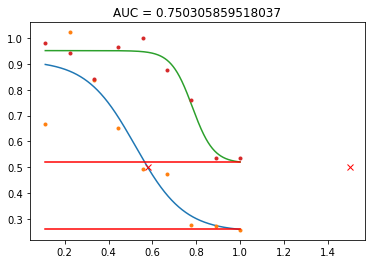

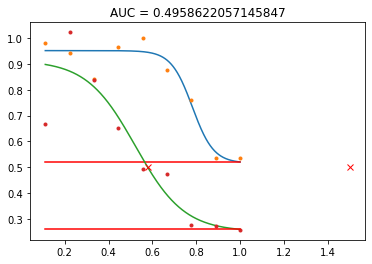

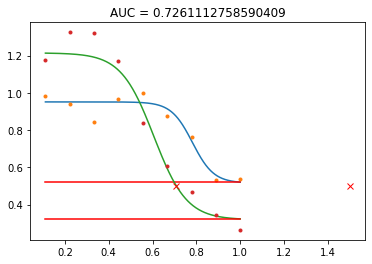

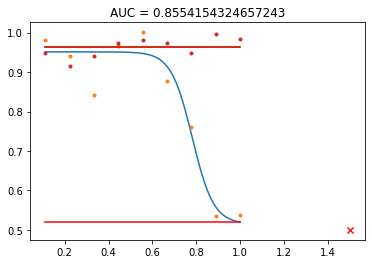

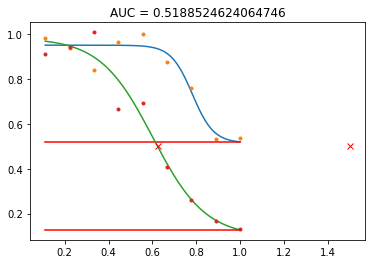

In [10]:
df_train_drug_new_list = []
df_test_drug_new_list = []

Train_5folds_X = []
Val_5folds_X = []
Train_5folds_Y = []
Val_5folds_Y = []
Train_5folds_AUC = []
Val_5folds_AUC = []
Train_5folds_IC50 = []
Val_5folds_IC50 = []
Train_5folds_Emax = []
Val_5folds_Emax = []

for Nfold in range(0, 5):
    print(f"Train Name in Nfold {Nfold}:", Train_names[Nfold])
    print(f"Test Name in Nfold {Nfold}:", Test_names[Nfold])
    df_train_No_MolecForm = pd.read_csv(
        _FOLDER + "Train/" + Train_names[Nfold])  # Contain Train dataset prepared by Subhashini-Evelyn
    df_test_No_MolecForm = pd.read_csv(
        _FOLDER + "/Test/" + Test_names[Nfold])  # Contain Test dataset prepared by Subhashini-Evelyn

    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    # we realised that the column "molecular_formula" is a string like
    # The updated files by subhashini do not have 'molecular_formula' anymore
    # df_train_No_MolecForm = df_train.drop(columns='molecular_formula')
    # df_test_No_MolecForm = df_test.drop(columns='molecular_formula')
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    try:
        df_train_No_MolecForm = df_train_No_MolecForm.drop(columns='Drug_Name')
    except:
        pass

    try:
        df_test_No_MolecForm = df_test_No_MolecForm.drop(columns='Drug_Name')
    except:
        pass

    ##df_train_No_MolecForm
    ##df_test_No_MolecForm
    ##Checking if both train and test have the same names for their columns
    print((df_train_No_MolecForm.columns == df_test_No_MolecForm.columns).sum())
    # Here we just check that from the column index 28 the input features start
    column_start = 28 
    print(df_train_No_MolecForm.columns[column_start])

    All_data_together = pd.concat([df_train_No_MolecForm[df_train_No_MolecForm.columns[column_start:]],
                                   df_test_No_MolecForm[df_test_No_MolecForm.columns[column_start:]]])
    print("Columns with std equal zero:")
    print(np.where(All_data_together.std(0) == 0.0))
    
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    df_train_drug_new_list.append(df_train_No_MolecForm.copy()) #This are lists to use in next cells
    df_test_drug_new_list.append(df_test_No_MolecForm.copy())  #This are lists to use in next cells
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    
    scaler = MinMaxScaler().fit(df_train_No_MolecForm[df_train_No_MolecForm.columns[column_start:]])
    X_train_features = scaler.transform(df_train_No_MolecForm[df_train_No_MolecForm.columns[column_start:]])
    X_test_features = scaler.transform(df_test_No_MolecForm[df_test_No_MolecForm.columns[column_start:]])

    y_train_drug = np.clip(df_train_No_MolecForm["norm_cells_" + str(1)].values[:, None], 1.0e-9, np.inf)
    y_test_drug = np.clip(df_test_No_MolecForm["norm_cells_" + str(1)].values[:, None], 1.0e-9, np.inf)
    print(y_train_drug.shape)
    for i in range(2, 10):
        y_train_drug = np.concatenate(
            (y_train_drug, np.clip(df_train_No_MolecForm["norm_cells_" + str(i)].values[:, None], 1.0e-9, np.inf)), 1)
        y_test_drug = np.concatenate(
            (y_test_drug, np.clip(df_test_No_MolecForm["norm_cells_" + str(i)].values[:, None], 1.0e-9, np.inf)), 1)

    print("Ytrain size: ", y_train_drug.shape)
    print("Ytest size: ", y_test_drug.shape)

    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    params_4_sig_train = df_train_No_MolecForm["param_" + str(1)].values[:, None]
    params_4_sig_test = df_test_No_MolecForm["param_" + str(1)].values[:, None]
    for i in range(2, 5):
        params_4_sig_train = np.concatenate(
            (params_4_sig_train, df_train_No_MolecForm["param_" + str(i)].values[:, None]), 1)
        params_4_sig_test = np.concatenate((params_4_sig_test, df_test_No_MolecForm["param_" + str(i)].values[:, None]),
                                           1)

    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    import matplotlib.pyplot as plt
    from sklearn import metrics

    x_lin = np.linspace(0.111111, 1, 1000)
    x_real_dose = np.linspace(0.111111, 1, 9)
    x_lin_tile = np.tile(x_lin, (params_4_sig_train.shape[0], 1))
    # (x_lin,params_4_sig_train.shape[0],1).shape
    Ydose_res = []
    AUC = []
    IC50 = []
    Ydose50 = []
    Emax = []
    for i in range(params_4_sig_train.shape[0]):
        Ydose_res.append(sigmoid_4_param(x_lin_tile[i, :], *params_4_sig_train[i, :]))
        AUC.append(metrics.auc(x_lin_tile[i, :], Ydose_res[i]))
        Emax.append(Ydose_res[i][-1])
        res1 = (Ydose_res[i] < 0.507)
        res2 = (Ydose_res[i] > 0.493)
        if (res1 & res2).sum() > 0:
            Ydose50.append(Ydose_res[i][res1 & res2].mean())
            IC50.append(x_lin[res1 & res2].mean())
        else:
            Ydose50.append(0.5)
            IC50.append(1.5) #IC50.append(x_lin[-1])

    posy = 90
    plt.figure(Nfold)
    plt.plot(x_lin, Ydose_res[posy])
    plt.plot(x_real_dose, y_train_drug[posy, :], '.')
    plt.plot(IC50[posy], Ydose50[posy], 'rx')
    plt.plot(x_lin, np.ones_like(x_lin)*Emax[posy], 'r') #Plot a horizontal line as Emax
    plt.title(f"AUC = {AUC[posy]}")
    print(AUC[posy])
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    import matplotlib.pyplot as plt
    from sklearn import metrics

    x_lin = np.linspace(0.111111, 1, 1000)
    x_real_dose = np.linspace(0.111111, 1, 9)
    x_lin_tile = np.tile(x_lin, (params_4_sig_test.shape[0], 1))
    # (x_lin,params_4_sig_train.shape[0],1).shape
    Ydose_res_test = []
    AUC_test = []
    IC50_test = []
    Ydose50_test = []
    Emax_test = []
    for i in range(params_4_sig_test.shape[0]):
        Ydose_res_test.append(sigmoid_4_param(x_lin_tile[i, :], *params_4_sig_test[i, :]))
        AUC_test.append(metrics.auc(x_lin_tile[i, :], Ydose_res_test[i]))
        Emax_test.append(Ydose_res_test[i][-1])
        res1 = (Ydose_res_test[i] < 0.507)
        res2 = (Ydose_res_test[i] > 0.493)
        if (res1 & res2).sum() > 0:
            Ydose50_test.append(Ydose_res_test[i][res1 & res2].mean())
            IC50_test.append(x_lin[res1 & res2].mean())
        else:
            Ydose50_test.append(0.5)
            IC50_test.append(1.5) #IC50_test.append(x_lin[-1])

    posy = 90
    plt.figure(Nfold)
    plt.plot(x_lin, Ydose_res_test[posy])
    plt.plot(x_real_dose, y_test_drug[posy, :], '.')
    plt.plot(x_lin, np.ones_like(x_lin) * Emax_test[posy], 'r')  #Plot a horizontal line as Emax
    plt.plot(IC50_test[posy], Ydose50_test[posy], 'rx')
    plt.title(f"AUC = {AUC_test[posy]}")
    print(AUC_test[posy])
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    # Compute Log(AUC)? R/ Not for Functional Random Forest Model
    # AUC = np.log(np.array(AUC))
    AUC = np.array(AUC)
    AUC_test = np.array(AUC_test)[:, None].copy()

    #Ydose50_all = np.array(Ydose50_all)
    IC50 = np.array(IC50)
    IC50_test = np.array(IC50_test)[:,None].copy()

    Emax = np.array(Emax)
    Emax_test = np.array(Emax_test)[:, None].copy()

    Xall = X_train_features.copy()
    Xtest = X_test_features.copy()

    Yall = y_train_drug.copy()
    Ytest = y_test_drug.copy()

    AUC_all = AUC[:, None].copy()
    IC50_all = IC50[:, None].copy()
    Emax_all = Emax[:, None].copy()

    print("AUC train size:", AUC_all.shape)
    print("AUC test size:", AUC_test.shape)
    print("IC50 train size:", IC50_all.shape)
    print("IC50 test size:", IC50_test.shape)
    print("Emax train size:", Emax_all.shape)
    print("Emax test size:", Emax_test.shape)
    print("X train size:", Xall.shape)
    print("X test size:", Xtest.shape)
    print("Y train size:", Yall.shape)
    print("Y test size:", Ytest.shape)

    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Val_5folds_X.append(Xtest.copy())
    Train_5folds_X.append(Xall.copy())
    Val_5folds_Y.append(Ytest.copy())
    Train_5folds_Y.append(Yall.copy())
    Val_5folds_AUC.append(AUC_test.copy())
    Train_5folds_AUC.append(AUC_all.copy())
    Val_5folds_IC50.append(IC50_test.copy())
    Train_5folds_IC50.append(IC50_all.copy())
    Val_5folds_Emax.append(Emax_test.copy())
    Train_5folds_Emax.append(Emax_all.copy())
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    


In [11]:
for Nfold in range(0,5):
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    df_train_drug_new = df_train_drug_new_list[Nfold].copy() # df_train_No_MolecForm.copy()
    df_test_drug_new = df_test_drug_new_list[Nfold].copy()   #df_test_No_MolecForm.copy()
    
    df_cosmic_train = df_train_drug_new[['COSMICID','DRUG_ID']]
    df_group_train = df_cosmic_train.groupby("DRUG_ID")['COSMICID'].unique()
    myarray_train = df_group_train.values
    for i in range(myarray_train.shape[0]):
        if Nfold==0:
            myset = {value for value in myarray_train[i]}
        else:
            myset = myset.union({value for value in myarray_train[i]})

    df_cosmic_test = df_test_drug_new[['COSMICID','DRUG_ID']]
    df_group_test = df_cosmic_test.groupby("DRUG_ID")['COSMICID'].unique()
    myarray_test = df_group_test.values
    for i in range(myarray_test.shape[0]):
        myset = myset.union({value for value in myarray_test[i]})
        
    df_drugID_train = df_train_drug_new[['COSMICID','DRUG_ID']]
    df_groupDrugID_train = df_drugID_train.groupby("COSMICID")['DRUG_ID'].unique()
    myarray_Drug_train = df_groupDrugID_train.values
    for i in range(myarray_Drug_train.shape[0]):
        if Nfold==0:
            myset_Drug = {value for value in myarray_Drug_train[i]}
        else:
            #print(len({value for value in myarray_Drug[i]}))
            aux_set = {value for value in myarray_Drug_train[i]}
            myset_Drug = myset_Drug.union(aux_set.copy())
            
    df_drugID_test = df_test_drug_new[['COSMICID','DRUG_ID']]
    df_groupDrugID_test = df_drugID_test.groupby("COSMICID")['DRUG_ID'].unique()
    myarray_Drug_test = df_groupDrugID_test.values
    for i in range(myarray_Drug_test.shape[0]):
        aux_set = {value for value in myarray_Drug_test[i]}
        myset_Drug = myset_Drug.union(aux_set.copy())

In [12]:
#df_train_drug_new["COSMIC_ID"]


In [13]:
myset_Drug

{1,
 3,
 29,
 64,
 83,
 86,
 94,
 106,
 119,
 156,
 159,
 166,
 171,
 204,
 222,
 223,
 224,
 228,
 231,
 238,
 255,
 262,
 263,
 273,
 279,
 282,
 283,
 291,
 299,
 302,
 303,
 326,
 1010,
 1014,
 1015,
 1016,
 1032,
 1036,
 1039,
 1053,
 1057,
 1058,
 1059,
 1060,
 1061,
 1062,
 1066,
 1129}

In [14]:
len(myset)
#myset

286

In [15]:
#myarray_Drug[5]
len(myset_Drug)
#myset_Drug
#df_groupDrugID_train.values[1].shape
#194*208
#139*790

48

In [16]:
list_DrugID = list(myset_Drug)
list.sort(list_DrugID)
mydict_drug = dict(zip(list_DrugID,list(np.arange(0,len(myset_Drug))))) 

list_CosmicID = list(myset)
list.sort(list_CosmicID)
mydict_cosmic = dict(zip(list_CosmicID,list(np.arange(0,len(myset))))) 

Array_Ymatrix_Train = []  #This'll contain at each position the output of each Drug concentration Training
Array_Ymatrix_Val = []    #This'll contain at each position the output of each Drug concentration Validation

for which_Yresp_out in range(9):

    Train_5folds_Ymatrix = []
    Val_5folds_Ymatrix = []
    if which_Yresp_out==0:
        Train_5folds_Ymatrix_IC50 = []
        Val_5folds_Ymatrix_IC50 = []
        Train_5folds_Ymatrix_AUC = []
        Val_5folds_Ymatrix_AUC = []
        Train_5folds_Ymatrix_Emax = []
        Val_5folds_Ymatrix_Emax = []
    
    for Nfold in range(0,5):
        #count_5Fold = [0]*5
        #Yresponse_rowcol = [[0],[0],[0],[0],[0]]
        #which_Yresp_out = 0

        Yresponse_matrix_train = np.nan* np.zeros((len(myset_Drug),len(myset)))
        Yresponse_matrix_val = np.nan* np.zeros((len(myset_Drug),len(myset)))
        if which_Yresp_out==0:
            YIC50_matrix_train = np.nan* np.zeros((len(myset_Drug),len(myset)))
            YIC50_matrix_val = np.nan* np.zeros((len(myset_Drug),len(myset)))

            YAUC_matrix_train = np.nan* np.zeros((len(myset_Drug),len(myset)))
            YAUC_matrix_val = np.nan* np.zeros((len(myset_Drug),len(myset)))

            YEmax_matrix_train = np.nan* np.zeros((len(myset_Drug),len(myset)))
            YEmax_matrix_val = np.nan* np.zeros((len(myset_Drug),len(myset)))

        #In the code below we would expect to have a Ymatrix_train with valid positions for training
        #and a Ymatrix_val with valid positions for validation, the positions valid in Ymatrix_train
        #will never coincide with any valid positions in Ymatrix_val. Both matrices are mutually exclusive
        #regarding the valid positions, although they both can coincide in np.nan values.
        for i in range(df_train_drug_new_list[Nfold].shape[0]):
            ind_row = mydict_drug[df_train_drug_new_list[Nfold]["DRUG_ID"][i]]
            ind_col = mydict_cosmic[df_train_drug_new_list[Nfold]["COSMICID"][i]]
            #this Yresponse_matrix_aux will contain particularly the info for the validation
            Yresponse_matrix_train[ind_row,ind_col] = np.log(Train_5folds_Y[Nfold][i,which_Yresp_out].copy())
            #Since there is a unique IC50, AUC and Emax for all concentrations(outputs) the
            #We use an "IF" to just avoid doing the same for all outputs
            if which_Yresp_out==0:  
                YIC50_matrix_train[ind_row,ind_col] = Train_5folds_IC50[Nfold][i].copy()
                YAUC_matrix_train[ind_row,ind_col] = Train_5folds_AUC[Nfold][i].copy()
                YEmax_matrix_train[ind_row,ind_col] = Train_5folds_Emax[Nfold][i].copy()
            print(ind_row,ind_col,i,Nfold)
        for i in range(df_test_drug_new_list[Nfold].shape[0]):
            ind_row = mydict_drug[df_test_drug_new_list[Nfold]["DRUG_ID"][i]]
            ind_col = mydict_cosmic[df_test_drug_new_list[Nfold]["COSMICID"][i]]
            #this Yresponse_matrix_aux will contain particularly the info for the validation
            Yresponse_matrix_val[ind_row,ind_col] = np.log(Val_5folds_Y[Nfold][i,which_Yresp_out].copy())
            #Since there is a unique IC50, AUC and Emax for all concentrations(outputs) the
            #We use an "IF" to just avoid doing the same for all outputs
            if which_Yresp_out==0:
                YIC50_matrix_val[ind_row,ind_col] = Val_5folds_IC50[Nfold][i].copy()
                YAUC_matrix_val[ind_row,ind_col] = Val_5folds_AUC[Nfold][i].copy()
                YEmax_matrix_val[ind_row,ind_col] = Val_5folds_Emax[Nfold][i].copy()
            

        Train_5folds_Ymatrix.append(Yresponse_matrix_train.copy())
        Val_5folds_Ymatrix.append(Yresponse_matrix_val.copy())
        if which_Yresp_out==0:
            Train_5folds_Ymatrix_IC50.append(YIC50_matrix_train.copy())
            Val_5folds_Ymatrix_IC50.append(YIC50_matrix_val.copy())

            Train_5folds_Ymatrix_AUC.append(YAUC_matrix_train.copy())
            Val_5folds_Ymatrix_AUC.append(YAUC_matrix_val.copy())

            Train_5folds_Ymatrix_Emax.append(YEmax_matrix_train.copy())
            Val_5folds_Ymatrix_Emax.append(YEmax_matrix_val.copy())

    Array_Ymatrix_Train.append(Train_5folds_Ymatrix.copy())
    Array_Ymatrix_Val.append(Val_5folds_Ymatrix.copy())

0 161 0 0
0 222 1 0
0 224 2 0
0 227 3 0
0 223 4 0
1 161 5 0
1 107 6 0
1 7 7 0
1 215 8 0
1 112 9 0
1 2 10 0
1 212 11 0
1 147 12 0
1 145 13 0
1 162 14 0
1 146 15 0
1 111 16 0
1 227 17 0
1 109 18 0
1 210 19 0
1 163 20 0
1 223 21 0
36 241 22 0
36 7 23 0
36 134 24 0
36 162 25 0
36 146 26 0
36 123 27 0
36 133 28 0
36 126 29 0
37 159 30 0
37 238 31 0
37 8 32 0
37 215 33 0
37 225 34 0
37 194 35 0
37 110 36 0
37 6 37 0
37 212 38 0
37 5 39 0
37 162 40 0
37 242 41 0
37 210 42 0
38 107 43 0
38 159 44 0
38 238 45 0
38 222 46 0
38 134 47 0
38 6 48 0
38 227 49 0
38 210 50 0
38 198 51 0
2 161 52 0
2 107 53 0
2 181 54 0
2 224 55 0
2 146 56 0
2 149 57 0
2 223 58 0
39 107 59 0
39 238 60 0
39 8 61 0
39 110 62 0
39 112 63 0
39 226 64 0
39 212 65 0
39 158 66 0
39 147 67 0
39 5 68 0
39 162 69 0
39 111 70 0
39 1 71 0
39 123 72 0
39 133 73 0
39 109 74 0
39 126 75 0
39 242 76 0
39 70 77 0
39 127 78 0
39 191 79 0
39 198 80 0
39 223 81 0
40 107 82 0
40 159 83 0
40 238 84 0
40 222 85 0
40 189 86 0
40 134 87 0
40 8

45 115 861 0
45 201 862 0
45 275 863 0
45 264 864 0
45 239 865 0
45 106 866 0
45 256 867 0
45 81 868 0
45 75 869 0
45 96 870 0
45 180 871 0
45 143 872 0
45 122 873 0
45 274 874 0
45 141 875 0
45 233 876 0
45 97 877 0
45 267 878 0
45 155 879 0
3 106 880 0
3 184 881 0
4 206 882 0
4 68 883 0
4 96 884 0
4 141 885 0
4 103 886 0
4 182 887 0
4 184 888 0
4 233 889 0
5 206 890 0
5 106 891 0
5 81 892 0
5 141 893 0
5 182 894 0
5 230 895 0
6 219 896 0
6 120 897 0
6 68 898 0
6 96 899 0
6 184 900 0
6 233 901 0
6 74 902 0
47 201 903 0
47 239 904 0
47 81 905 0
47 142 906 0
47 220 907 0
47 140 908 0
47 180 909 0
47 114 910 0
47 157 911 0
47 0 912 0
47 141 913 0
47 182 914 0
47 95 915 0
47 155 916 0
7 206 917 0
7 182 918 0
8 219 919 0
8 206 920 0
8 106 921 0
8 144 922 0
8 75 923 0
8 182 924 0
9 219 925 0
9 115 926 0
9 106 927 0
9 209 928 0
9 256 929 0
9 68 930 0
9 142 931 0
9 96 932 0
9 233 933 0
9 105 934 0
9 95 935 0
10 219 936 0
10 115 937 0
10 235 938 0
10 201 939 0
10 275 940 0
10 206 941 0
10 256 

24 36 1952 0
24 263 1953 0
24 118 1954 0
25 175 1955 0
25 83 1956 0
25 80 1957 0
25 31 1958 0
25 26 1959 0
25 278 1960 0
25 39 1961 0
25 244 1962 0
25 273 1963 0
25 54 1964 0
25 34 1965 0
25 25 1966 0
25 177 1967 0
25 23 1968 0
25 282 1969 0
25 118 1970 0
25 250 1971 0
25 30 1972 0
25 22 1973 0
26 40 1974 0
26 178 1975 0
26 37 1976 0
26 39 1977 0
26 273 1978 0
26 25 1979 0
26 73 1980 0
26 263 1981 0
26 176 1982 0
26 88 1983 0
26 35 1984 0
26 28 1985 0
26 38 1986 0
26 21 1987 0
26 77 1988 0
27 169 1989 0
27 72 1990 0
27 244 1991 0
27 78 1992 0
27 177 1993 0
27 211 1994 0
27 282 1995 0
27 30 1996 0
28 31 1997 0
28 248 1998 0
28 44 1999 0
28 244 2000 0
28 54 2001 0
28 25 2002 0
28 73 2003 0
28 263 2004 0
28 282 2005 0
28 38 2006 0
28 43 2007 0
28 45 2008 0
29 262 2009 0
29 27 2010 0
29 178 2011 0
29 80 2012 0
29 31 2013 0
29 248 2014 0
29 72 2015 0
29 278 2016 0
29 44 2017 0
29 39 2018 0
29 244 2019 0
29 86 2020 0
29 54 2021 0
29 73 2022 0
29 69 2023 0
29 23 2024 0
29 282 2025 0
29 88 202

26 47 2777 0
26 51 2778 0
26 165 2779 0
26 16 2780 0
26 10 2781 0
27 14 2782 0
27 172 2783 0
27 237 2784 0
27 203 2785 0
27 53 2786 0
27 18 2787 0
27 57 2788 0
28 14 2789 0
28 249 2790 0
28 113 2791 0
28 15 2792 0
28 17 2793 0
28 56 2794 0
28 90 2795 0
28 117 2796 0
28 9 2797 0
28 57 2798 0
28 102 2799 0
28 254 2800 0
28 48 2801 0
28 79 2802 0
28 167 2803 0
28 171 2804 0
28 260 2805 0
28 150 2806 0
28 87 2807 0
28 49 2808 0
28 217 2809 0
28 101 2810 0
28 165 2811 0
28 10 2812 0
29 14 2813 0
29 249 2814 0
29 174 2815 0
29 113 2816 0
29 100 2817 0
29 15 2818 0
29 46 2819 0
29 164 2820 0
29 89 2821 0
29 237 2822 0
29 17 2823 0
29 247 2824 0
29 56 2825 0
29 272 2826 0
29 90 2827 0
29 12 2828 0
29 203 2829 0
29 52 2830 0
29 53 2831 0
29 208 2832 0
29 9 2833 0
29 20 2834 0
29 102 2835 0
29 183 2836 0
29 252 2837 0
29 166 2838 0
29 79 2839 0
29 284 2840 0
29 167 2841 0
29 260 2842 0
29 236 2843 0
29 150 2844 0
29 87 2845 0
29 255 2846 0
29 49 2847 0
29 173 2848 0
29 217 2849 0
29 101 2850 0
2

42 106 832 1
42 193 833 1
42 256 834 1
42 81 835 1
42 75 836 1
42 68 837 1
42 156 838 1
42 125 839 1
42 180 840 1
42 122 841 1
42 274 842 1
42 233 843 1
42 74 844 1
42 105 845 1
42 97 846 1
42 267 847 1
42 155 848 1
42 188 849 1
46 115 850 1
46 67 851 1
46 264 852 1
46 239 853 1
46 206 854 1
46 106 855 1
46 193 856 1
46 81 857 1
46 75 858 1
46 68 859 1
46 131 860 1
46 125 861 1
46 182 862 1
46 184 863 1
46 97 864 1
45 115 865 1
45 201 866 1
45 275 867 1
45 264 868 1
45 239 869 1
45 106 870 1
45 256 871 1
45 81 872 1
45 75 873 1
45 96 874 1
45 180 875 1
45 143 876 1
45 122 877 1
45 274 878 1
45 141 879 1
45 233 880 1
45 97 881 1
45 267 882 1
45 155 883 1
3 106 884 1
3 184 885 1
4 206 886 1
4 68 887 1
4 96 888 1
4 141 889 1
4 103 890 1
4 182 891 1
4 184 892 1
4 233 893 1
5 206 894 1
5 106 895 1
5 81 896 1
5 141 897 1
5 182 898 1
5 230 899 1
6 219 900 1
6 120 901 1
6 68 902 1
6 96 903 1
6 184 904 1
6 233 905 1
6 74 906 1
47 201 907 1
47 239 908 1
47 81 909 1
47 142 910 1
47 220 911 1
47 1

42 32 1569 1
42 248 1570 1
42 72 1571 1
42 273 1572 1
42 78 1573 1
42 25 1574 1
42 177 1575 1
42 36 1576 1
42 263 1577 1
42 270 1578 1
42 24 1579 1
42 35 1580 1
42 250 1581 1
42 197 1582 1
42 22 1583 1
42 283 1584 1
46 40 1585 1
46 175 1586 1
46 83 1587 1
46 32 1588 1
46 29 1589 1
46 44 1590 1
46 244 1591 1
46 273 1592 1
46 86 1593 1
46 54 1594 1
46 25 1595 1
46 73 1596 1
46 24 1597 1
46 71 1598 1
46 88 1599 1
46 118 1600 1
46 35 1601 1
46 42 1602 1
46 250 1603 1
46 28 1604 1
46 38 1605 1
46 43 1606 1
46 77 1607 1
46 202 1608 1
46 281 1609 1
45 40 1610 1
45 26 1611 1
45 37 1612 1
45 273 1613 1
45 86 1614 1
45 251 1615 1
45 118 1616 1
45 42 1617 1
45 202 1618 1
3 175 1619 1
3 211 1620 1
3 71 1621 1
4 40 1622 1
4 27 1623 1
4 82 1624 1
4 175 1625 1
4 178 1626 1
4 83 1627 1
4 32 1628 1
4 80 1629 1
4 31 1630 1
4 248 1631 1
4 26 1632 1
4 37 1633 1
4 72 1634 1
4 278 1635 1
4 44 1636 1
4 39 1637 1
4 244 1638 1
4 86 1639 1
4 78 1640 1
4 251 1641 1
4 73 1642 1
4 76 1643 1
4 263 1644 1
4 211 1645

25 269 2744 1
25 85 2745 1
25 183 2746 1
25 284 2747 1
25 167 2748 1
25 55 2749 1
25 11 2750 1
25 173 2751 1
25 165 2752 1
25 285 2753 1
26 14 2754 1
26 249 2755 1
26 174 2756 1
26 19 2757 1
26 196 2758 1
26 164 2759 1
26 237 2760 1
26 17 2761 1
26 56 2762 1
26 90 2763 1
26 12 2764 1
26 117 2765 1
26 208 2766 1
26 9 2767 1
26 20 2768 1
26 85 2769 1
26 166 2770 1
26 79 2771 1
26 284 2772 1
26 167 2773 1
26 171 2774 1
26 260 2775 1
26 87 2776 1
26 255 2777 1
26 245 2778 1
26 49 2779 1
26 173 2780 1
26 47 2781 1
26 51 2782 1
26 165 2783 1
26 16 2784 1
26 10 2785 1
27 14 2786 1
27 172 2787 1
27 237 2788 1
27 203 2789 1
27 53 2790 1
27 18 2791 1
27 57 2792 1
28 14 2793 1
28 249 2794 1
28 113 2795 1
28 15 2796 1
28 17 2797 1
28 56 2798 1
28 90 2799 1
28 117 2800 1
28 9 2801 1
28 57 2802 1
28 102 2803 1
28 254 2804 1
28 48 2805 1
28 79 2806 1
28 167 2807 1
28 171 2808 1
28 260 2809 1
28 150 2810 1
28 87 2811 1
28 49 2812 1
28 217 2813 1
28 101 2814 1
28 165 2815 1
28 10 2816 1
29 14 2817 1
29

26 214 512 2
26 179 513 2
26 279 514 2
26 152 515 2
26 277 516 2
26 153 517 2
26 61 518 2
26 243 519 2
26 200 520 2
26 199 521 2
26 64 522 2
26 266 523 2
27 92 524 2
27 218 525 2
27 64 526 2
28 221 527 2
28 65 528 2
28 213 529 2
28 136 530 2
28 99 531 2
28 91 532 2
28 154 533 2
28 160 534 2
28 231 535 2
28 92 536 2
28 216 537 2
28 179 538 2
28 277 539 2
28 153 540 2
28 200 541 2
29 261 542 2
29 221 543 2
29 65 544 2
29 213 545 2
29 136 546 2
29 99 547 2
29 192 548 2
29 91 549 2
29 63 550 2
29 129 551 2
29 229 552 2
29 205 553 2
29 124 554 2
29 62 555 2
29 116 556 2
29 160 557 2
29 231 558 2
29 60 559 2
29 130 560 2
29 66 561 2
29 151 562 2
29 280 563 2
29 218 564 2
29 179 565 2
29 277 566 2
29 61 567 2
29 243 568 2
29 200 569 2
29 59 570 2
29 266 571 2
30 98 572 2
30 58 573 2
30 218 574 2
30 279 575 2
30 199 576 2
31 261 577 2
31 65 578 2
31 136 579 2
31 192 580 2
31 63 581 2
31 207 582 2
31 129 583 2
31 62 584 2
31 116 585 2
31 58 586 2
31 137 587 2
31 60 588 2
31 130 589 2
31 66 590 

42 122 1500 2
42 274 1501 2
42 233 1502 2
42 74 1503 2
42 105 1504 2
42 97 1505 2
42 267 1506 2
42 155 1507 2
42 188 1508 2
46 115 1509 2
46 67 1510 2
46 264 1511 2
46 239 1512 2
46 206 1513 2
46 106 1514 2
46 193 1515 2
46 81 1516 2
46 75 1517 2
46 68 1518 2
46 131 1519 2
46 125 1520 2
46 182 1521 2
46 184 1522 2
46 97 1523 2
45 115 1524 2
45 201 1525 2
45 275 1526 2
45 264 1527 2
45 239 1528 2
45 106 1529 2
45 256 1530 2
45 81 1531 2
45 75 1532 2
45 96 1533 2
45 180 1534 2
45 143 1535 2
45 122 1536 2
45 274 1537 2
45 141 1538 2
45 233 1539 2
45 97 1540 2
45 267 1541 2
45 155 1542 2
3 106 1543 2
3 184 1544 2
4 206 1545 2
4 68 1546 2
4 96 1547 2
4 141 1548 2
4 103 1549 2
4 182 1550 2
4 184 1551 2
4 233 1552 2
5 206 1553 2
5 106 1554 2
5 81 1555 2
5 141 1556 2
5 182 1557 2
5 230 1558 2
6 219 1559 2
6 120 1560 2
6 68 1561 2
6 96 1562 2
6 184 1563 2
6 233 1564 2
6 74 1565 2
47 201 1566 2
47 239 1567 2
47 81 1568 2
47 142 1569 2
47 220 1570 2
47 140 1571 2
47 180 1572 2
47 114 1573 2
47 15

8 71 2369 2
8 118 2370 2
8 42 2371 2
8 77 2372 2
9 27 2373 2
9 83 2374 2
9 32 2375 2
9 80 2376 2
9 248 2377 2
9 37 2378 2
9 29 2379 2
9 244 2380 2
9 273 2381 2
9 86 2382 2
9 34 2383 2
9 78 2384 2
9 177 2385 2
9 73 2386 2
9 270 2387 2
9 24 2388 2
9 28 2389 2
10 148 2390 2
10 27 2391 2
10 80 2392 2
10 31 2393 2
10 37 2394 2
10 34 2395 2
10 177 2396 2
10 251 2397 2
10 263 2398 2
10 118 2399 2
10 35 2400 2
10 250 2401 2
10 30 2402 2
10 77 2403 2
11 83 2404 2
11 169 2405 2
11 72 2406 2
11 278 2407 2
11 29 2408 2
11 44 2409 2
11 86 2410 2
11 54 2411 2
11 34 2412 2
11 25 2413 2
11 177 2414 2
11 251 2415 2
11 73 2416 2
11 36 2417 2
11 211 2418 2
11 23 2419 2
11 270 2420 2
11 24 2421 2
11 38 2422 2
11 30 2423 2
11 77 2424 2
12 83 2425 2
12 32 2426 2
12 246 2427 2
12 26 2428 2
12 37 2429 2
12 72 2430 2
12 278 2431 2
12 29 2432 2
12 86 2433 2
12 78 2434 2
12 177 2435 2
12 73 2436 2
12 36 2437 2
12 23 2438 2
12 118 2439 2
12 35 2440 2
12 38 2441 2
13 27 2442 2
13 248 2443 2
13 26 2444 2
13 72 2445

37 212 701 3
37 5 702 3
37 162 703 3
37 242 704 3
37 210 705 3
38 107 706 3
38 159 707 3
38 238 708 3
38 222 709 3
38 134 710 3
38 6 711 3
38 227 712 3
38 210 713 3
38 198 714 3
2 161 715 3
2 107 716 3
2 181 717 3
2 224 718 3
2 146 719 3
2 149 720 3
2 223 721 3
39 107 722 3
39 238 723 3
39 8 724 3
39 110 725 3
39 112 726 3
39 226 727 3
39 212 728 3
39 158 729 3
39 147 730 3
39 5 731 3
39 162 732 3
39 111 733 3
39 1 734 3
39 123 735 3
39 133 736 3
39 109 737 3
39 126 738 3
39 242 739 3
39 70 740 3
39 127 741 3
39 191 742 3
39 198 743 3
39 223 744 3
40 107 745 3
40 159 746 3
40 238 747 3
40 222 748 3
40 189 749 3
40 134 750 3
40 8 751 3
40 4 752 3
40 215 753 3
40 194 754 3
40 110 755 3
40 112 756 3
40 226 757 3
40 2 758 3
40 212 759 3
40 158 760 3
40 147 761 3
40 5 762 3
40 146 763 3
40 1 764 3
40 149 765 3
40 232 766 3
40 132 767 3
40 123 768 3
40 135 769 3
40 227 770 3
40 133 771 3
40 126 772 3
40 242 773 3
40 70 774 3
40 210 775 3
40 228 776 3
40 191 777 3
40 198 778 3
40 240 779 3
41

4 184 1551 3
4 233 1552 3
5 206 1553 3
5 106 1554 3
5 81 1555 3
5 141 1556 3
5 182 1557 3
5 230 1558 3
6 219 1559 3
6 120 1560 3
6 68 1561 3
6 96 1562 3
6 184 1563 3
6 233 1564 3
6 74 1565 3
47 201 1566 3
47 239 1567 3
47 81 1568 3
47 142 1569 3
47 220 1570 3
47 140 1571 3
47 180 1572 3
47 114 1573 3
47 157 1574 3
47 0 1575 3
47 141 1576 3
47 182 1577 3
47 95 1578 3
47 155 1579 3
7 206 1580 3
7 182 1581 3
8 219 1582 3
8 206 1583 3
8 106 1584 3
8 144 1585 3
8 75 1586 3
8 182 1587 3
9 219 1588 3
9 115 1589 3
9 106 1590 3
9 209 1591 3
9 256 1592 3
9 68 1593 3
9 142 1594 3
9 96 1595 3
9 233 1596 3
9 105 1597 3
9 95 1598 3
10 219 1599 3
10 115 1600 3
10 235 1601 3
10 201 1602 3
10 275 1603 3
10 206 1604 3
10 256 1605 3
10 68 1606 3
10 142 1607 3
10 156 1608 3
10 131 1609 3
10 180 1610 3
10 114 1611 3
10 0 1612 3
10 122 1613 3
10 274 1614 3
10 141 1615 3
10 234 1616 3
10 103 1617 3
10 265 1618 3
10 186 1619 3
10 267 1620 3
11 121 1621 3
11 204 1622 3
11 220 1623 3
11 114 1624 3
11 274 1625 3

15 16 2416 3
15 10 2417 3
16 14 2418 3
16 113 2419 3
16 89 2420 3
16 237 2421 3
16 272 2422 3
16 90 2423 3
16 203 2424 3
16 52 2425 3
16 208 2426 3
16 20 2427 3
16 269 2428 3
16 50 2429 3
16 284 2430 3
16 171 2431 3
16 101 2432 3
16 51 2433 3
16 285 2434 3
17 84 2435 3
17 113 2436 3
17 100 2437 3
17 170 2438 3
17 164 2439 3
17 237 2440 3
17 247 2441 3
17 56 2442 3
17 90 2443 3
17 208 2444 3
17 18 2445 3
17 20 2446 3
17 57 2447 3
17 269 2448 3
17 50 2449 3
17 252 2450 3
17 255 2451 3
17 245 2452 3
17 49 2453 3
17 101 2454 3
17 16 2455 3
17 10 2456 3
18 14 2457 3
18 84 2458 3
18 174 2459 3
18 89 2460 3
18 17 2461 3
18 56 2462 3
18 90 2463 3
18 52 2464 3
18 269 2465 3
18 102 2466 3
18 50 2467 3
18 254 2468 3
18 48 2469 3
18 79 2470 3
18 171 2471 3
18 255 2472 3
18 245 2473 3
18 49 2474 3
18 101 2475 3
18 47 2476 3
18 51 2477 3
18 165 2478 3
18 16 2479 3
19 14 2480 3
19 249 2481 3
19 19 2482 3
19 113 2483 3
19 100 2484 3
19 196 2485 3
19 170 2486 3
19 46 2487 3
19 247 2488 3
19 272 2489 3


31 151 591 4
31 216 592 4
31 119 593 4
31 179 594 4
31 279 595 4
31 61 596 4
31 128 597 4
31 200 598 4
31 199 599 4
31 64 600 4
31 59 601 4
31 138 602 4
31 266 603 4
32 261 604 4
32 221 605 4
32 98 606 4
32 124 607 4
32 116 608 4
32 231 609 4
32 66 610 4
32 280 611 4
32 277 612 4
32 257 613 4
32 259 614 4
32 64 615 4
32 59 616 4
33 261 617 4
33 221 618 4
33 99 619 4
33 63 620 4
33 207 621 4
33 116 622 4
33 58 623 4
33 60 624 4
33 130 625 4
33 66 626 4
33 216 627 4
33 277 628 4
33 61 629 4
33 128 630 4
33 200 631 4
33 64 632 4
33 266 633 4
33 94 634 4
33 195 635 4
34 65 636 4
34 99 637 4
34 192 638 4
34 98 639 4
34 58 640 4
34 66 641 4
34 277 642 4
34 128 643 4
34 200 644 4
35 261 645 4
35 221 646 4
35 65 647 4
35 213 648 4
35 99 649 4
35 124 650 4
35 116 651 4
35 231 652 4
35 60 653 4
35 66 654 4
35 258 655 4
35 277 656 4
35 153 657 4
35 61 658 4
35 243 659 4
35 128 660 4
35 59 661 4
35 266 662 4
0 161 663 4
0 222 664 4
0 224 665 4
0 227 666 4
0 223 667 4
1 161 668 4
1 107 669 4
1 7 67

37 83 1368 4
37 169 1369 4
37 32 1370 4
37 31 1371 4
37 39 1372 4
37 78 1373 4
37 251 1374 4
37 73 1375 4
37 76 1376 4
37 36 1377 4
37 35 1378 4
37 250 1379 4
37 28 1380 4
37 45 1381 4
37 22 1382 4
37 202 1383 4
37 281 1384 4
38 40 1385 4
38 169 1386 4
38 31 1387 4
38 86 1388 4
38 76 1389 4
38 71 1390 4
38 77 1391 4
38 22 1392 4
38 202 1393 4
2 40 1394 4
2 32 1395 4
2 31 1396 4
2 26 1397 4
2 72 1398 4
2 44 1399 4
2 244 1400 4
2 54 1401 4
2 34 1402 4
2 177 1403 4
2 73 1404 4
2 263 1405 4
2 211 1406 4
2 33 1407 4
2 71 1408 4
2 118 1409 4
2 42 1410 4
2 28 1411 4
2 77 1412 4
39 169 1413 4
39 32 1414 4
39 80 1415 4
39 37 1416 4
39 39 1417 4
39 86 1418 4
39 177 1419 4
39 251 1420 4
39 36 1421 4
39 211 1422 4
39 270 1423 4
39 24 1424 4
39 71 1425 4
39 282 1426 4
39 88 1427 4
39 35 1428 4
39 42 1429 4
39 250 1430 4
39 28 1431 4
39 38 1432 4
39 45 1433 4
39 77 1434 4
39 283 1435 4
39 281 1436 4
40 31 1437 4
40 248 1438 4
40 37 1439 4
40 72 1440 4
40 244 1441 4
40 86 1442 4
40 78 1443 4
40 177 1

25 57 2680 4
25 269 2681 4
25 85 2682 4
25 183 2683 4
25 284 2684 4
25 167 2685 4
25 55 2686 4
25 11 2687 4
25 173 2688 4
25 165 2689 4
25 285 2690 4
26 14 2691 4
26 249 2692 4
26 174 2693 4
26 19 2694 4
26 196 2695 4
26 164 2696 4
26 237 2697 4
26 17 2698 4
26 56 2699 4
26 90 2700 4
26 12 2701 4
26 117 2702 4
26 208 2703 4
26 9 2704 4
26 20 2705 4
26 85 2706 4
26 166 2707 4
26 79 2708 4
26 284 2709 4
26 167 2710 4
26 171 2711 4
26 260 2712 4
26 87 2713 4
26 255 2714 4
26 245 2715 4
26 49 2716 4
26 173 2717 4
26 47 2718 4
26 51 2719 4
26 165 2720 4
26 16 2721 4
26 10 2722 4
27 14 2723 4
27 172 2724 4
27 237 2725 4
27 203 2726 4
27 53 2727 4
27 18 2728 4
27 57 2729 4
28 14 2730 4
28 249 2731 4
28 113 2732 4
28 15 2733 4
28 17 2734 4
28 56 2735 4
28 90 2736 4
28 117 2737 4
28 9 2738 4
28 57 2739 4
28 102 2740 4
28 254 2741 4
28 48 2742 4
28 79 2743 4
28 167 2744 4
28 171 2745 4
28 260 2746 4
28 150 2747 4
28 87 2748 4
28 49 2749 4
28 217 2750 4
28 101 2751 4
28 165 2752 4
28 10 2753 4
29

29 126 579 0
29 242 580 0
29 70 581 0
29 190 582 0
29 198 583 0
29 163 584 0
30 241 585 0
30 181 586 0
30 225 587 0
30 6 588 0
30 158 589 0
30 135 590 0
31 107 591 0
31 159 592 0
31 238 593 0
31 7 594 0
31 181 595 0
31 108 596 0
31 8 597 0
31 215 598 0
31 225 599 0
31 224 600 0
31 110 601 0
31 6 602 0
31 112 603 0
31 226 604 0
31 2 605 0
31 212 606 0
31 146 607 0
31 1 608 0
31 149 609 0
31 232 610 0
31 132 611 0
31 227 612 0
31 109 613 0
31 126 614 0
31 242 615 0
31 190 616 0
31 198 617 0
31 163 618 0
32 241 619 0
32 225 620 0
32 224 621 0
32 6 622 0
32 112 623 0
32 135 624 0
32 227 625 0
32 228 626 0
32 223 627 0
33 181 628 0
33 134 629 0
33 110 630 0
33 112 631 0
33 5 632 0
33 1 633 0
33 70 634 0
33 191 635 0
34 7 636 0
34 181 637 0
34 108 638 0
34 4 639 0
34 215 640 0
34 146 641 0
34 1 642 0
34 127 643 0
34 163 644 0
35 161 645 0
35 7 646 0
35 189 647 0
35 215 648 0
35 225 649 0
35 110 650 0
35 2 651 0
35 212 652 0
35 158 653 0
35 162 654 0
35 111 655 0
35 1 656 0
35 123 657 0
35 10

7 36 1693 0
7 176 1694 0
7 282 1695 0
8 40 1696 0
8 248 1697 0
8 26 1698 0
8 72 1699 0
8 29 1700 0
8 39 1701 0
8 86 1702 0
8 78 1703 0
8 73 1704 0
8 263 1705 0
8 71 1706 0
8 118 1707 0
8 42 1708 0
8 77 1709 0
9 27 1710 0
9 83 1711 0
9 32 1712 0
9 80 1713 0
9 248 1714 0
9 37 1715 0
9 29 1716 0
9 244 1717 0
9 273 1718 0
9 86 1719 0
9 34 1720 0
9 78 1721 0
9 177 1722 0
9 73 1723 0
9 270 1724 0
9 24 1725 0
9 28 1726 0
10 148 1727 0
10 27 1728 0
10 80 1729 0
10 31 1730 0
10 37 1731 0
10 34 1732 0
10 177 1733 0
10 251 1734 0
10 263 1735 0
10 118 1736 0
10 35 1737 0
10 250 1738 0
10 30 1739 0
10 77 1740 0
11 83 1741 0
11 169 1742 0
11 72 1743 0
11 278 1744 0
11 29 1745 0
11 44 1746 0
11 86 1747 0
11 54 1748 0
11 34 1749 0
11 25 1750 0
11 177 1751 0
11 251 1752 0
11 73 1753 0
11 36 1754 0
11 211 1755 0
11 23 1756 0
11 270 1757 0
11 24 1758 0
11 38 1759 0
11 30 1760 0
11 77 1761 0
12 83 1762 0
12 32 1763 0
12 246 1764 0
12 26 1765 0
12 37 1766 0
12 72 1767 0
12 278 1768 0
12 29 1769 0
12 86 177

27 172 2783 0
27 237 2784 0
27 203 2785 0
27 53 2786 0
27 18 2787 0
27 57 2788 0
28 14 2789 0
28 249 2790 0
28 113 2791 0
28 15 2792 0
28 17 2793 0
28 56 2794 0
28 90 2795 0
28 117 2796 0
28 9 2797 0
28 57 2798 0
28 102 2799 0
28 254 2800 0
28 48 2801 0
28 79 2802 0
28 167 2803 0
28 171 2804 0
28 260 2805 0
28 150 2806 0
28 87 2807 0
28 49 2808 0
28 217 2809 0
28 101 2810 0
28 165 2811 0
28 10 2812 0
29 14 2813 0
29 249 2814 0
29 174 2815 0
29 113 2816 0
29 100 2817 0
29 15 2818 0
29 46 2819 0
29 164 2820 0
29 89 2821 0
29 237 2822 0
29 17 2823 0
29 247 2824 0
29 56 2825 0
29 272 2826 0
29 90 2827 0
29 12 2828 0
29 203 2829 0
29 52 2830 0
29 53 2831 0
29 208 2832 0
29 9 2833 0
29 20 2834 0
29 102 2835 0
29 183 2836 0
29 252 2837 0
29 166 2838 0
29 79 2839 0
29 284 2840 0
29 167 2841 0
29 260 2842 0
29 236 2843 0
29 150 2844 0
29 87 2845 0
29 255 2846 0
29 49 2847 0
29 173 2848 0
29 217 2849 0
29 101 2850 0
29 51 2851 0
29 16 2852 0
29 285 2853 0
29 10 2854 0
30 14 2855 0
30 100 2856 0


43 142 810 1
43 96 811 1
43 125 812 1
43 180 813 1
43 143 814 1
43 122 815 1
43 141 816 1
43 234 817 1
43 103 818 1
43 182 819 1
43 184 820 1
43 233 821 1
43 74 822 1
43 105 823 1
43 95 824 1
43 97 825 1
43 155 826 1
42 201 827 1
42 275 828 1
42 264 829 1
42 239 830 1
42 206 831 1
42 106 832 1
42 193 833 1
42 256 834 1
42 81 835 1
42 75 836 1
42 68 837 1
42 156 838 1
42 125 839 1
42 180 840 1
42 122 841 1
42 274 842 1
42 233 843 1
42 74 844 1
42 105 845 1
42 97 846 1
42 267 847 1
42 155 848 1
42 188 849 1
46 115 850 1
46 67 851 1
46 264 852 1
46 239 853 1
46 206 854 1
46 106 855 1
46 193 856 1
46 81 857 1
46 75 858 1
46 68 859 1
46 131 860 1
46 125 861 1
46 182 862 1
46 184 863 1
46 97 864 1
45 115 865 1
45 201 866 1
45 275 867 1
45 264 868 1
45 239 869 1
45 106 870 1
45 256 871 1
45 81 872 1
45 75 873 1
45 96 874 1
45 180 875 1
45 143 876 1
45 122 877 1
45 274 878 1
45 141 879 1
45 233 880 1
45 97 881 1
45 267 882 1
45 155 883 1
3 106 884 1
3 184 885 1
4 206 886 1
4 68 887 1
4 96 888 

13 23 1791 1
13 282 1792 1
13 35 1793 1
13 28 1794 1
13 30 1795 1
13 22 1796 1
44 40 1797 1
44 169 1798 1
44 31 1799 1
44 248 1800 1
44 37 1801 1
44 177 1802 1
44 24 1803 1
14 40 1804 1
14 175 1805 1
14 83 1806 1
14 246 1807 1
14 26 1808 1
14 72 1809 1
14 39 1810 1
14 34 1811 1
14 25 1812 1
14 177 1813 1
14 263 1814 1
14 24 1815 1
14 282 1816 1
14 28 1817 1
14 197 1818 1
14 77 1819 1
15 148 1820 1
15 262 1821 1
15 27 1822 1
15 83 1823 1
15 80 1824 1
15 246 1825 1
15 244 1826 1
15 86 1827 1
15 54 1828 1
15 34 1829 1
15 25 1830 1
15 28 1831 1
15 38 1832 1
15 43 1833 1
15 21 1834 1
15 45 1835 1
16 175 1836 1
16 83 1837 1
16 246 1838 1
16 37 1839 1
16 36 1840 1
16 23 1841 1
16 43 1842 1
17 23 1843 1
17 71 1844 1
17 30 1845 1
17 77 1846 1
18 40 1847 1
18 175 1848 1
18 169 1849 1
18 246 1850 1
18 248 1851 1
18 39 1852 1
18 73 1853 1
18 211 1854 1
18 118 1855 1
18 250 1856 1
18 77 1857 1
19 27 1858 1
19 175 1859 1
19 83 1860 1
19 32 1861 1
19 31 1862 1
19 246 1863 1
19 248 1864 1
19 26 1865 1

29 173 2852 1
29 217 2853 1
29 101 2854 1
29 51 2855 1
29 16 2856 1
29 285 2857 1
29 10 2858 1
30 14 2859 1
30 100 2860 1
30 196 2861 1
30 18 2862 1
30 57 2863 1
30 173 2864 1
30 165 2865 1
31 249 2866 1
31 84 2867 1
31 113 2868 1
31 15 2869 1
31 196 2870 1
31 46 2871 1
31 164 2872 1
31 172 2873 1
31 237 2874 1
31 17 2875 1
31 247 2876 1
31 272 2877 1
31 117 2878 1
31 208 2879 1
31 9 2880 1
31 57 2881 1
31 102 2882 1
31 252 2883 1
31 254 2884 1
31 48 2885 1
31 79 2886 1
31 284 2887 1
31 167 2888 1
31 171 2889 1
31 260 2890 1
31 236 2891 1
31 150 2892 1
31 87 2893 1
31 255 2894 1
31 49 2895 1
31 47 2896 1
31 165 2897 1
31 16 2898 1
31 285 2899 1
31 10 2900 1
32 84 2901 1
32 174 2902 1
32 113 2903 1
32 100 2904 1
32 237 2905 1
32 272 2906 1
32 20 2907 1
32 57 2908 1
32 85 2909 1
32 254 2910 1
32 48 2911 1
32 171 2912 1
32 87 2913 1
32 11 2914 1
32 217 2915 1
32 101 2916 1
32 51 2917 1
32 165 2918 1
32 285 2919 1
32 10 2920 1
32 41 2921 1
33 249 2922 1
33 84 2923 1
33 19 2924 1
33 15 2925

33 66 626 2
33 216 627 2
33 277 628 2
33 61 629 2
33 128 630 2
33 200 631 2
33 64 632 2
33 266 633 2
33 94 634 2
33 195 635 2
34 65 636 2
34 99 637 2
34 192 638 2
34 98 639 2
34 58 640 2
34 66 641 2
34 277 642 2
34 128 643 2
34 200 644 2
35 261 645 2
35 221 646 2
35 65 647 2
35 213 648 2
35 99 649 2
35 124 650 2
35 116 651 2
35 231 652 2
35 60 653 2
35 66 654 2
35 258 655 2
35 277 656 2
35 153 657 2
35 61 658 2
35 243 659 2
35 128 660 2
35 59 661 2
35 266 662 2
0 161 663 2
0 222 664 2
0 224 665 2
0 227 666 2
0 223 667 2
1 161 668 2
1 107 669 2
1 7 670 2
1 215 671 2
1 112 672 2
1 2 673 2
1 212 674 2
1 147 675 2
1 145 676 2
1 162 677 2
1 146 678 2
1 111 679 2
1 227 680 2
1 109 681 2
1 210 682 2
1 163 683 2
1 223 684 2
36 241 685 2
36 7 686 2
36 134 687 2
36 162 688 2
36 146 689 2
36 123 690 2
36 133 691 2
36 126 692 2
37 159 693 2
37 238 694 2
37 8 695 2
37 215 696 2
37 225 697 2
37 194 698 2
37 110 699 2
37 6 700 2
37 212 701 2
37 5 702 2
37 162 703 2
37 242 704 2
37 210 705 2
38 107 70

23 122 1819 2
23 274 1820 2
23 141 1821 2
23 234 1822 2
23 103 1823 2
23 184 1824 2
23 233 1825 2
23 105 1826 2
23 186 1827 2
23 95 1828 2
23 187 1829 2
23 267 1830 2
24 264 1831 2
24 185 1832 2
24 209 1833 2
24 142 1834 2
24 180 1835 2
24 274 1836 2
24 141 1837 2
24 234 1838 2
24 184 1839 2
24 95 1840 2
24 267 1841 2
25 219 1842 2
25 235 1843 2
25 201 1844 2
25 275 1845 2
25 185 1846 2
25 209 1847 2
25 121 1848 2
25 81 1849 2
25 75 1850 2
25 68 1851 2
25 131 1852 2
25 143 1853 2
25 157 1854 2
25 122 1855 2
25 141 1856 2
25 103 1857 2
25 184 1858 2
25 233 1859 2
25 74 1860 2
25 105 1861 2
25 95 1862 2
26 219 1863 2
26 201 1864 2
26 275 1865 2
26 120 1866 2
26 264 1867 2
26 185 1868 2
26 276 1869 2
26 144 1870 2
26 81 1871 2
26 68 1872 2
26 156 1873 2
26 131 1874 2
26 96 1875 2
26 220 1876 2
26 140 1877 2
26 143 1878 2
26 0 1879 2
26 274 1880 2
26 141 1881 2
26 233 1882 2
26 105 1883 2
26 267 1884 2
27 275 1885 2
27 120 1886 2
27 106 1887 2
27 96 1888 2
27 125 1889 2
27 105 1890 2
28 21

27 244 2654 2
27 78 2655 2
27 177 2656 2
27 211 2657 2
27 282 2658 2
27 30 2659 2
28 31 2660 2
28 248 2661 2
28 44 2662 2
28 244 2663 2
28 54 2664 2
28 25 2665 2
28 73 2666 2
28 263 2667 2
28 282 2668 2
28 38 2669 2
28 43 2670 2
28 45 2671 2
29 262 2672 2
29 27 2673 2
29 178 2674 2
29 80 2675 2
29 31 2676 2
29 248 2677 2
29 72 2678 2
29 278 2679 2
29 44 2680 2
29 39 2681 2
29 244 2682 2
29 86 2683 2
29 54 2684 2
29 73 2685 2
29 69 2686 2
29 23 2687 2
29 282 2688 2
29 88 2689 2
29 250 2690 2
29 38 2691 2
29 21 2692 2
29 22 2693 2
30 169 2694 2
30 72 2695 2
30 29 2696 2
30 39 2697 2
30 25 2698 2
30 36 2699 2
30 270 2700 2
30 24 2701 2
30 38 2702 2
30 21 2703 2
31 40 2704 2
31 175 2705 2
31 80 2706 2
31 246 2707 2
31 37 2708 2
31 39 2709 2
31 244 2710 2
31 54 2711 2
31 78 2712 2
31 177 2713 2
31 36 2714 2
31 263 2715 2
31 211 2716 2
31 176 2717 2
31 69 2718 2
31 23 2719 2
31 270 2720 2
31 24 2721 2
31 282 2722 2
31 88 2723 2
31 42 2724 2
31 197 2725 2
31 22 2726 2
32 40 2727 2
32 175 2728

5 161 866 3
5 7 867 3
5 4 868 3
5 215 869 3
5 112 870 3
5 2 871 3
5 162 872 3
5 149 873 3
5 133 874 3
5 210 875 3
5 163 876 3
6 7 877 3
6 2 878 3
6 212 879 3
6 111 880 3
6 210 881 3
6 223 882 3
47 181 883 3
47 108 884 3
47 134 885 3
47 225 886 3
47 110 887 3
47 147 888 3
47 149 889 3
47 232 890 3
47 135 891 3
47 210 892 3
47 190 893 3
47 191 894 3
47 163 895 3
47 223 896 3
7 181 897 3
7 4 898 3
7 146 899 3
8 146 900 3
8 111 901 3
8 109 902 3
9 159 903 3
9 7 904 3
9 3 905 3
9 108 906 3
9 134 907 3
9 215 908 3
9 112 909 3
9 212 910 3
9 158 911 3
9 5 912 3
9 162 913 3
9 70 914 3
9 127 915 3
10 107 916 3
10 181 917 3
10 108 918 3
10 215 919 3
10 225 920 3
10 224 921 3
10 212 922 3
10 158 923 3
10 5 924 3
10 145 925 3
10 162 926 3
10 1 927 3
10 149 928 3
10 232 929 3
10 123 930 3
10 227 931 3
10 127 932 3
10 198 933 3
10 240 934 3
11 241 935 3
11 134 936 3
11 224 937 3
11 110 938 3
11 212 939 3
11 162 940 3
11 232 941 3
11 135 942 3
11 133 943 3
11 126 944 3
11 242 945 3
11 210 946 3
11 190

18 106 1705 3
18 121 1706 3
18 81 1707 3
18 68 1708 3
18 143 1709 3
18 274 1710 3
18 182 1711 3
18 233 1712 3
18 74 1713 3
18 267 1714 3
19 219 1715 3
19 67 1716 3
19 120 1717 3
19 253 1718 3
19 206 1719 3
19 106 1720 3
19 193 1721 3
19 144 1722 3
19 121 1723 3
19 81 1724 3
19 68 1725 3
19 204 1726 3
19 96 1727 3
19 180 1728 3
19 114 1729 3
19 157 1730 3
19 122 1731 3
19 103 1732 3
19 265 1733 3
19 105 1734 3
19 95 1735 3
19 187 1736 3
19 97 1737 3
19 267 1738 3
20 256 1739 3
20 121 1740 3
20 204 1741 3
20 156 1742 3
20 96 1743 3
20 220 1744 3
20 125 1745 3
20 0 1746 3
20 105 1747 3
21 115 1748 3
21 235 1749 3
21 264 1750 3
21 253 1751 3
21 185 1752 3
21 239 1753 3
21 206 1754 3
21 193 1755 3
21 276 1756 3
21 209 1757 3
21 144 1758 3
21 104 1759 3
21 121 1760 3
21 81 1761 3
21 75 1762 3
21 131 1763 3
21 140 1764 3
21 180 1765 3
21 114 1766 3
21 143 1767 3
21 0 1768 3
21 103 1769 3
21 182 1770 3
21 184 1771 3
21 74 1772 3
21 105 1773 3
21 186 1774 3
21 95 1775 3
21 187 1776 3
21 267 177

26 249 2657 3
26 174 2658 3
26 19 2659 3
26 196 2660 3
26 164 2661 3
26 237 2662 3
26 17 2663 3
26 56 2664 3
26 90 2665 3
26 12 2666 3
26 117 2667 3
26 208 2668 3
26 9 2669 3
26 20 2670 3
26 85 2671 3
26 166 2672 3
26 79 2673 3
26 284 2674 3
26 167 2675 3
26 171 2676 3
26 260 2677 3
26 87 2678 3
26 255 2679 3
26 245 2680 3
26 49 2681 3
26 173 2682 3
26 47 2683 3
26 51 2684 3
26 165 2685 3
26 16 2686 3
26 10 2687 3
27 14 2688 3
27 172 2689 3
27 237 2690 3
27 203 2691 3
27 53 2692 3
27 18 2693 3
27 57 2694 3
28 14 2695 3
28 249 2696 3
28 113 2697 3
28 15 2698 3
28 17 2699 3
28 56 2700 3
28 90 2701 3
28 117 2702 3
28 9 2703 3
28 57 2704 3
28 102 2705 3
28 254 2706 3
28 48 2707 3
28 79 2708 3
28 167 2709 3
28 171 2710 3
28 260 2711 3
28 150 2712 3
28 87 2713 3
28 49 2714 3
28 217 2715 3
28 101 2716 3
28 165 2717 3
28 10 2718 3
29 14 2719 3
29 249 2720 3
29 174 2721 3
29 113 2722 3
29 100 2723 3
29 15 2724 3
29 46 2725 3
29 164 2726 3
29 89 2727 3
29 237 2728 3
29 17 2729 3
29 247 2730 3
29

40 134 750 4
40 8 751 4
40 4 752 4
40 215 753 4
40 194 754 4
40 110 755 4
40 112 756 4
40 226 757 4
40 2 758 4
40 212 759 4
40 158 760 4
40 147 761 4
40 5 762 4
40 146 763 4
40 1 764 4
40 149 765 4
40 232 766 4
40 132 767 4
40 123 768 4
40 135 769 4
40 227 770 4
40 133 771 4
40 126 772 4
40 242 773 4
40 70 774 4
40 210 775 4
40 228 776 4
40 191 777 4
40 198 778 4
40 240 779 4
41 107 780 4
41 181 781 4
41 222 782 4
41 189 783 4
41 225 784 4
41 194 785 4
41 110 786 4
41 6 787 4
41 112 788 4
41 226 789 4
41 212 790 4
41 158 791 4
41 5 792 4
41 162 793 4
41 146 794 4
41 1 795 4
41 132 796 4
41 123 797 4
41 135 798 4
41 227 799 4
41 126 800 4
41 242 801 4
41 70 802 4
41 127 803 4
41 210 804 4
41 228 805 4
41 191 806 4
41 223 807 4
43 7 808 4
43 222 809 4
43 134 810 4
43 4 811 4
43 225 812 4
43 110 813 4
43 2 814 4
43 212 815 4
43 146 816 4
43 232 817 4
43 126 818 4
43 242 819 4
43 228 820 4
43 223 821 4
42 107 822 4
42 159 823 4
42 189 824 4
42 194 825 4
42 112 826 4
42 212 827 4
42 147 828

29 44 1958 4
29 39 1959 4
29 244 1960 4
29 86 1961 4
29 54 1962 4
29 73 1963 4
29 69 1964 4
29 23 1965 4
29 282 1966 4
29 88 1967 4
29 250 1968 4
29 38 1969 4
29 21 1970 4
29 22 1971 4
30 169 1972 4
30 72 1973 4
30 29 1974 4
30 39 1975 4
30 25 1976 4
30 36 1977 4
30 270 1978 4
30 24 1979 4
30 38 1980 4
30 21 1981 4
31 40 1982 4
31 175 1983 4
31 80 1984 4
31 246 1985 4
31 37 1986 4
31 39 1987 4
31 244 1988 4
31 54 1989 4
31 78 1990 4
31 177 1991 4
31 36 1992 4
31 263 1993 4
31 211 1994 4
31 176 1995 4
31 69 1996 4
31 23 1997 4
31 270 1998 4
31 24 1999 4
31 282 2000 4
31 88 2001 4
31 42 2002 4
31 197 2003 4
31 22 2004 4
32 40 2005 4
32 175 2006 4
32 80 2007 4
32 31 2008 4
32 86 2009 4
32 78 2010 4
32 211 2011 4
32 42 2012 4
32 30 2013 4
32 45 2014 4
32 202 2015 4
32 281 2016 4
33 40 2017 4
33 175 2018 4
33 169 2019 4
33 31 2020 4
33 248 2021 4
33 26 2022 4
33 37 2023 4
33 72 2024 4
33 273 2025 4
33 177 2026 4
33 251 2027 4
33 73 2028 4
33 263 2029 4
33 211 2030 4
33 69 2031 4
33 23 2032 

35 172 2893 4
35 272 2894 4
35 208 2895 4
35 20 2896 4
35 269 2897 4
35 102 2898 4
35 252 2899 4
35 254 2900 4
35 79 2901 4
35 284 2902 4
35 171 2903 4
35 260 2904 4
35 255 2905 4
35 285 2906 4
0 161 0 0
0 222 1 0
0 224 2 0
0 227 3 0
0 223 4 0
1 161 5 0
1 107 6 0
1 7 7 0
1 215 8 0
1 112 9 0
1 2 10 0
1 212 11 0
1 147 12 0
1 145 13 0
1 162 14 0
1 146 15 0
1 111 16 0
1 227 17 0
1 109 18 0
1 210 19 0
1 163 20 0
1 223 21 0
36 241 22 0
36 7 23 0
36 134 24 0
36 162 25 0
36 146 26 0
36 123 27 0
36 133 28 0
36 126 29 0
37 159 30 0
37 238 31 0
37 8 32 0
37 215 33 0
37 225 34 0
37 194 35 0
37 110 36 0
37 6 37 0
37 212 38 0
37 5 39 0
37 162 40 0
37 242 41 0
37 210 42 0
38 107 43 0
38 159 44 0
38 238 45 0
38 222 46 0
38 134 47 0
38 6 48 0
38 227 49 0
38 210 50 0
38 198 51 0
2 161 52 0
2 107 53 0
2 181 54 0
2 224 55 0
2 146 56 0
2 149 57 0
2 223 58 0
39 107 59 0
39 238 60 0
39 8 61 0
39 110 62 0
39 112 63 0
39 226 64 0
39 212 65 0
39 158 66 0
39 147 67 0
39 5 68 0
39 162 69 0
39 111 70 0
39 1 71 0
3

24 142 1171 0
24 180 1172 0
24 274 1173 0
24 141 1174 0
24 234 1175 0
24 184 1176 0
24 95 1177 0
24 267 1178 0
25 219 1179 0
25 235 1180 0
25 201 1181 0
25 275 1182 0
25 185 1183 0
25 209 1184 0
25 121 1185 0
25 81 1186 0
25 75 1187 0
25 68 1188 0
25 131 1189 0
25 143 1190 0
25 157 1191 0
25 122 1192 0
25 141 1193 0
25 103 1194 0
25 184 1195 0
25 233 1196 0
25 74 1197 0
25 105 1198 0
25 95 1199 0
26 219 1200 0
26 201 1201 0
26 275 1202 0
26 120 1203 0
26 264 1204 0
26 185 1205 0
26 276 1206 0
26 144 1207 0
26 81 1208 0
26 68 1209 0
26 156 1210 0
26 131 1211 0
26 96 1212 0
26 220 1213 0
26 140 1214 0
26 143 1215 0
26 0 1216 0
26 274 1217 0
26 141 1218 0
26 233 1219 0
26 105 1220 0
26 267 1221 0
27 275 1222 0
27 120 1223 0
27 106 1224 0
27 96 1225 0
27 125 1226 0
27 105 1227 0
28 219 1228 0
28 67 1229 0
28 275 1230 0
28 120 1231 0
28 209 1232 0
28 75 1233 0
28 204 1234 0
28 96 1235 0
28 220 1236 0
28 125 1237 0
28 143 1238 0
28 0 1239 0
28 233 1240 0
29 67 1241 0
29 275 1242 0
29 264 124

23 25 1930 0
23 251 1931 0
23 36 1932 0
23 211 1933 0
23 33 1934 0
23 176 1935 0
23 69 1936 0
23 23 1937 0
23 270 1938 0
23 24 1939 0
23 71 1940 0
23 282 1941 0
23 35 1942 0
23 42 1943 0
23 38 1944 0
23 43 1945 0
23 30 1946 0
23 45 1947 0
23 77 1948 0
24 26 1949 0
24 37 1950 0
24 34 1951 0
24 36 1952 0
24 263 1953 0
24 118 1954 0
25 175 1955 0
25 83 1956 0
25 80 1957 0
25 31 1958 0
25 26 1959 0
25 278 1960 0
25 39 1961 0
25 244 1962 0
25 273 1963 0
25 54 1964 0
25 34 1965 0
25 25 1966 0
25 177 1967 0
25 23 1968 0
25 282 1969 0
25 118 1970 0
25 250 1971 0
25 30 1972 0
25 22 1973 0
26 40 1974 0
26 178 1975 0
26 37 1976 0
26 39 1977 0
26 273 1978 0
26 25 1979 0
26 73 1980 0
26 263 1981 0
26 176 1982 0
26 88 1983 0
26 35 1984 0
26 28 1985 0
26 38 1986 0
26 21 1987 0
26 77 1988 0
27 169 1989 0
27 72 1990 0
27 244 1991 0
27 78 1992 0
27 177 1993 0
27 211 1994 0
27 282 1995 0
27 30 1996 0
28 31 1997 0
28 248 1998 0
28 44 1999 0
28 244 2000 0
28 54 2001 0
28 25 2002 0
28 73 2003 0
28 263 2004 

39 221 55 1
39 65 56 1
39 213 57 1
39 99 58 1
39 91 59 1
39 63 60 1
39 116 61 1
39 130 62 1
39 216 63 1
39 218 64 1
39 119 65 1
39 179 66 1
39 152 67 1
39 258 68 1
39 257 69 1
39 259 70 1
39 64 71 1
39 59 72 1
39 266 73 1
39 195 74 1
40 221 75 1
40 213 76 1
40 136 77 1
40 99 78 1
40 192 79 1
40 63 80 1
40 154 81 1
40 98 82 1
40 124 83 1
40 116 84 1
40 160 85 1
40 137 86 1
40 231 87 1
40 60 88 1
40 130 89 1
40 66 90 1
40 216 91 1
40 280 92 1
40 119 93 1
40 179 94 1
40 152 95 1
40 258 96 1
40 61 97 1
40 128 98 1
40 259 99 1
40 64 100 1
40 59 101 1
40 266 102 1
40 94 103 1
40 195 104 1
41 261 105 1
41 65 106 1
41 136 107 1
41 91 108 1
41 98 109 1
41 137 110 1
41 92 111 1
41 60 112 1
41 130 113 1
41 216 114 1
41 280 115 1
41 119 116 1
41 179 117 1
41 258 118 1
41 277 119 1
41 257 120 1
41 61 121 1
41 243 122 1
41 199 123 1
41 64 124 1
41 266 125 1
41 94 126 1
41 195 127 1
43 261 128 1
43 221 129 1
43 213 130 1
43 99 131 1
43 116 132 1
43 137 133 1
43 60 134 1
43 216 135 1
43 152 136 1
43 2

10 265 959 1
10 186 960 1
10 267 961 1
11 121 962 1
11 204 963 1
11 220 964 1
11 114 965 1
11 274 966 1
11 234 967 1
11 74 968 1
12 219 969 1
12 115 970 1
12 201 971 1
12 275 972 1
12 264 973 1
12 206 974 1
12 276 975 1
12 144 976 1
12 104 977 1
12 204 978 1
12 180 979 1
12 114 980 1
12 141 981 1
12 233 982 1
13 275 983 1
13 253 984 1
13 121 985 1
13 131 986 1
13 96 987 1
13 220 988 1
13 180 989 1
13 234 990 1
13 103 991 1
44 67 992 1
44 264 993 1
44 239 994 1
44 206 995 1
44 256 996 1
44 81 997 1
44 125 998 1
44 122 999 1
44 182 1000 1
44 233 1001 1
44 105 1002 1
44 267 1003 1
14 75 1004 1
14 142 1005 1
14 220 1006 1
14 125 1007 1
14 180 1008 1
14 114 1009 1
14 182 1010 1
14 186 1011 1
15 219 1012 1
15 264 1013 1
15 206 1014 1
15 81 1015 1
15 96 1016 1
15 220 1017 1
15 180 1018 1
15 114 1019 1
15 143 1020 1
15 157 1021 1
15 0 1022 1
15 274 1023 1
15 234 1024 1
15 74 1025 1
16 125 1026 1
16 180 1027 1
16 234 1028 1
16 184 1029 1
16 74 1030 1
16 97 1031 1
17 219 1032 1
17 67 1033 1
17 2

10 177 1737 1
10 251 1738 1
10 263 1739 1
10 118 1740 1
10 35 1741 1
10 250 1742 1
10 30 1743 1
10 77 1744 1
11 83 1745 1
11 169 1746 1
11 72 1747 1
11 278 1748 1
11 29 1749 1
11 44 1750 1
11 86 1751 1
11 54 1752 1
11 34 1753 1
11 25 1754 1
11 177 1755 1
11 251 1756 1
11 73 1757 1
11 36 1758 1
11 211 1759 1
11 23 1760 1
11 270 1761 1
11 24 1762 1
11 38 1763 1
11 30 1764 1
11 77 1765 1
12 83 1766 1
12 32 1767 1
12 246 1768 1
12 26 1769 1
12 37 1770 1
12 72 1771 1
12 278 1772 1
12 29 1773 1
12 86 1774 1
12 78 1775 1
12 177 1776 1
12 73 1777 1
12 36 1778 1
12 23 1779 1
12 118 1780 1
12 35 1781 1
12 38 1782 1
13 27 1783 1
13 248 1784 1
13 26 1785 1
13 72 1786 1
13 39 1787 1
13 25 1788 1
13 177 1789 1
13 36 1790 1
13 23 1791 1
13 282 1792 1
13 35 1793 1
13 28 1794 1
13 30 1795 1
13 22 1796 1
44 40 1797 1
44 169 1798 1
44 31 1799 1
44 248 1800 1
44 37 1801 1
44 177 1802 1
44 24 1803 1
14 40 1804 1
14 175 1805 1
14 83 1806 1
14 246 1807 1
14 26 1808 1
14 72 1809 1
14 39 1810 1
14 34 1811 1
14

31 117 2878 1
31 208 2879 1
31 9 2880 1
31 57 2881 1
31 102 2882 1
31 252 2883 1
31 254 2884 1
31 48 2885 1
31 79 2886 1
31 284 2887 1
31 167 2888 1
31 171 2889 1
31 260 2890 1
31 236 2891 1
31 150 2892 1
31 87 2893 1
31 255 2894 1
31 49 2895 1
31 47 2896 1
31 165 2897 1
31 16 2898 1
31 285 2899 1
31 10 2900 1
32 84 2901 1
32 174 2902 1
32 113 2903 1
32 100 2904 1
32 237 2905 1
32 272 2906 1
32 20 2907 1
32 57 2908 1
32 85 2909 1
32 254 2910 1
32 48 2911 1
32 171 2912 1
32 87 2913 1
32 11 2914 1
32 217 2915 1
32 101 2916 1
32 51 2917 1
32 165 2918 1
32 285 2919 1
32 10 2920 1
32 41 2921 1
33 249 2922 1
33 84 2923 1
33 19 2924 1
33 15 2925 1
33 46 2926 1
33 237 2927 1
33 272 2928 1
33 268 2929 1
33 50 2930 1
33 254 2931 1
33 284 2932 1
33 260 2933 1
33 87 2934 1
33 255 2935 1
33 217 2936 1
33 101 2937 1
33 285 2938 1
33 10 2939 1
33 41 2940 1
34 19 2941 1
34 269 2942 1
34 102 2943 1
34 50 2944 1
34 167 2945 1
34 171 2946 1
34 260 2947 1
34 255 2948 1
34 49 2949 1
34 217 2950 1
34 51 295

40 232 766 2
40 132 767 2
40 123 768 2
40 135 769 2
40 227 770 2
40 133 771 2
40 126 772 2
40 242 773 2
40 70 774 2
40 210 775 2
40 228 776 2
40 191 777 2
40 198 778 2
40 240 779 2
41 107 780 2
41 181 781 2
41 222 782 2
41 189 783 2
41 225 784 2
41 194 785 2
41 110 786 2
41 6 787 2
41 112 788 2
41 226 789 2
41 212 790 2
41 158 791 2
41 5 792 2
41 162 793 2
41 146 794 2
41 1 795 2
41 132 796 2
41 123 797 2
41 135 798 2
41 227 799 2
41 126 800 2
41 242 801 2
41 70 802 2
41 127 803 2
41 210 804 2
41 228 805 2
41 191 806 2
41 223 807 2
43 7 808 2
43 222 809 2
43 134 810 2
43 4 811 2
43 225 812 2
43 110 813 2
43 2 814 2
43 212 815 2
43 146 816 2
43 232 817 2
43 126 818 2
43 242 819 2
43 228 820 2
43 223 821 2
42 107 822 2
42 159 823 2
42 189 824 2
42 194 825 2
42 112 826 2
42 212 827 2
42 147 828 2
42 5 829 2
42 149 830 2
42 127 831 2
42 191 832 2
46 161 833 2
46 159 834 2
46 134 835 2
46 225 836 2
46 158 837 2
46 5 838 2
46 1 839 2
46 109 840 2
46 126 841 2
46 223 842 2
45 107 843 2
45 181

19 267 1738 2
20 256 1739 2
20 121 1740 2
20 204 1741 2
20 156 1742 2
20 96 1743 2
20 220 1744 2
20 125 1745 2
20 0 1746 2
20 105 1747 2
21 115 1748 2
21 235 1749 2
21 264 1750 2
21 253 1751 2
21 185 1752 2
21 239 1753 2
21 206 1754 2
21 193 1755 2
21 276 1756 2
21 209 1757 2
21 144 1758 2
21 104 1759 2
21 121 1760 2
21 81 1761 2
21 75 1762 2
21 131 1763 2
21 140 1764 2
21 180 1765 2
21 114 1766 2
21 143 1767 2
21 0 1768 2
21 103 1769 2
21 182 1770 2
21 184 1771 2
21 74 1772 2
21 105 1773 2
21 186 1774 2
21 95 1775 2
21 187 1776 2
21 267 1777 2
22 235 1778 2
22 120 1779 2
22 121 1780 2
22 68 1781 2
22 156 1782 2
22 143 1783 2
22 122 1784 2
22 265 1785 2
22 233 1786 2
22 74 1787 2
22 95 1788 2
22 187 1789 2
22 97 1790 2
23 115 1791 2
23 67 1792 2
23 235 1793 2
23 201 1794 2
23 275 1795 2
23 120 1796 2
23 253 1797 2
23 185 1798 2
23 239 1799 2
23 206 1800 2
23 106 1801 2
23 193 1802 2
23 276 1803 2
23 209 1804 2
23 144 1805 2
23 104 1806 2
23 256 1807 2
23 81 1808 2
23 75 1809 2
23 204 1

26 21 2650 2
26 77 2651 2
27 169 2652 2
27 72 2653 2
27 244 2654 2
27 78 2655 2
27 177 2656 2
27 211 2657 2
27 282 2658 2
27 30 2659 2
28 31 2660 2
28 248 2661 2
28 44 2662 2
28 244 2663 2
28 54 2664 2
28 25 2665 2
28 73 2666 2
28 263 2667 2
28 282 2668 2
28 38 2669 2
28 43 2670 2
28 45 2671 2
29 262 2672 2
29 27 2673 2
29 178 2674 2
29 80 2675 2
29 31 2676 2
29 248 2677 2
29 72 2678 2
29 278 2679 2
29 44 2680 2
29 39 2681 2
29 244 2682 2
29 86 2683 2
29 54 2684 2
29 73 2685 2
29 69 2686 2
29 23 2687 2
29 282 2688 2
29 88 2689 2
29 250 2690 2
29 38 2691 2
29 21 2692 2
29 22 2693 2
30 169 2694 2
30 72 2695 2
30 29 2696 2
30 39 2697 2
30 25 2698 2
30 36 2699 2
30 270 2700 2
30 24 2701 2
30 38 2702 2
30 21 2703 2
31 40 2704 2
31 175 2705 2
31 80 2706 2
31 246 2707 2
31 37 2708 2
31 39 2709 2
31 244 2710 2
31 54 2711 2
31 78 2712 2
31 177 2713 2
31 36 2714 2
31 263 2715 2
31 211 2716 2
31 176 2717 2
31 69 2718 2
31 23 2719 2
31 270 2720 2
31 24 2721 2
31 282 2722 2
31 88 2723 2
31 42 2724 

46 161 833 3
46 159 834 3
46 134 835 3
46 225 836 3
46 158 837 3
46 5 838 3
46 1 839 3
46 109 840 3
46 126 841 3
46 223 842 3
45 107 843 3
45 181 844 3
45 225 845 3
45 110 846 3
45 212 847 3
45 147 848 3
45 146 849 3
45 133 850 3
45 191 851 3
3 222 852 3
3 227 853 3
3 223 854 3
4 161 855 3
4 7 856 3
4 181 857 3
4 4 858 3
4 147 859 3
4 162 860 3
4 146 861 3
4 111 862 3
4 149 863 3
4 227 864 3
4 223 865 3
5 161 866 3
5 7 867 3
5 4 868 3
5 215 869 3
5 112 870 3
5 2 871 3
5 162 872 3
5 149 873 3
5 133 874 3
5 210 875 3
5 163 876 3
6 7 877 3
6 2 878 3
6 212 879 3
6 111 880 3
6 210 881 3
6 223 882 3
47 181 883 3
47 108 884 3
47 134 885 3
47 225 886 3
47 110 887 3
47 147 888 3
47 149 889 3
47 232 890 3
47 135 891 3
47 210 892 3
47 190 893 3
47 191 894 3
47 163 895 3
47 223 896 3
7 181 897 3
7 4 898 3
7 146 899 3
8 146 900 3
8 111 901 3
8 109 902 3
9 159 903 3
9 7 904 3
9 3 905 3
9 108 906 3
9 134 907 3
9 215 908 3
9 112 909 3
9 212 910 3
9 158 911 3
9 5 912 3
9 162 913 3
9 70 914 3
9 127 915 

25 143 1853 3
25 157 1854 3
25 122 1855 3
25 141 1856 3
25 103 1857 3
25 184 1858 3
25 233 1859 3
25 74 1860 3
25 105 1861 3
25 95 1862 3
26 219 1863 3
26 201 1864 3
26 275 1865 3
26 120 1866 3
26 264 1867 3
26 185 1868 3
26 276 1869 3
26 144 1870 3
26 81 1871 3
26 68 1872 3
26 156 1873 3
26 131 1874 3
26 96 1875 3
26 220 1876 3
26 140 1877 3
26 143 1878 3
26 0 1879 3
26 274 1880 3
26 141 1881 3
26 233 1882 3
26 105 1883 3
26 267 1884 3
27 275 1885 3
27 120 1886 3
27 106 1887 3
27 96 1888 3
27 125 1889 3
27 105 1890 3
28 219 1891 3
28 67 1892 3
28 275 1893 3
28 120 1894 3
28 209 1895 3
28 75 1896 3
28 204 1897 3
28 96 1898 3
28 220 1899 3
28 125 1900 3
28 143 1901 3
28 0 1902 3
28 233 1903 3
29 67 1904 3
29 275 1905 3
29 264 1906 3
29 106 1907 3
29 276 1908 3
29 209 1909 3
29 144 1910 3
29 75 1911 3
29 68 1912 3
29 96 1913 3
29 220 1914 3
29 140 1915 3
29 114 1916 3
29 143 1917 3
29 157 1918 3
29 0 1919 3
29 122 1920 3
29 274 1921 3
29 141 1922 3
29 234 1923 3
29 103 1924 3
29 182 1925

45 266 190 4
3 128 191 4
3 64 192 4
4 221 193 4
4 65 194 4
4 62 195 4
4 160 196 4
4 60 197 4
4 130 198 4
4 214 199 4
4 119 200 4
4 179 201 4
4 128 202 4
4 64 203 4
5 221 204 4
5 65 205 4
5 62 206 4
5 160 207 4
5 60 208 4
5 119 209 4
5 179 210 4
6 221 211 4
6 130 212 4
6 214 213 4
6 277 214 4
6 128 215 4
47 261 216 4
47 65 217 4
47 98 218 4
47 124 219 4
47 160 220 4
47 92 221 4
47 66 222 4
47 258 223 4
47 257 224 4
47 61 225 4
47 259 226 4
47 200 227 4
47 59 228 4
7 62 229 4
7 119 230 4
8 221 231 4
8 65 232 4
8 205 233 4
8 62 234 4
8 160 235 4
8 179 236 4
8 128 237 4
8 64 238 4
9 207 239 4
9 98 240 4
9 205 241 4
9 124 242 4
9 153 243 4
9 61 244 4
9 128 245 4
9 200 246 4
10 213 247 4
10 99 248 4
10 207 249 4
10 216 250 4
10 214 251 4
10 119 252 4
10 61 253 4
10 200 254 4
10 64 255 4
10 266 256 4
11 221 257 4
11 65 258 4
11 229 259 4
11 205 260 4
11 139 261 4
11 124 262 4
11 62 263 4
11 116 264 4
11 66 265 4
11 151 266 4
11 216 267 4
11 214 268 4
11 179 269 4
11 152 270 4
11 153 271 4
11 

21 162 1077 4
21 146 1078 4
21 149 1079 4
21 232 1080 4
21 135 1081 4
21 227 1082 4
21 109 1083 4
21 126 1084 4
21 127 1085 4
21 198 1086 4
22 238 1087 4
22 3 1088 4
22 222 1089 4
22 134 1090 4
22 8 1091 4
22 215 1092 4
22 225 1093 4
22 112 1094 4
22 147 1095 4
22 145 1096 4
22 111 1097 4
22 1 1098 4
22 232 1099 4
22 132 1100 4
22 135 1101 4
22 109 1102 4
22 126 1103 4
22 190 1104 4
22 198 1105 4
23 161 1106 4
23 241 1107 4
23 159 1108 4
23 181 1109 4
23 3 1110 4
23 108 1111 4
23 222 1112 4
23 189 1113 4
23 4 1114 4
23 215 1115 4
23 225 1116 4
23 194 1117 4
23 110 1118 4
23 226 1119 4
23 2 1120 4
23 158 1121 4
23 147 1122 4
23 146 1123 4
23 1 1124 4
23 149 1125 4
23 232 1126 4
23 132 1127 4
23 227 1128 4
23 133 1129 4
23 242 1130 4
23 70 1131 4
23 228 1132 4
23 163 1133 4
24 7 1134 4
24 222 1135 4
24 134 1136 4
24 225 1137 4
24 109 1138 4
24 198 1139 4
25 161 1140 4
25 241 1141 4
25 238 1142 4
25 7 1143 4
25 225 1144 4
25 224 1145 4
25 194 1146 4
25 112 1147 4
25 2 1148 4
25 5 1149 4
2

46 285 2282 4
46 10 2283 4
46 13 2284 4
46 93 2285 4
45 84 2286 4
45 100 2287 4
45 203 2288 4
45 52 2289 4
45 53 2290 4
45 268 2291 4
45 269 2292 4
45 183 2293 4
45 50 2294 4
45 252 2295 4
45 260 2296 4
45 236 2297 4
45 55 2298 4
45 11 2299 4
45 101 2300 4
45 51 2301 4
3 12 2302 4
4 100 2303 4
4 89 2304 4
4 52 2305 4
4 171 2306 4
4 150 2307 4
4 101 2308 4
5 12 2309 4
5 52 2310 4
5 102 2311 4
5 79 2312 4
5 150 2313 4
5 51 2314 4
6 100 2315 4
6 101 2316 4
6 51 2317 4
47 14 2318 4
47 84 2319 4
47 19 2320 4
47 46 2321 4
47 164 2322 4
47 89 2323 4
47 237 2324 4
47 53 2325 4
47 268 2326 4
47 20 2327 4
47 183 2328 4
47 50 2329 4
47 79 2330 4
47 171 2331 4
47 55 2332 4
47 11 2333 4
47 101 2334 4
47 285 2335 4
7 15 2336 4
8 100 2337 4
8 15 2338 4
8 12 2339 4
8 79 2340 4
9 249 2341 4
9 174 2342 4
9 15 2343 4
9 196 2344 4
9 17 2345 4
9 203 2346 4
9 53 2347 4
9 117 2348 4
9 20 2349 4
9 183 2350 4
9 252 2351 4
9 150 2352 4
9 87 2353 4
9 245 2354 4
9 173 2355 4
9 165 2356 4
10 100 2357 4
10 15 2358 

10 108 255 0
10 215 256 0
10 225 257 0
10 224 258 0
10 212 259 0
10 158 260 0
10 5 261 0
10 145 262 0
10 162 263 0
10 1 264 0
10 149 265 0
10 232 266 0
10 123 267 0
10 227 268 0
10 127 269 0
10 198 270 0
10 240 271 0
11 241 272 0
11 134 273 0
11 224 274 0
11 110 275 0
11 212 276 0
11 162 277 0
11 232 278 0
11 135 279 0
11 133 280 0
11 126 281 0
11 242 282 0
11 210 283 0
11 190 284 0
12 107 285 0
12 7 286 0
12 181 287 0
12 134 288 0
12 215 289 0
12 225 290 0
12 112 291 0
12 147 292 0
12 5 293 0
12 145 294 0
12 132 295 0
12 227 296 0
12 126 297 0
12 70 298 0
12 127 299 0
12 163 300 0
12 223 301 0
12 240 302 0
13 161 303 0
13 3 304 0
13 4 305 0
13 232 306 0
13 223 307 0
44 159 308 0
44 238 309 0
44 4 310 0
44 227 311 0
44 126 312 0
44 210 313 0
44 228 314 0
14 7 315 0
14 108 316 0
14 8 317 0
14 215 318 0
14 123 319 0
15 107 320 0
15 222 321 0
15 189 322 0
15 134 323 0
15 110 324 0
15 6 325 0
15 112 326 0
15 2 327 0
15 212 328 0
15 5 329 0
15 145 330 0
15 146 331 0
15 111 332 0
15 149 333 

40 281 1521 0
41 40 1522 0
41 175 1523 0
41 83 1524 0
41 169 1525 0
41 32 1526 0
41 80 1527 0
41 31 1528 0
41 248 1529 0
41 26 1530 0
41 39 1531 0
41 273 1532 0
41 86 1533 0
41 25 1534 0
41 73 1535 0
41 76 1536 0
41 69 1537 0
41 23 1538 0
41 270 1539 0
41 24 1540 0
41 71 1541 0
41 118 1542 0
41 35 1543 0
41 38 1544 0
41 45 1545 0
41 22 1546 0
41 202 1547 0
41 283 1548 0
43 175 1549 0
43 169 1550 0
43 31 1551 0
43 248 1552 0
43 26 1553 0
43 44 1554 0
43 273 1555 0
43 86 1556 0
43 73 1557 0
43 270 1558 0
43 250 1559 0
43 28 1560 0
43 197 1561 0
43 38 1562 0
42 175 1563 0
42 169 1564 0
42 32 1565 0
42 248 1566 0
42 72 1567 0
42 273 1568 0
42 78 1569 0
42 25 1570 0
42 177 1571 0
42 36 1572 0
42 263 1573 0
42 270 1574 0
42 24 1575 0
42 35 1576 0
42 250 1577 0
42 197 1578 0
42 22 1579 0
42 283 1580 0
46 40 1581 0
46 175 1582 0
46 83 1583 0
46 32 1584 0
46 29 1585 0
46 44 1586 0
46 244 1587 0
46 273 1588 0
46 86 1589 0
46 54 1590 0
46 25 1591 0
46 73 1592 0
46 24 1593 0
46 71 1594 0
46 88 159

18 174 2553 0
18 89 2554 0
18 17 2555 0
18 56 2556 0
18 90 2557 0
18 52 2558 0
18 269 2559 0
18 102 2560 0
18 50 2561 0
18 254 2562 0
18 48 2563 0
18 79 2564 0
18 171 2565 0
18 255 2566 0
18 245 2567 0
18 49 2568 0
18 101 2569 0
18 47 2570 0
18 51 2571 0
18 165 2572 0
18 16 2573 0
19 14 2574 0
19 249 2575 0
19 19 2576 0
19 113 2577 0
19 100 2578 0
19 196 2579 0
19 170 2580 0
19 46 2581 0
19 247 2582 0
19 272 2583 0
19 12 2584 0
19 203 2585 0
19 52 2586 0
19 117 2587 0
19 268 2588 0
19 208 2589 0
19 9 2590 0
19 20 2591 0
19 57 2592 0
19 269 2593 0
19 102 2594 0
19 85 2595 0
19 183 2596 0
19 48 2597 0
19 167 2598 0
19 171 2599 0
19 236 2600 0
19 150 2601 0
19 11 2602 0
19 49 2603 0
19 47 2604 0
19 16 2605 0
19 285 2606 0
19 10 2607 0
20 100 2608 0
20 15 2609 0
20 196 2610 0
20 170 2611 0
20 164 2612 0
20 247 2613 0
20 272 2614 0
20 203 2615 0
20 52 2616 0
20 57 2617 0
20 183 2618 0
20 50 2619 0
20 166 2620 0
20 79 2621 0
20 236 2622 0
20 150 2623 0
20 55 2624 0
20 49 2625 0
20 217 2626 0

43 141 816 1
43 234 817 1
43 103 818 1
43 182 819 1
43 184 820 1
43 233 821 1
43 74 822 1
43 105 823 1
43 95 824 1
43 97 825 1
43 155 826 1
42 201 827 1
42 275 828 1
42 264 829 1
42 239 830 1
42 206 831 1
42 106 832 1
42 193 833 1
42 256 834 1
42 81 835 1
42 75 836 1
42 68 837 1
42 156 838 1
42 125 839 1
42 180 840 1
42 122 841 1
42 274 842 1
42 233 843 1
42 74 844 1
42 105 845 1
42 97 846 1
42 267 847 1
42 155 848 1
42 188 849 1
46 115 850 1
46 67 851 1
46 264 852 1
46 239 853 1
46 206 854 1
46 106 855 1
46 193 856 1
46 81 857 1
46 75 858 1
46 68 859 1
46 131 860 1
46 125 861 1
46 182 862 1
46 184 863 1
46 97 864 1
45 115 865 1
45 201 866 1
45 275 867 1
45 264 868 1
45 239 869 1
45 106 870 1
45 256 871 1
45 81 872 1
45 75 873 1
45 96 874 1
45 180 875 1
45 143 876 1
45 122 877 1
45 274 878 1
45 141 879 1
45 233 880 1
45 97 881 1
45 267 882 1
45 155 883 1
3 106 884 1
3 184 885 1
4 206 886 1
4 68 887 1
4 96 888 1
4 141 889 1
4 103 890 1
4 182 891 1
4 184 892 1
4 233 893 1
5 206 894 1
5 1

44 24 1803 1
14 40 1804 1
14 175 1805 1
14 83 1806 1
14 246 1807 1
14 26 1808 1
14 72 1809 1
14 39 1810 1
14 34 1811 1
14 25 1812 1
14 177 1813 1
14 263 1814 1
14 24 1815 1
14 282 1816 1
14 28 1817 1
14 197 1818 1
14 77 1819 1
15 148 1820 1
15 262 1821 1
15 27 1822 1
15 83 1823 1
15 80 1824 1
15 246 1825 1
15 244 1826 1
15 86 1827 1
15 54 1828 1
15 34 1829 1
15 25 1830 1
15 28 1831 1
15 38 1832 1
15 43 1833 1
15 21 1834 1
15 45 1835 1
16 175 1836 1
16 83 1837 1
16 246 1838 1
16 37 1839 1
16 36 1840 1
16 23 1841 1
16 43 1842 1
17 23 1843 1
17 71 1844 1
17 30 1845 1
17 77 1846 1
18 40 1847 1
18 175 1848 1
18 169 1849 1
18 246 1850 1
18 248 1851 1
18 39 1852 1
18 73 1853 1
18 211 1854 1
18 118 1855 1
18 250 1856 1
18 77 1857 1
19 27 1858 1
19 175 1859 1
19 83 1860 1
19 32 1861 1
19 31 1862 1
19 246 1863 1
19 248 1864 1
19 26 1865 1
19 37 1866 1
19 72 1867 1
19 278 1868 1
19 34 1869 1
19 76 1870 1
19 176 1871 1
19 23 1872 1
19 270 1873 1
19 24 1874 1
19 71 1875 1
19 88 1876 1
19 28 1877 1


41 199 123 2
41 64 124 2
41 266 125 2
41 94 126 2
41 195 127 2
43 261 128 2
43 221 129 2
43 213 130 2
43 99 131 2
43 116 132 2
43 137 133 2
43 60 134 2
43 216 135 2
43 152 136 2
43 258 137 2
43 257 138 2
43 243 139 2
43 128 140 2
43 200 141 2
43 59 142 2
43 138 143 2
43 195 144 2
42 65 145 2
42 213 146 2
42 136 147 2
42 91 148 2
42 98 149 2
42 116 150 2
42 160 151 2
42 231 152 2
42 60 153 2
42 130 154 2
42 216 155 2
42 280 156 2
42 119 157 2
42 179 158 2
42 152 159 2
42 258 160 2
42 277 161 2
42 257 162 2
42 61 163 2
42 243 164 2
42 64 165 2
42 195 166 2
46 99 167 2
46 91 168 2
46 216 169 2
46 119 170 2
46 258 171 2
46 257 172 2
46 61 173 2
46 243 174 2
46 128 175 2
46 259 176 2
46 199 177 2
46 59 178 2
45 63 179 2
45 124 180 2
45 116 181 2
45 160 182 2
45 179 183 2
45 152 184 2
45 258 185 2
45 277 186 2
45 128 187 2
45 259 188 2
45 59 189 2
45 266 190 2
3 128 191 2
3 64 192 2
4 221 193 2
4 65 194 2
4 62 195 2
4 160 196 2
4 60 197 2
4 130 198 2
4 214 199 2
4 119 200 2
4 179 201 2
4 128

21 159 1069 2
21 181 1070 2
21 222 1071 2
21 189 1072 2
21 215 1073 2
21 226 1074 2
21 2 1075 2
21 158 1076 2
21 162 1077 2
21 146 1078 2
21 149 1079 2
21 232 1080 2
21 135 1081 2
21 227 1082 2
21 109 1083 2
21 126 1084 2
21 127 1085 2
21 198 1086 2
22 238 1087 2
22 3 1088 2
22 222 1089 2
22 134 1090 2
22 8 1091 2
22 215 1092 2
22 225 1093 2
22 112 1094 2
22 147 1095 2
22 145 1096 2
22 111 1097 2
22 1 1098 2
22 232 1099 2
22 132 1100 2
22 135 1101 2
22 109 1102 2
22 126 1103 2
22 190 1104 2
22 198 1105 2
23 161 1106 2
23 241 1107 2
23 159 1108 2
23 181 1109 2
23 3 1110 2
23 108 1111 2
23 222 1112 2
23 189 1113 2
23 4 1114 2
23 215 1115 2
23 225 1116 2
23 194 1117 2
23 110 1118 2
23 226 1119 2
23 2 1120 2
23 158 1121 2
23 147 1122 2
23 146 1123 2
23 1 1124 2
23 149 1125 2
23 232 1126 2
23 132 1127 2
23 227 1128 2
23 133 1129 2
23 242 1130 2
23 70 1131 2
23 228 1132 2
23 163 1133 2
24 7 1134 2
24 222 1135 2
24 134 1136 2
24 225 1137 2
24 109 1138 2
24 198 1139 2
25 161 1140 2
25 241 1141

14 25 2471 2
14 177 2472 2
14 263 2473 2
14 24 2474 2
14 282 2475 2
14 28 2476 2
14 197 2477 2
14 77 2478 2
15 148 2479 2
15 262 2480 2
15 27 2481 2
15 83 2482 2
15 80 2483 2
15 246 2484 2
15 244 2485 2
15 86 2486 2
15 54 2487 2
15 34 2488 2
15 25 2489 2
15 28 2490 2
15 38 2491 2
15 43 2492 2
15 21 2493 2
15 45 2494 2
16 175 2495 2
16 83 2496 2
16 246 2497 2
16 37 2498 2
16 36 2499 2
16 23 2500 2
16 43 2501 2
17 23 2502 2
17 71 2503 2
17 30 2504 2
17 77 2505 2
18 40 2506 2
18 175 2507 2
18 169 2508 2
18 246 2509 2
18 248 2510 2
18 39 2511 2
18 73 2512 2
18 211 2513 2
18 118 2514 2
18 250 2515 2
18 77 2516 2
19 27 2517 2
19 175 2518 2
19 83 2519 2
19 32 2520 2
19 31 2521 2
19 246 2522 2
19 248 2523 2
19 26 2524 2
19 37 2525 2
19 72 2526 2
19 278 2527 2
19 34 2528 2
19 76 2529 2
19 176 2530 2
19 23 2531 2
19 270 2532 2
19 24 2533 2
19 71 2534 2
19 88 2535 2
19 28 2536 2
19 197 2537 2
19 30 2538 2
19 45 2539 2
19 77 2540 2
20 40 2541 2
20 278 2542 2
20 54 2543 2
20 34 2544 2
20 25 2545 2


36 241 685 3
36 7 686 3
36 134 687 3
36 162 688 3
36 146 689 3
36 123 690 3
36 133 691 3
36 126 692 3
37 159 693 3
37 238 694 3
37 8 695 3
37 215 696 3
37 225 697 3
37 194 698 3
37 110 699 3
37 6 700 3
37 212 701 3
37 5 702 3
37 162 703 3
37 242 704 3
37 210 705 3
38 107 706 3
38 159 707 3
38 238 708 3
38 222 709 3
38 134 710 3
38 6 711 3
38 227 712 3
38 210 713 3
38 198 714 3
2 161 715 3
2 107 716 3
2 181 717 3
2 224 718 3
2 146 719 3
2 149 720 3
2 223 721 3
39 107 722 3
39 238 723 3
39 8 724 3
39 110 725 3
39 112 726 3
39 226 727 3
39 212 728 3
39 158 729 3
39 147 730 3
39 5 731 3
39 162 732 3
39 111 733 3
39 1 734 3
39 123 735 3
39 133 736 3
39 109 737 3
39 126 738 3
39 242 739 3
39 70 740 3
39 127 741 3
39 191 742 3
39 198 743 3
39 223 744 3
40 107 745 3
40 159 746 3
40 238 747 3
40 222 748 3
40 189 749 3
40 134 750 3
40 8 751 3
40 4 752 3
40 215 753 3
40 194 754 3
40 110 755 3
40 112 756 3
40 226 757 3
40 2 758 3
40 212 759 3
40 158 760 3
40 147 761 3
40 5 762 3
40 146 763 3
40 1 

0 100 2044 3
0 15 2045 3
0 12 2046 3
0 101 2047 3
1 100 2048 3
1 15 2049 3
1 52 2050 3
1 102 2051 3
1 79 2052 3
1 150 2053 3
1 217 2054 3
1 101 2055 3
36 14 2056 3
36 249 2057 3
36 84 2058 3
36 237 2059 3
36 268 2060 3
36 208 2061 3
36 20 2062 3
36 57 2063 3
36 102 2064 3
36 254 2065 3
36 284 2066 3
36 171 2067 3
36 271 2068 3
36 260 2069 3
36 11 2070 3
36 245 2071 3
36 101 2072 3
36 165 2073 3
36 285 2074 3
36 93 2075 3
37 249 2076 3
37 172 2077 3
37 247 2078 3
37 56 2079 3
37 269 2080 3
37 102 2081 3
37 50 2082 3
37 167 2083 3
37 150 2084 3
37 87 2085 3
37 173 2086 3
37 217 2087 3
37 16 2088 3
37 93 2089 3
38 237 2090 3
38 247 2091 3
38 57 2092 3
38 183 2093 3
38 50 2094 3
38 284 2095 3
2 171 2096 3
2 150 2097 3
2 51 2098 3
39 84 2099 3
39 100 2100 3
39 196 2101 3
39 164 2102 3
39 172 2103 3
39 247 2104 3
39 53 2105 3
39 18 2106 3
39 9 2107 3
39 269 2108 3
39 50 2109 3
39 79 2110 3
39 284 2111 3
39 271 2112 3
39 260 2113 3
39 236 2114 3
39 55 2115 3
39 255 2116 3
39 245 2117 3
39 173

41 179 117 4
41 258 118 4
41 277 119 4
41 257 120 4
41 61 121 4
41 243 122 4
41 199 123 4
41 64 124 4
41 266 125 4
41 94 126 4
41 195 127 4
43 261 128 4
43 221 129 4
43 213 130 4
43 99 131 4
43 116 132 4
43 137 133 4
43 60 134 4
43 216 135 4
43 152 136 4
43 258 137 4
43 257 138 4
43 243 139 4
43 128 140 4
43 200 141 4
43 59 142 4
43 138 143 4
43 195 144 4
42 65 145 4
42 213 146 4
42 136 147 4
42 91 148 4
42 98 149 4
42 116 150 4
42 160 151 4
42 231 152 4
42 60 153 4
42 130 154 4
42 216 155 4
42 280 156 4
42 119 157 4
42 179 158 4
42 152 159 4
42 258 160 4
42 277 161 4
42 257 162 4
42 61 163 4
42 243 164 4
42 64 165 4
42 195 166 4
46 99 167 4
46 91 168 4
46 216 169 4
46 119 170 4
46 258 171 4
46 257 172 4
46 61 173 4
46 243 174 4
46 128 175 4
46 259 176 4
46 199 177 4
46 59 178 4
45 63 179 4
45 124 180 4
45 116 181 4
45 160 182 4
45 179 183 4
45 152 184 4
45 258 185 4
45 277 186 4
45 128 187 4
45 259 188 4
45 59 189 4
45 266 190 4
3 128 191 4
3 64 192 4
4 221 193 4
4 65 194 4
4 62 195 4

45 40 1547 4
45 26 1548 4
45 37 1549 4
45 273 1550 4
45 86 1551 4
45 251 1552 4
45 118 1553 4
45 42 1554 4
45 202 1555 4
3 175 1556 4
3 211 1557 4
3 71 1558 4
4 40 1559 4
4 27 1560 4
4 82 1561 4
4 175 1562 4
4 178 1563 4
4 83 1564 4
4 32 1565 4
4 80 1566 4
4 31 1567 4
4 248 1568 4
4 26 1569 4
4 37 1570 4
4 72 1571 4
4 278 1572 4
4 44 1573 4
4 39 1574 4
4 244 1575 4
4 86 1576 4
4 78 1577 4
4 251 1578 4
4 73 1579 4
4 76 1580 4
4 263 1581 4
4 211 1582 4
4 33 1583 4
4 176 1584 4
4 69 1585 4
4 282 1586 4
4 35 1587 4
4 42 1588 4
4 197 1589 4
4 77 1590 4
4 22 1591 4
5 40 1592 4
5 83 1593 4
5 251 1594 4
5 38 1595 4
6 40 1596 4
6 169 1597 4
6 32 1598 4
6 31 1599 4
6 278 1600 4
6 44 1601 4
6 39 1602 4
6 244 1603 4
6 54 1604 4
6 177 1605 4
6 73 1606 4
6 282 1607 4
6 118 1608 4
6 42 1609 4
47 40 1610 4
47 175 1611 4
47 32 1612 4
47 80 1613 4
47 31 1614 4
47 246 1615 4
47 248 1616 4
47 37 1617 4
47 44 1618 4
47 39 1619 4
47 273 1620 4
47 54 1621 4
47 177 1622 4
47 69 1623 4
47 270 1624 4
47 71 1625

23 174 2620 4
23 19 2621 4
23 100 2622 4
23 15 2623 4
23 46 2624 4
23 237 2625 4
23 56 2626 4
23 90 2627 4
23 12 2628 4
23 52 2629 4
23 268 2630 4
23 102 2631 4
23 85 2632 4
23 50 2633 4
23 254 2634 4
23 48 2635 4
23 79 2636 4
23 167 2637 4
23 271 2638 4
23 236 2639 4
23 150 2640 4
23 87 2641 4
23 255 2642 4
23 11 2643 4
23 245 2644 4
23 49 2645 4
23 173 2646 4
23 217 2647 4
23 101 2648 4
23 51 2649 4
23 16 2650 4
23 285 2651 4
23 10 2652 4
24 14 2653 4
24 249 2654 4
24 174 2655 4
24 15 2656 4
24 170 2657 4
24 89 2658 4
24 247 2659 4
24 56 2660 4
24 90 2661 4
24 117 2662 4
24 57 2663 4
24 269 2664 4
24 171 2665 4
24 11 2666 4
24 10 2667 4
25 174 2668 4
25 19 2669 4
25 113 2670 4
25 15 2671 4
25 196 2672 4
25 46 2673 4
25 17 2674 4
25 247 2675 4
25 272 2676 4
25 90 2677 4
25 9 2678 4
25 20 2679 4
25 57 2680 4
25 269 2681 4
25 85 2682 4
25 183 2683 4
25 284 2684 4
25 167 2685 4
25 55 2686 4
25 11 2687 4
25 173 2688 4
25 165 2689 4
25 285 2690 4
26 14 2691 4
26 249 2692 4
26 174 2693 4
26

12 219 965 0
12 115 966 0
12 201 967 0
12 275 968 0
12 264 969 0
12 206 970 0
12 276 971 0
12 144 972 0
12 104 973 0
12 204 974 0
12 180 975 0
12 114 976 0
12 141 977 0
12 233 978 0
13 275 979 0
13 253 980 0
13 121 981 0
13 131 982 0
13 96 983 0
13 220 984 0
13 180 985 0
13 234 986 0
13 103 987 0
44 67 988 0
44 264 989 0
44 239 990 0
44 206 991 0
44 256 992 0
44 81 993 0
44 125 994 0
44 122 995 0
44 182 996 0
44 233 997 0
44 105 998 0
44 267 999 0
14 75 1000 0
14 142 1001 0
14 220 1002 0
14 125 1003 0
14 180 1004 0
14 114 1005 0
14 182 1006 0
14 186 1007 0
15 219 1008 0
15 264 1009 0
15 206 1010 0
15 81 1011 0
15 96 1012 0
15 220 1013 0
15 180 1014 0
15 114 1015 0
15 143 1016 0
15 157 1017 0
15 0 1018 0
15 274 1019 0
15 234 1020 0
15 74 1021 0
16 125 1022 0
16 180 1023 0
16 234 1024 0
16 184 1025 0
16 74 1026 0
16 97 1027 0
17 219 1028 0
17 67 1029 0
17 253 1030 0
17 144 1031 0
17 104 1032 0
17 75 1033 0
17 220 1034 0
17 157 1035 0
17 141 1036 0
17 234 1037 0
17 74 1038 0
18 67 1039 0


8 118 1707 0
8 42 1708 0
8 77 1709 0
9 27 1710 0
9 83 1711 0
9 32 1712 0
9 80 1713 0
9 248 1714 0
9 37 1715 0
9 29 1716 0
9 244 1717 0
9 273 1718 0
9 86 1719 0
9 34 1720 0
9 78 1721 0
9 177 1722 0
9 73 1723 0
9 270 1724 0
9 24 1725 0
9 28 1726 0
10 148 1727 0
10 27 1728 0
10 80 1729 0
10 31 1730 0
10 37 1731 0
10 34 1732 0
10 177 1733 0
10 251 1734 0
10 263 1735 0
10 118 1736 0
10 35 1737 0
10 250 1738 0
10 30 1739 0
10 77 1740 0
11 83 1741 0
11 169 1742 0
11 72 1743 0
11 278 1744 0
11 29 1745 0
11 44 1746 0
11 86 1747 0
11 54 1748 0
11 34 1749 0
11 25 1750 0
11 177 1751 0
11 251 1752 0
11 73 1753 0
11 36 1754 0
11 211 1755 0
11 23 1756 0
11 270 1757 0
11 24 1758 0
11 38 1759 0
11 30 1760 0
11 77 1761 0
12 83 1762 0
12 32 1763 0
12 246 1764 0
12 26 1765 0
12 37 1766 0
12 72 1767 0
12 278 1768 0
12 29 1769 0
12 86 1770 0
12 78 1771 0
12 177 1772 0
12 73 1773 0
12 36 1774 0
12 23 1775 0
12 118 1776 0
12 35 1777 0
12 38 1778 0
13 27 1779 0
13 248 1780 0
13 26 1781 0
13 72 1782 0
13 39 178

36 179 22 1
36 152 23 1
36 258 24 1
36 277 25 1
36 257 26 1
36 153 27 1
36 128 28 1
36 259 29 1
36 199 30 1
36 64 31 1
36 59 32 1
36 266 33 1
36 195 34 1
37 261 35 1
37 65 36 1
37 231 37 1
37 130 38 1
37 216 39 1
37 61 40 1
37 128 41 1
37 200 42 1
37 64 43 1
37 266 44 1
38 261 45 1
38 207 46 1
38 216 47 1
38 179 48 1
38 153 49 1
38 200 50 1
2 130 51 1
2 179 52 1
2 277 53 1
2 128 54 1
39 221 55 1
39 65 56 1
39 213 57 1
39 99 58 1
39 91 59 1
39 63 60 1
39 116 61 1
39 130 62 1
39 216 63 1
39 218 64 1
39 119 65 1
39 179 66 1
39 152 67 1
39 258 68 1
39 257 69 1
39 259 70 1
39 64 71 1
39 59 72 1
39 266 73 1
39 195 74 1
40 221 75 1
40 213 76 1
40 136 77 1
40 99 78 1
40 192 79 1
40 63 80 1
40 154 81 1
40 98 82 1
40 124 83 1
40 116 84 1
40 160 85 1
40 137 86 1
40 231 87 1
40 60 88 1
40 130 89 1
40 66 90 1
40 216 91 1
40 280 92 1
40 119 93 1
40 179 94 1
40 152 95 1
40 258 96 1
40 61 97 1
40 128 98 1
40 259 99 1
40 64 100 1
40 59 101 1
40 266 102 1
40 94 103 1
40 195 104 1
41 261 105 1
41 65 106 

44 182 1000 1
44 233 1001 1
44 105 1002 1
44 267 1003 1
14 75 1004 1
14 142 1005 1
14 220 1006 1
14 125 1007 1
14 180 1008 1
14 114 1009 1
14 182 1010 1
14 186 1011 1
15 219 1012 1
15 264 1013 1
15 206 1014 1
15 81 1015 1
15 96 1016 1
15 220 1017 1
15 180 1018 1
15 114 1019 1
15 143 1020 1
15 157 1021 1
15 0 1022 1
15 274 1023 1
15 234 1024 1
15 74 1025 1
16 125 1026 1
16 180 1027 1
16 234 1028 1
16 184 1029 1
16 74 1030 1
16 97 1031 1
17 219 1032 1
17 67 1033 1
17 253 1034 1
17 144 1035 1
17 104 1036 1
17 75 1037 1
17 220 1038 1
17 157 1039 1
17 141 1040 1
17 234 1041 1
17 74 1042 1
18 67 1043 1
18 120 1044 1
18 253 1045 1
18 106 1046 1
18 121 1047 1
18 81 1048 1
18 68 1049 1
18 143 1050 1
18 274 1051 1
18 182 1052 1
18 233 1053 1
18 74 1054 1
18 267 1055 1
19 219 1056 1
19 67 1057 1
19 120 1058 1
19 253 1059 1
19 206 1060 1
19 106 1061 1
19 193 1062 1
19 144 1063 1
19 121 1064 1
19 81 1065 1
19 68 1066 1
19 204 1067 1
19 96 1068 1
19 180 1069 1
19 114 1070 1
19 157 1071 1
19 122 1072

43 52 2300 1
43 269 2301 1
43 183 2302 1
43 50 2303 1
43 79 2304 1
43 284 2305 1
43 271 2306 1
43 260 2307 1
43 55 2308 1
43 10 2309 1
43 41 2310 1
42 249 2311 1
42 84 2312 1
42 19 2313 1
42 100 2314 1
42 196 2315 1
42 172 2316 1
42 89 2317 1
42 56 2318 1
42 272 2319 1
42 90 2320 1
42 12 2321 1
42 203 2322 1
42 18 2323 1
42 9 2324 1
42 252 2325 1
42 79 2326 1
42 284 2327 1
42 87 2328 1
42 55 2329 1
42 255 2330 1
42 173 2331 1
42 217 2332 1
42 285 2333 1
42 10 2334 1
42 93 2335 1
46 19 2336 1
46 113 2337 1
46 170 2338 1
46 172 2339 1
46 203 2340 1
46 20 2341 1
46 102 2342 1
46 50 2343 1
46 48 2344 1
46 285 2345 1
46 10 2346 1
46 13 2347 1
46 93 2348 1
45 84 2349 1
45 100 2350 1
45 203 2351 1
45 52 2352 1
45 53 2353 1
45 268 2354 1
45 269 2355 1
45 183 2356 1
45 50 2357 1
45 252 2358 1
45 260 2359 1
45 236 2360 1
45 55 2361 1
45 11 2362 1
45 101 2363 1
45 51 2364 1
3 12 2365 1
4 100 2366 1
4 89 2367 1
4 52 2368 1
4 171 2369 1
4 150 2370 1
4 101 2371 1
5 12 2372 1
5 52 2373 1
5 102 2374 1

21 277 411 2
21 128 412 2
21 259 413 2
21 138 414 2
22 192 415 2
22 91 416 2
22 229 417 2
22 116 418 2
22 160 419 2
22 137 420 2
22 231 421 2
22 66 422 2
22 216 423 2
22 179 424 2
22 258 425 2
22 257 426 2
22 153 427 2
22 59 428 2
23 261 429 2
23 213 430 2
23 136 431 2
23 91 432 2
23 63 433 2
23 207 434 2
23 98 435 2
23 229 436 2
23 139 437 2
23 62 438 2
23 116 439 2
23 58 440 2
23 160 441 2
23 137 442 2
23 130 443 2
23 66 444 2
23 151 445 2
23 280 446 2
23 218 447 2
23 214 448 2
23 119 449 2
23 179 450 2
23 279 451 2
23 152 452 2
23 258 453 2
23 277 454 2
23 257 455 2
23 153 456 2
23 128 457 2
23 259 458 2
23 200 459 2
23 199 460 2
23 59 461 2
23 138 462 2
23 266 463 2
24 221 464 2
24 154 465 2
24 116 466 2
24 231 467 2
24 60 468 2
24 214 469 2
24 179 470 2
24 152 471 2
24 277 472 2
24 61 473 2
24 266 474 2
25 261 475 2
25 221 476 2
25 213 477 2
25 99 478 2
25 192 479 2
25 91 480 2
25 207 481 2
25 129 482 2
25 139 483 2
25 124 484 2
25 231 485 2
25 130 486 2
25 151 487 2
25 216 488 2


18 120 1703 2
18 253 1704 2
18 106 1705 2
18 121 1706 2
18 81 1707 2
18 68 1708 2
18 143 1709 2
18 274 1710 2
18 182 1711 2
18 233 1712 2
18 74 1713 2
18 267 1714 2
19 219 1715 2
19 67 1716 2
19 120 1717 2
19 253 1718 2
19 206 1719 2
19 106 1720 2
19 193 1721 2
19 144 1722 2
19 121 1723 2
19 81 1724 2
19 68 1725 2
19 204 1726 2
19 96 1727 2
19 180 1728 2
19 114 1729 2
19 157 1730 2
19 122 1731 2
19 103 1732 2
19 265 1733 2
19 105 1734 2
19 95 1735 2
19 187 1736 2
19 97 1737 2
19 267 1738 2
20 256 1739 2
20 121 1740 2
20 204 1741 2
20 156 1742 2
20 96 1743 2
20 220 1744 2
20 125 1745 2
20 0 1746 2
20 105 1747 2
21 115 1748 2
21 235 1749 2
21 264 1750 2
21 253 1751 2
21 185 1752 2
21 239 1753 2
21 206 1754 2
21 193 1755 2
21 276 1756 2
21 209 1757 2
21 144 1758 2
21 104 1759 2
21 121 1760 2
21 81 1761 2
21 75 1762 2
21 131 1763 2
21 140 1764 2
21 180 1765 2
21 114 1766 2
21 143 1767 2
21 0 1768 2
21 103 1769 2
21 182 1770 2
21 184 1771 2
21 74 1772 2
21 105 1773 2
21 186 1774 2
21 95 177

25 26 2622 2
25 278 2623 2
25 39 2624 2
25 244 2625 2
25 273 2626 2
25 54 2627 2
25 34 2628 2
25 25 2629 2
25 177 2630 2
25 23 2631 2
25 282 2632 2
25 118 2633 2
25 250 2634 2
25 30 2635 2
25 22 2636 2
26 40 2637 2
26 178 2638 2
26 37 2639 2
26 39 2640 2
26 273 2641 2
26 25 2642 2
26 73 2643 2
26 263 2644 2
26 176 2645 2
26 88 2646 2
26 35 2647 2
26 28 2648 2
26 38 2649 2
26 21 2650 2
26 77 2651 2
27 169 2652 2
27 72 2653 2
27 244 2654 2
27 78 2655 2
27 177 2656 2
27 211 2657 2
27 282 2658 2
27 30 2659 2
28 31 2660 2
28 248 2661 2
28 44 2662 2
28 244 2663 2
28 54 2664 2
28 25 2665 2
28 73 2666 2
28 263 2667 2
28 282 2668 2
28 38 2669 2
28 43 2670 2
28 45 2671 2
29 262 2672 2
29 27 2673 2
29 178 2674 2
29 80 2675 2
29 31 2676 2
29 248 2677 2
29 72 2678 2
29 278 2679 2
29 44 2680 2
29 39 2681 2
29 244 2682 2
29 86 2683 2
29 54 2684 2
29 73 2685 2
29 69 2686 2
29 23 2687 2
29 282 2688 2
29 88 2689 2
29 250 2690 2
29 38 2691 2
29 21 2692 2
29 22 2693 2
30 169 2694 2
30 72 2695 2
30 29 2696

18 190 1027 3
18 198 1028 3
18 223 1029 3
19 241 1030 3
19 238 1031 3
19 7 1032 3
19 222 1033 3
19 4 1034 3
19 224 1035 3
19 194 1036 3
19 112 1037 3
19 212 1038 3
19 232 1039 3
19 132 1040 3
19 123 1041 3
19 227 1042 3
19 133 1043 3
19 109 1044 3
19 127 1045 3
19 190 1046 3
20 107 1047 3
20 241 1048 3
20 3 1049 3
20 8 1050 3
20 215 1051 3
20 6 1052 3
20 112 1053 3
20 2 1054 3
20 158 1055 3
20 147 1056 3
20 145 1057 3
20 162 1058 3
20 149 1059 3
20 135 1060 3
20 227 1061 3
20 133 1062 3
20 242 1063 3
20 228 1064 3
20 163 1065 3
20 223 1066 3
21 107 1067 3
21 241 1068 3
21 159 1069 3
21 181 1070 3
21 222 1071 3
21 189 1072 3
21 215 1073 3
21 226 1074 3
21 2 1075 3
21 158 1076 3
21 162 1077 3
21 146 1078 3
21 149 1079 3
21 232 1080 3
21 135 1081 3
21 227 1082 3
21 109 1083 3
21 126 1084 3
21 127 1085 3
21 198 1086 3
22 238 1087 3
22 3 1088 3
22 222 1089 3
22 134 1090 3
22 8 1091 3
22 215 1092 3
22 225 1093 3
22 112 1094 3
22 147 1095 3
22 145 1096 3
22 111 1097 3
22 1 1098 3
22 232 1099 

35 106 2026 3
35 276 2027 3
35 75 2028 3
35 68 2029 3
35 204 2030 3
35 220 2031 3
35 125 2032 3
35 180 2033 3
35 114 2034 3
35 157 2035 3
35 122 2036 3
35 274 2037 3
35 234 2038 3
35 184 2039 3
35 74 2040 3
35 105 2041 3
35 187 2042 3
35 267 2043 3
0 100 2044 3
0 15 2045 3
0 12 2046 3
0 101 2047 3
1 100 2048 3
1 15 2049 3
1 52 2050 3
1 102 2051 3
1 79 2052 3
1 150 2053 3
1 217 2054 3
1 101 2055 3
36 14 2056 3
36 249 2057 3
36 84 2058 3
36 237 2059 3
36 268 2060 3
36 208 2061 3
36 20 2062 3
36 57 2063 3
36 102 2064 3
36 254 2065 3
36 284 2066 3
36 171 2067 3
36 271 2068 3
36 260 2069 3
36 11 2070 3
36 245 2071 3
36 101 2072 3
36 165 2073 3
36 285 2074 3
36 93 2075 3
37 249 2076 3
37 172 2077 3
37 247 2078 3
37 56 2079 3
37 269 2080 3
37 102 2081 3
37 50 2082 3
37 167 2083 3
37 150 2084 3
37 87 2085 3
37 173 2086 3
37 217 2087 3
37 16 2088 3
37 93 2089 3
38 237 2090 3
38 247 2091 3
38 57 2092 3
38 183 2093 3
38 50 2094 3
38 284 2095 3
2 171 2096 3
2 150 2097 3
2 51 2098 3
39 84 2099 3
39

12 139 280 4
12 62 281 4
12 116 282 4
12 92 283 4
12 216 284 4
12 280 285 4
12 214 286 4
12 152 287 4
12 153 288 4
12 61 289 4
12 243 290 4
12 200 291 4
12 64 292 4
13 63 293 4
13 207 294 4
13 229 295 4
13 205 296 4
13 153 297 4
44 124 298 4
44 130 299 4
44 258 300 4
44 277 301 4
44 266 302 4
14 136 303 4
14 129 304 4
14 229 305 4
14 214 306 4
14 179 307 4
14 153 308 4
14 64 309 4
15 221 310 4
15 65 311 4
15 91 312 4
15 129 313 4
15 62 314 4
15 137 315 4
15 60 316 4
15 218 317 4
15 179 318 4
15 279 319 4
15 277 320 4
15 257 321 4
15 153 322 4
15 61 323 4
15 259 324 4
16 65 325 4
16 160 326 4
16 153 327 4
17 261 328 4
17 221 329 4
17 65 330 4
17 91 331 4
17 129 332 4
17 62 333 4
17 179 334 4
17 153 335 4
18 261 336 4
18 65 337 4
18 136 338 4
18 99 339 4
18 192 340 4
18 91 341 4
18 63 342 4
18 229 343 4
18 124 344 4
18 62 345 4
18 58 346 4
18 137 347 4
18 60 348 4
18 66 349 4
18 119 350 4
18 179 351 4
18 152 352 4
18 258 353 4
18 257 354 4
18 153 355 4
18 61 356 4
18 200 357 4
18 199 358

34 215 1303 4
34 146 1304 4
34 1 1305 4
34 127 1306 4
34 163 1307 4
35 161 1308 4
35 7 1309 4
35 189 1310 4
35 215 1311 4
35 225 1312 4
35 110 1313 4
35 2 1314 4
35 212 1315 4
35 158 1316 4
35 162 1317 4
35 111 1318 4
35 1 1319 4
35 123 1320 4
35 109 1321 4
0 80 1322 4
0 72 1323 4
0 54 1324 4
0 251 1325 4
0 36 1326 4
0 69 1327 4
0 118 1328 4
0 28 1329 4
1 27 1330 4
1 82 1331 4
1 83 1332 4
1 169 1333 4
1 32 1334 4
1 31 1335 4
1 248 1336 4
1 26 1337 4
1 37 1338 4
1 29 1339 4
1 44 1340 4
1 39 1341 4
1 244 1342 4
1 86 1343 4
1 54 1344 4
1 78 1345 4
1 25 1346 4
1 73 1347 4
1 36 1348 4
1 211 1349 4
1 33 1350 4
1 282 1351 4
1 42 1352 4
1 28 1353 4
1 38 1354 4
1 77 1355 4
1 22 1356 4
36 40 1357 4
36 27 1358 4
36 175 1359 4
36 73 1360 4
36 263 1361 4
36 69 1362 4
36 71 1363 4
36 45 1364 4
36 168 1365 4
36 281 1366 4
37 27 1367 4
37 83 1368 4
37 169 1369 4
37 32 1370 4
37 31 1371 4
37 39 1372 4
37 78 1373 4
37 251 1374 4
37 73 1375 4
37 76 1376 4
37 36 1377 4
37 35 1378 4
37 250 1379 4
37 28 138

20 272 2555 4
20 203 2556 4
20 52 2557 4
20 57 2558 4
20 183 2559 4
20 50 2560 4
20 166 2561 4
20 79 2562 4
20 236 2563 4
20 150 2564 4
20 55 2565 4
20 49 2566 4
20 217 2567 4
20 285 2568 4
21 249 2569 4
21 174 2570 4
21 19 2571 4
21 15 2572 4
21 196 2573 4
21 46 2574 4
21 172 2575 4
21 237 2576 4
21 272 2577 4
21 12 2578 4
21 268 2579 4
21 208 2580 4
21 20 2581 4
21 57 2582 4
21 269 2583 4
21 102 2584 4
21 183 2585 4
21 50 2586 4
21 166 2587 4
21 254 2588 4
21 79 2589 4
21 167 2590 4
21 171 2591 4
21 150 2592 4
21 55 2593 4
21 255 2594 4
21 11 2595 4
21 49 2596 4
21 173 2597 4
21 217 2598 4
21 47 2599 4
21 51 2600 4
21 10 2601 4
22 196 2602 4
22 17 2603 4
22 56 2604 4
22 52 2605 4
22 53 2606 4
22 18 2607 4
22 269 2608 4
22 183 2609 4
22 166 2610 4
22 48 2611 4
22 79 2612 4
22 171 2613 4
22 150 2614 4
22 47 2615 4
22 51 2616 4
22 10 2617 4
23 14 2618 4
23 249 2619 4
23 174 2620 4
23 19 2621 4
23 100 2622 4
23 15 2623 4
23 46 2624 4
23 237 2625 4
23 56 2626 4
23 90 2627 4
23 12 2628 4
2

29 227 576 0
29 133 577 0
29 109 578 0
29 126 579 0
29 242 580 0
29 70 581 0
29 190 582 0
29 198 583 0
29 163 584 0
30 241 585 0
30 181 586 0
30 225 587 0
30 6 588 0
30 158 589 0
30 135 590 0
31 107 591 0
31 159 592 0
31 238 593 0
31 7 594 0
31 181 595 0
31 108 596 0
31 8 597 0
31 215 598 0
31 225 599 0
31 224 600 0
31 110 601 0
31 6 602 0
31 112 603 0
31 226 604 0
31 2 605 0
31 212 606 0
31 146 607 0
31 1 608 0
31 149 609 0
31 232 610 0
31 132 611 0
31 227 612 0
31 109 613 0
31 126 614 0
31 242 615 0
31 190 616 0
31 198 617 0
31 163 618 0
32 241 619 0
32 225 620 0
32 224 621 0
32 6 622 0
32 112 623 0
32 135 624 0
32 227 625 0
32 228 626 0
32 223 627 0
33 181 628 0
33 134 629 0
33 110 630 0
33 112 631 0
33 5 632 0
33 1 633 0
33 70 634 0
33 191 635 0
34 7 636 0
34 181 637 0
34 108 638 0
34 4 639 0
34 215 640 0
34 146 641 0
34 1 642 0
34 127 643 0
34 163 644 0
35 161 645 0
35 7 646 0
35 189 647 0
35 215 648 0
35 225 649 0
35 110 650 0
35 2 651 0
35 212 652 0
35 158 653 0
35 162 654 0
35 

40 72 1499 0
40 244 1500 0
40 86 1501 0
40 78 1502 0
40 177 1503 0
40 73 1504 0
40 36 1505 0
40 211 1506 0
40 69 1507 0
40 23 1508 0
40 270 1509 0
40 24 1510 0
40 71 1511 0
40 88 1512 0
40 118 1513 0
40 35 1514 0
40 42 1515 0
40 250 1516 0
40 197 1517 0
40 77 1518 0
40 22 1519 0
40 168 1520 0
40 281 1521 0
41 40 1522 0
41 175 1523 0
41 83 1524 0
41 169 1525 0
41 32 1526 0
41 80 1527 0
41 31 1528 0
41 248 1529 0
41 26 1530 0
41 39 1531 0
41 273 1532 0
41 86 1533 0
41 25 1534 0
41 73 1535 0
41 76 1536 0
41 69 1537 0
41 23 1538 0
41 270 1539 0
41 24 1540 0
41 71 1541 0
41 118 1542 0
41 35 1543 0
41 38 1544 0
41 45 1545 0
41 22 1546 0
41 202 1547 0
41 283 1548 0
43 175 1549 0
43 169 1550 0
43 31 1551 0
43 248 1552 0
43 26 1553 0
43 44 1554 0
43 273 1555 0
43 86 1556 0
43 73 1557 0
43 270 1558 0
43 250 1559 0
43 28 1560 0
43 197 1561 0
43 38 1562 0
42 175 1563 0
42 169 1564 0
42 32 1565 0
42 248 1566 0
42 72 1567 0
42 273 1568 0
42 78 1569 0
42 25 1570 0
42 177 1571 0
42 36 1572 0
42 263 15

12 49 2460 0
12 173 2461 0
12 101 2462 0
12 51 2463 0
12 165 2464 0
13 170 2465 0
13 56 2466 0
13 203 2467 0
13 254 2468 0
13 236 2469 0
44 249 2470 0
44 102 2471 0
44 284 2472 0
44 87 2473 0
14 56 2474 0
14 268 2475 0
14 20 2476 0
14 254 2477 0
14 171 2478 0
14 260 2479 0
14 150 2480 0
14 55 2481 0
14 255 2482 0
14 11 2483 0
14 49 2484 0
14 101 2485 0
14 165 2486 0
15 249 2487 0
15 170 2488 0
15 164 2489 0
15 172 2490 0
15 89 2491 0
15 17 2492 0
15 247 2493 0
15 90 2494 0
15 53 2495 0
15 117 2496 0
15 208 2497 0
15 9 2498 0
15 20 2499 0
15 50 2500 0
15 252 2501 0
15 167 2502 0
15 236 2503 0
15 55 2504 0
15 255 2505 0
15 245 2506 0
15 49 2507 0
15 173 2508 0
15 217 2509 0
15 16 2510 0
15 10 2511 0
16 14 2512 0
16 113 2513 0
16 89 2514 0
16 237 2515 0
16 272 2516 0
16 90 2517 0
16 203 2518 0
16 52 2519 0
16 208 2520 0
16 20 2521 0
16 269 2522 0
16 50 2523 0
16 284 2524 0
16 171 2525 0
16 101 2526 0
16 51 2527 0
16 285 2528 0
17 84 2529 0
17 113 2530 0
17 100 2531 0
17 170 2532 0
17 164 

34 58 640 1
34 66 641 1
34 277 642 1
34 128 643 1
34 200 644 1
35 261 645 1
35 221 646 1
35 65 647 1
35 213 648 1
35 99 649 1
35 124 650 1
35 116 651 1
35 231 652 1
35 60 653 1
35 66 654 1
35 258 655 1
35 277 656 1
35 153 657 1
35 61 658 1
35 243 659 1
35 128 660 1
35 59 661 1
35 266 662 1
0 219 663 1
0 106 664 1
0 144 665 1
0 75 666 1
0 68 667 1
0 0 668 1
0 141 669 1
0 184 670 1
1 219 671 1
1 120 672 1
1 206 673 1
1 106 674 1
1 209 675 1
1 144 676 1
1 81 677 1
1 141 678 1
1 182 679 1
1 184 680 1
1 233 681 1
1 230 682 1
36 201 683 1
36 275 684 1
36 120 685 1
36 264 686 1
36 276 687 1
36 209 688 1
36 131 689 1
36 182 690 1
37 219 691 1
37 115 692 1
37 185 693 1
37 239 694 1
37 193 695 1
37 276 696 1
37 209 697 1
37 256 698 1
37 81 699 1
37 68 700 1
37 142 701 1
37 131 702 1
37 125 703 1
37 180 704 1
37 143 705 1
37 122 706 1
37 141 707 1
37 234 708 1
37 103 709 1
37 182 710 1
37 184 711 1
37 233 712 1
37 74 713 1
37 187 714 1
37 97 715 1
37 267 716 1
37 155 717 1
38 115 718 1
38 239 719

39 80 1478 1
39 37 1479 1
39 39 1480 1
39 86 1481 1
39 177 1482 1
39 251 1483 1
39 36 1484 1
39 211 1485 1
39 270 1486 1
39 24 1487 1
39 71 1488 1
39 282 1489 1
39 88 1490 1
39 35 1491 1
39 42 1492 1
39 250 1493 1
39 28 1494 1
39 38 1495 1
39 45 1496 1
39 77 1497 1
39 283 1498 1
39 281 1499 1
40 31 1500 1
40 248 1501 1
40 37 1502 1
40 72 1503 1
40 244 1504 1
40 86 1505 1
40 78 1506 1
40 177 1507 1
40 73 1508 1
40 36 1509 1
40 211 1510 1
40 69 1511 1
40 23 1512 1
40 270 1513 1
40 24 1514 1
40 71 1515 1
40 88 1516 1
40 118 1517 1
40 35 1518 1
40 42 1519 1
40 250 1520 1
40 197 1521 1
40 77 1522 1
40 22 1523 1
40 168 1524 1
40 281 1525 1
41 40 1526 1
41 175 1527 1
41 83 1528 1
41 169 1529 1
41 32 1530 1
41 80 1531 1
41 31 1532 1
41 248 1533 1
41 26 1534 1
41 39 1535 1
41 273 1536 1
41 86 1537 1
41 25 1538 1
41 73 1539 1
41 76 1540 1
41 69 1541 1
41 23 1542 1
41 270 1543 1
41 24 1544 1
41 71 1545 1
41 118 1546 1
41 35 1547 1
41 38 1548 1
41 45 1549 1
41 22 1550 1
41 202 1551 1
41 283 1552 1

26 47 2781 1
26 51 2782 1
26 165 2783 1
26 16 2784 1
26 10 2785 1
27 14 2786 1
27 172 2787 1
27 237 2788 1
27 203 2789 1
27 53 2790 1
27 18 2791 1
27 57 2792 1
28 14 2793 1
28 249 2794 1
28 113 2795 1
28 15 2796 1
28 17 2797 1
28 56 2798 1
28 90 2799 1
28 117 2800 1
28 9 2801 1
28 57 2802 1
28 102 2803 1
28 254 2804 1
28 48 2805 1
28 79 2806 1
28 167 2807 1
28 171 2808 1
28 260 2809 1
28 150 2810 1
28 87 2811 1
28 49 2812 1
28 217 2813 1
28 101 2814 1
28 165 2815 1
28 10 2816 1
29 14 2817 1
29 249 2818 1
29 174 2819 1
29 113 2820 1
29 100 2821 1
29 15 2822 1
29 46 2823 1
29 164 2824 1
29 89 2825 1
29 237 2826 1
29 17 2827 1
29 247 2828 1
29 56 2829 1
29 272 2830 1
29 90 2831 1
29 12 2832 1
29 203 2833 1
29 52 2834 1
29 53 2835 1
29 208 2836 1
29 9 2837 1
29 20 2838 1
29 102 2839 1
29 183 2840 1
29 252 2841 1
29 166 2842 1
29 79 2843 1
29 284 2844 1
29 167 2845 1
29 260 2846 1
29 236 2847 1
29 150 2848 1
29 87 2849 1
29 255 2850 1
29 49 2851 1
29 173 2852 1
29 217 2853 1
29 101 2854 1
2

10 181 917 2
10 108 918 2
10 215 919 2
10 225 920 2
10 224 921 2
10 212 922 2
10 158 923 2
10 5 924 2
10 145 925 2
10 162 926 2
10 1 927 2
10 149 928 2
10 232 929 2
10 123 930 2
10 227 931 2
10 127 932 2
10 198 933 2
10 240 934 2
11 241 935 2
11 134 936 2
11 224 937 2
11 110 938 2
11 212 939 2
11 162 940 2
11 232 941 2
11 135 942 2
11 133 943 2
11 126 944 2
11 242 945 2
11 210 946 2
11 190 947 2
12 107 948 2
12 7 949 2
12 181 950 2
12 134 951 2
12 215 952 2
12 225 953 2
12 112 954 2
12 147 955 2
12 5 956 2
12 145 957 2
12 132 958 2
12 227 959 2
12 126 960 2
12 70 961 2
12 127 962 2
12 163 963 2
12 223 964 2
12 240 965 2
13 161 966 2
13 3 967 2
13 4 968 2
13 232 969 2
13 223 970 2
44 159 971 2
44 238 972 2
44 4 973 2
44 227 974 2
44 126 975 2
44 210 976 2
44 228 977 2
14 7 978 2
14 108 979 2
14 8 980 2
14 215 981 2
14 123 982 2
15 107 983 2
15 222 984 2
15 189 985 2
15 134 986 2
15 110 987 2
15 6 988 2
15 112 989 2
15 2 990 2
15 212 991 2
15 5 992 2
15 145 993 2
15 146 994 2
15 111 995 

4 42 2310 2
4 197 2311 2
4 77 2312 2
4 22 2313 2
5 40 2314 2
5 83 2315 2
5 251 2316 2
5 38 2317 2
6 40 2318 2
6 169 2319 2
6 32 2320 2
6 31 2321 2
6 278 2322 2
6 44 2323 2
6 39 2324 2
6 244 2325 2
6 54 2326 2
6 177 2327 2
6 73 2328 2
6 282 2329 2
6 118 2330 2
6 42 2331 2
47 40 2332 2
47 175 2333 2
47 32 2334 2
47 80 2335 2
47 31 2336 2
47 246 2337 2
47 248 2338 2
47 37 2339 2
47 44 2340 2
47 39 2341 2
47 273 2342 2
47 54 2343 2
47 177 2344 2
47 69 2345 2
47 270 2346 2
47 71 2347 2
47 88 2348 2
47 118 2349 2
7 82 2350 2
7 175 2351 2
7 37 2352 2
7 44 2353 2
7 244 2354 2
7 25 2355 2
7 36 2356 2
7 176 2357 2
7 282 2358 2
8 40 2359 2
8 248 2360 2
8 26 2361 2
8 72 2362 2
8 29 2363 2
8 39 2364 2
8 86 2365 2
8 78 2366 2
8 73 2367 2
8 263 2368 2
8 71 2369 2
8 118 2370 2
8 42 2371 2
8 77 2372 2
9 27 2373 2
9 83 2374 2
9 32 2375 2
9 80 2376 2
9 248 2377 2
9 37 2378 2
9 29 2379 2
9 244 2380 2
9 273 2381 2
9 86 2382 2
9 34 2383 2
9 78 2384 2
9 177 2385 2
9 73 2386 2
9 270 2387 2
9 24 2388 2
9 28 23

29 130 560 3
29 66 561 3
29 151 562 3
29 280 563 3
29 218 564 3
29 179 565 3
29 277 566 3
29 61 567 3
29 243 568 3
29 200 569 3
29 59 570 3
29 266 571 3
30 98 572 3
30 58 573 3
30 218 574 3
30 279 575 3
30 199 576 3
31 261 577 3
31 65 578 3
31 136 579 3
31 192 580 3
31 63 581 3
31 207 582 3
31 129 583 3
31 62 584 3
31 116 585 3
31 58 586 3
31 137 587 3
31 60 588 3
31 130 589 3
31 66 590 3
31 151 591 3
31 216 592 3
31 119 593 3
31 179 594 3
31 279 595 3
31 61 596 3
31 128 597 3
31 200 598 3
31 199 599 3
31 64 600 3
31 59 601 3
31 138 602 3
31 266 603 3
32 261 604 3
32 221 605 3
32 98 606 3
32 124 607 3
32 116 608 3
32 231 609 3
32 66 610 3
32 280 611 3
32 277 612 3
32 257 613 3
32 259 614 3
32 64 615 3
32 59 616 3
33 261 617 3
33 221 618 3
33 99 619 3
33 63 620 3
33 207 621 3
33 116 622 3
33 58 623 3
33 60 624 3
33 130 625 3
33 66 626 3
33 216 627 3
33 277 628 3
33 61 629 3
33 128 630 3
33 200 631 3
33 64 632 3
33 266 633 3
33 94 634 3
33 195 635 3
34 65 636 3
34 99 637 3
34 192 638 3
3

26 267 1884 3
27 275 1885 3
27 120 1886 3
27 106 1887 3
27 96 1888 3
27 125 1889 3
27 105 1890 3
28 219 1891 3
28 67 1892 3
28 275 1893 3
28 120 1894 3
28 209 1895 3
28 75 1896 3
28 204 1897 3
28 96 1898 3
28 220 1899 3
28 125 1900 3
28 143 1901 3
28 0 1902 3
28 233 1903 3
29 67 1904 3
29 275 1905 3
29 264 1906 3
29 106 1907 3
29 276 1908 3
29 209 1909 3
29 144 1910 3
29 75 1911 3
29 68 1912 3
29 96 1913 3
29 220 1914 3
29 140 1915 3
29 114 1916 3
29 143 1917 3
29 157 1918 3
29 0 1919 3
29 122 1920 3
29 274 1921 3
29 141 1922 3
29 234 1923 3
29 103 1924 3
29 182 1925 3
29 184 1926 3
29 265 1927 3
29 233 1928 3
29 95 1929 3
29 97 1930 3
30 219 1931 3
30 201 1932 3
30 264 1933 3
30 209 1934 3
30 104 1935 3
30 68 1936 3
30 180 1937 3
30 141 1938 3
31 67 1939 3
31 235 1940 3
31 201 1941 3
31 120 1942 3
31 185 1943 3
31 106 1944 3
31 193 1945 3
31 144 1946 3
31 121 1947 3
31 204 1948 3
31 96 1949 3
31 180 1950 3
31 143 1951 3
31 0 1952 3
31 234 1953 3
31 103 1954 3
31 184 1955 3
31 233 1956

0 65 0 4
0 160 1 4
0 130 2 4
1 221 3 4
1 62 4 4
1 60 5 4
1 214 6 4
1 179 7 4
1 128 8 4
36 261 9 4
36 221 10 4
36 65 11 4
36 136 12 4
36 192 13 4
36 154 14 4
36 139 15 4
36 116 16 4
36 58 17 4
36 60 18 4
36 151 19 4
36 216 20 4
36 280 21 4
36 179 22 4
36 152 23 4
36 258 24 4
36 277 25 4
36 257 26 4
36 153 27 4
36 128 28 4
36 259 29 4
36 199 30 4
36 64 31 4
36 59 32 4
36 266 33 4
36 195 34 4
37 261 35 4
37 65 36 4
37 231 37 4
37 130 38 4
37 216 39 4
37 61 40 4
37 128 41 4
37 200 42 4
37 64 43 4
37 266 44 4
38 261 45 4
38 207 46 4
38 216 47 4
38 179 48 4
38 153 49 4
38 200 50 4
2 130 51 4
2 179 52 4
2 277 53 4
2 128 54 4
39 221 55 4
39 65 56 4
39 213 57 4
39 99 58 4
39 91 59 4
39 63 60 4
39 116 61 4
39 130 62 4
39 216 63 4
39 218 64 4
39 119 65 4
39 179 66 4
39 152 67 4
39 258 68 4
39 257 69 4
39 259 70 4
39 64 71 4
39 59 72 4
39 266 73 4
39 195 74 4
40 221 75 4
40 213 76 4
40 136 77 4
40 99 78 4
40 192 79 4
40 63 80 4
40 154 81 4
40 98 82 4
40 124 83 4
40 116 84 4
40 160 85 4
40 137 86 4

24 225 1137 4
24 109 1138 4
24 198 1139 4
25 161 1140 4
25 241 1141 4
25 238 1142 4
25 7 1143 4
25 225 1144 4
25 224 1145 4
25 194 1146 4
25 112 1147 4
25 2 1148 4
25 5 1149 4
25 162 1150 4
25 1 1151 4
25 135 1152 4
25 227 1153 4
25 210 1154 4
25 228 1155 4
25 190 1156 4
25 198 1157 4
25 163 1158 4
26 161 1159 4
26 241 1160 4
26 159 1161 4
26 238 1162 4
26 3 1163 4
26 134 1164 4
26 8 1165 4
26 4 1166 4
26 225 1167 4
26 224 1168 4
26 110 1169 4
26 6 1170 4
26 2 1171 4
26 158 1172 4
26 162 1173 4
26 232 1174 4
26 132 1175 4
26 123 1176 4
26 135 1177 4
26 227 1178 4
26 133 1179 4
26 242 1180 4
26 70 1181 4
26 210 1182 4
26 228 1183 4
26 190 1184 4
26 191 1185 4
26 223 1186 4
27 159 1187 4
27 134 1188 4
27 2 1189 4
27 223 1190 4
28 161 1191 4
28 7 1192 4
28 3 1193 4
28 108 1194 4
28 8 1195 4
28 225 1196 4
28 110 1197 4
28 6 1198 4
28 2 1199 4
28 5 1200 4
28 162 1201 4
28 149 1202 4
28 132 1203 4
28 123 1204 4
28 227 1205 4
28 126 1206 4
28 242 1207 4
28 191 1208 4
28 163 1209 4
28 223 1210

8 12 2339 4
8 79 2340 4
9 249 2341 4
9 174 2342 4
9 15 2343 4
9 196 2344 4
9 17 2345 4
9 203 2346 4
9 53 2347 4
9 117 2348 4
9 20 2349 4
9 183 2350 4
9 252 2351 4
9 150 2352 4
9 87 2353 4
9 245 2354 4
9 173 2355 4
9 165 2356 4
10 100 2357 4
10 15 2358 4
10 196 2359 4
10 170 2360 4
10 46 2361 4
10 164 2362 4
10 247 2363 4
10 53 2364 4
10 117 2365 4
10 268 2366 4
10 18 2367 4
10 20 2368 4
10 102 2369 4
10 85 2370 4
10 183 2371 4
10 252 2372 4
10 79 2373 4
10 87 2374 4
10 255 2375 4
10 173 2376 4
11 196 2377 4
11 89 2378 4
11 17 2379 4
11 272 2380 4
11 12 2381 4
11 53 2382 4
11 271 2383 4
11 236 2384 4
11 150 2385 4
11 87 2386 4
12 14 2387 4
12 19 2388 4
12 100 2389 4
12 15 2390 4
12 164 2391 4
12 172 2392 4
12 17 2393 4
12 247 2394 4
12 53 2395 4
12 102 2396 4
12 167 2397 4
12 55 2398 4
12 255 2399 4
12 11 2400 4
12 49 2401 4
12 173 2402 4
12 101 2403 4
12 51 2404 4
12 165 2405 4
13 170 2406 4
13 56 2407 4
13 203 2408 4
13 254 2409 4
13 236 2410 4
44 249 2411 4
44 102 2412 4
44 284 2413 

0 0 664 0
0 141 665 0
0 184 666 0
1 219 667 0
1 120 668 0
1 206 669 0
1 106 670 0
1 209 671 0
1 144 672 0
1 81 673 0
1 141 674 0
1 182 675 0
1 184 676 0
1 233 677 0
1 230 678 0
36 201 679 0
36 275 680 0
36 120 681 0
36 264 682 0
36 276 683 0
36 209 684 0
36 131 685 0
36 182 686 0
37 219 687 0
37 115 688 0
37 185 689 0
37 239 690 0
37 193 691 0
37 276 692 0
37 209 693 0
37 256 694 0
37 81 695 0
37 68 696 0
37 142 697 0
37 131 698 0
37 125 699 0
37 180 700 0
37 143 701 0
37 122 702 0
37 141 703 0
37 234 704 0
37 103 705 0
37 182 706 0
37 184 707 0
37 233 708 0
37 74 709 0
37 187 710 0
37 97 711 0
37 267 712 0
37 155 713 0
38 115 714 0
38 239 715 0
38 206 716 0
38 106 717 0
38 81 718 0
38 125 719 0
38 184 720 0
38 105 721 0
2 206 722 0
2 106 723 0
2 68 724 0
2 0 725 0
2 103 726 0
2 184 727 0
2 233 728 0
39 264 729 0
39 185 730 0
39 239 731 0
39 193 732 0
39 144 733 0
39 81 734 0
39 75 735 0
39 68 736 0
39 125 737 0
39 141 738 0
39 103 739 0
39 74 740 0
39 97 741 0
39 155 742 0
40 115 743 

47 270 1683 0
47 71 1684 0
47 88 1685 0
47 118 1686 0
7 82 1687 0
7 175 1688 0
7 37 1689 0
7 44 1690 0
7 244 1691 0
7 25 1692 0
7 36 1693 0
7 176 1694 0
7 282 1695 0
8 40 1696 0
8 248 1697 0
8 26 1698 0
8 72 1699 0
8 29 1700 0
8 39 1701 0
8 86 1702 0
8 78 1703 0
8 73 1704 0
8 263 1705 0
8 71 1706 0
8 118 1707 0
8 42 1708 0
8 77 1709 0
9 27 1710 0
9 83 1711 0
9 32 1712 0
9 80 1713 0
9 248 1714 0
9 37 1715 0
9 29 1716 0
9 244 1717 0
9 273 1718 0
9 86 1719 0
9 34 1720 0
9 78 1721 0
9 177 1722 0
9 73 1723 0
9 270 1724 0
9 24 1725 0
9 28 1726 0
10 148 1727 0
10 27 1728 0
10 80 1729 0
10 31 1730 0
10 37 1731 0
10 34 1732 0
10 177 1733 0
10 251 1734 0
10 263 1735 0
10 118 1736 0
10 35 1737 0
10 250 1738 0
10 30 1739 0
10 77 1740 0
11 83 1741 0
11 169 1742 0
11 72 1743 0
11 278 1744 0
11 29 1745 0
11 44 1746 0
11 86 1747 0
11 54 1748 0
11 34 1749 0
11 25 1750 0
11 177 1751 0
11 251 1752 0
11 73 1753 0
11 36 1754 0
11 211 1755 0
11 23 1756 0
11 270 1757 0
11 24 1758 0
11 38 1759 0
11 30 1760 0


0 65 0 1
0 160 1 1
0 130 2 1
1 221 3 1
1 62 4 1
1 60 5 1
1 214 6 1
1 179 7 1
1 128 8 1
36 261 9 1
36 221 10 1
36 65 11 1
36 136 12 1
36 192 13 1
36 154 14 1
36 139 15 1
36 116 16 1
36 58 17 1
36 60 18 1
36 151 19 1
36 216 20 1
36 280 21 1
36 179 22 1
36 152 23 1
36 258 24 1
36 277 25 1
36 257 26 1
36 153 27 1
36 128 28 1
36 259 29 1
36 199 30 1
36 64 31 1
36 59 32 1
36 266 33 1
36 195 34 1
37 261 35 1
37 65 36 1
37 231 37 1
37 130 38 1
37 216 39 1
37 61 40 1
37 128 41 1
37 200 42 1
37 64 43 1
37 266 44 1
38 261 45 1
38 207 46 1
38 216 47 1
38 179 48 1
38 153 49 1
38 200 50 1
2 130 51 1
2 179 52 1
2 277 53 1
2 128 54 1
39 221 55 1
39 65 56 1
39 213 57 1
39 99 58 1
39 91 59 1
39 63 60 1
39 116 61 1
39 130 62 1
39 216 63 1
39 218 64 1
39 119 65 1
39 179 66 1
39 152 67 1
39 258 68 1
39 257 69 1
39 259 70 1
39 64 71 1
39 59 72 1
39 266 73 1
39 195 74 1
40 221 75 1
40 213 76 1
40 136 77 1
40 99 78 1
40 192 79 1
40 63 80 1
40 154 81 1
40 98 82 1
40 124 83 1
40 116 84 1
40 160 85 1
40 137 86 1

40 97 775 1
40 267 776 1
40 155 777 1
40 188 778 1
41 115 779 1
41 201 780 1
41 275 781 1
41 264 782 1
41 185 783 1
41 206 784 1
41 106 785 1
41 193 786 1
41 144 787 1
41 75 788 1
41 68 789 1
41 156 790 1
41 131 791 1
41 96 792 1
41 125 793 1
41 143 794 1
41 122 795 1
41 274 796 1
41 105 797 1
41 95 798 1
41 188 799 1
43 115 800 1
43 275 801 1
43 239 802 1
43 206 803 1
43 106 804 1
43 276 805 1
43 209 806 1
43 144 807 1
43 256 808 1
43 81 809 1
43 142 810 1
43 96 811 1
43 125 812 1
43 180 813 1
43 143 814 1
43 122 815 1
43 141 816 1
43 234 817 1
43 103 818 1
43 182 819 1
43 184 820 1
43 233 821 1
43 74 822 1
43 105 823 1
43 95 824 1
43 97 825 1
43 155 826 1
42 201 827 1
42 275 828 1
42 264 829 1
42 239 830 1
42 206 831 1
42 106 832 1
42 193 833 1
42 256 834 1
42 81 835 1
42 75 836 1
42 68 837 1
42 156 838 1
42 125 839 1
42 180 840 1
42 122 841 1
42 274 842 1
42 233 843 1
42 74 844 1
42 105 845 1
42 97 846 1
42 267 847 1
42 155 848 1
42 188 849 1
46 115 850 1
46 67 851 1
46 264 852 1
46

19 26 1865 1
19 37 1866 1
19 72 1867 1
19 278 1868 1
19 34 1869 1
19 76 1870 1
19 176 1871 1
19 23 1872 1
19 270 1873 1
19 24 1874 1
19 71 1875 1
19 88 1876 1
19 28 1877 1
19 197 1878 1
19 30 1879 1
19 45 1880 1
19 77 1881 1
20 40 1882 1
20 278 1883 1
20 54 1884 1
20 34 1885 1
20 25 1886 1
20 263 1887 1
20 69 1888 1
20 71 1889 1
20 118 1890 1
20 250 1891 1
20 77 1892 1
20 22 1893 1
21 175 1894 1
21 83 1895 1
21 31 1896 1
21 278 1897 1
21 29 1898 1
21 39 1899 1
21 54 1900 1
21 25 1901 1
21 176 1902 1
21 69 1903 1
22 40 1904 1
22 148 1905 1
22 169 1906 1
22 37 1907 1
22 72 1908 1
22 86 1909 1
22 251 1910 1
22 23 1911 1
22 118 1912 1
22 250 1913 1
22 38 1914 1
22 45 1915 1
23 262 1916 1
23 27 1917 1
23 178 1918 1
23 169 1919 1
23 80 1920 1
23 246 1921 1
23 248 1922 1
23 26 1923 1
23 37 1924 1
23 72 1925 1
23 278 1926 1
23 44 1927 1
23 244 1928 1
23 273 1929 1
23 86 1930 1
23 54 1931 1
23 34 1932 1
23 78 1933 1
23 25 1934 1
23 251 1935 1
23 36 1936 1
23 211 1937 1
23 33 1938 1
23 176 1939 

18 47 2574 1
18 51 2575 1
18 165 2576 1
18 16 2577 1
19 14 2578 1
19 249 2579 1
19 19 2580 1
19 113 2581 1
19 100 2582 1
19 196 2583 1
19 170 2584 1
19 46 2585 1
19 247 2586 1
19 272 2587 1
19 12 2588 1
19 203 2589 1
19 52 2590 1
19 117 2591 1
19 268 2592 1
19 208 2593 1
19 9 2594 1
19 20 2595 1
19 57 2596 1
19 269 2597 1
19 102 2598 1
19 85 2599 1
19 183 2600 1
19 48 2601 1
19 167 2602 1
19 171 2603 1
19 236 2604 1
19 150 2605 1
19 11 2606 1
19 49 2607 1
19 47 2608 1
19 16 2609 1
19 285 2610 1
19 10 2611 1
20 100 2612 1
20 15 2613 1
20 196 2614 1
20 170 2615 1
20 164 2616 1
20 247 2617 1
20 272 2618 1
20 203 2619 1
20 52 2620 1
20 57 2621 1
20 183 2622 1
20 50 2623 1
20 166 2624 1
20 79 2625 1
20 236 2626 1
20 150 2627 1
20 55 2628 1
20 49 2629 1
20 217 2630 1
20 285 2631 1
21 249 2632 1
21 174 2633 1
21 19 2634 1
21 15 2635 1
21 196 2636 1
21 46 2637 1
21 172 2638 1
21 237 2639 1
21 272 2640 1
21 12 2641 1
21 268 2642 1
21 208 2643 1
21 20 2644 1
21 57 2645 1
21 269 2646 1
21 102 264

41 162 793 2
41 146 794 2
41 1 795 2
41 132 796 2
41 123 797 2
41 135 798 2
41 227 799 2
41 126 800 2
41 242 801 2
41 70 802 2
41 127 803 2
41 210 804 2
41 228 805 2
41 191 806 2
41 223 807 2
43 7 808 2
43 222 809 2
43 134 810 2
43 4 811 2
43 225 812 2
43 110 813 2
43 2 814 2
43 212 815 2
43 146 816 2
43 232 817 2
43 126 818 2
43 242 819 2
43 228 820 2
43 223 821 2
42 107 822 2
42 159 823 2
42 189 824 2
42 194 825 2
42 112 826 2
42 212 827 2
42 147 828 2
42 5 829 2
42 149 830 2
42 127 831 2
42 191 832 2
46 161 833 2
46 159 834 2
46 134 835 2
46 225 836 2
46 158 837 2
46 5 838 2
46 1 839 2
46 109 840 2
46 126 841 2
46 223 842 2
45 107 843 2
45 181 844 2
45 225 845 2
45 110 846 2
45 212 847 2
45 147 848 2
45 146 849 2
45 133 850 2
45 191 851 2
3 222 852 2
3 227 853 2
3 223 854 2
4 161 855 2
4 7 856 2
4 181 857 2
4 4 858 2
4 147 859 2
4 162 860 2
4 146 861 2
4 111 862 2
4 149 863 2
4 227 864 2
4 223 865 2
5 161 866 2
5 7 867 2
5 4 868 2
5 215 869 2
5 112 870 2
5 2 871 2
5 162 872 2
5 149 

15 81 1674 2
15 96 1675 2
15 220 1676 2
15 180 1677 2
15 114 1678 2
15 143 1679 2
15 157 1680 2
15 0 1681 2
15 274 1682 2
15 234 1683 2
15 74 1684 2
16 125 1685 2
16 180 1686 2
16 234 1687 2
16 184 1688 2
16 74 1689 2
16 97 1690 2
17 219 1691 2
17 67 1692 2
17 253 1693 2
17 144 1694 2
17 104 1695 2
17 75 1696 2
17 220 1697 2
17 157 1698 2
17 141 1699 2
17 234 1700 2
17 74 1701 2
18 67 1702 2
18 120 1703 2
18 253 1704 2
18 106 1705 2
18 121 1706 2
18 81 1707 2
18 68 1708 2
18 143 1709 2
18 274 1710 2
18 182 1711 2
18 233 1712 2
18 74 1713 2
18 267 1714 2
19 219 1715 2
19 67 1716 2
19 120 1717 2
19 253 1718 2
19 206 1719 2
19 106 1720 2
19 193 1721 2
19 144 1722 2
19 121 1723 2
19 81 1724 2
19 68 1725 2
19 204 1726 2
19 96 1727 2
19 180 1728 2
19 114 1729 2
19 157 1730 2
19 122 1731 2
19 103 1732 2
19 265 1733 2
19 105 1734 2
19 95 1735 2
19 187 1736 2
19 97 1737 2
19 267 1738 2
20 256 1739 2
20 121 1740 2
20 204 1741 2
20 156 1742 2
20 96 1743 2
20 220 1744 2
20 125 1745 2
20 0 1746 2
2

36 216 20 3
36 280 21 3
36 179 22 3
36 152 23 3
36 258 24 3
36 277 25 3
36 257 26 3
36 153 27 3
36 128 28 3
36 259 29 3
36 199 30 3
36 64 31 3
36 59 32 3
36 266 33 3
36 195 34 3
37 261 35 3
37 65 36 3
37 231 37 3
37 130 38 3
37 216 39 3
37 61 40 3
37 128 41 3
37 200 42 3
37 64 43 3
37 266 44 3
38 261 45 3
38 207 46 3
38 216 47 3
38 179 48 3
38 153 49 3
38 200 50 3
2 130 51 3
2 179 52 3
2 277 53 3
2 128 54 3
39 221 55 3
39 65 56 3
39 213 57 3
39 99 58 3
39 91 59 3
39 63 60 3
39 116 61 3
39 130 62 3
39 216 63 3
39 218 64 3
39 119 65 3
39 179 66 3
39 152 67 3
39 258 68 3
39 257 69 3
39 259 70 3
39 64 71 3
39 59 72 3
39 266 73 3
39 195 74 3
40 221 75 3
40 213 76 3
40 136 77 3
40 99 78 3
40 192 79 3
40 63 80 3
40 154 81 3
40 98 82 3
40 124 83 3
40 116 84 3
40 160 85 3
40 137 86 3
40 231 87 3
40 60 88 3
40 130 89 3
40 66 90 3
40 216 91 3
40 280 92 3
40 119 93 3
40 179 94 3
40 152 95 3
40 258 96 3
40 61 97 3
40 128 98 3
40 259 99 3
40 64 100 3
40 59 101 3
40 266 102 3
40 94 103 3
40 195 104 3

21 146 1078 3
21 149 1079 3
21 232 1080 3
21 135 1081 3
21 227 1082 3
21 109 1083 3
21 126 1084 3
21 127 1085 3
21 198 1086 3
22 238 1087 3
22 3 1088 3
22 222 1089 3
22 134 1090 3
22 8 1091 3
22 215 1092 3
22 225 1093 3
22 112 1094 3
22 147 1095 3
22 145 1096 3
22 111 1097 3
22 1 1098 3
22 232 1099 3
22 132 1100 3
22 135 1101 3
22 109 1102 3
22 126 1103 3
22 190 1104 3
22 198 1105 3
23 161 1106 3
23 241 1107 3
23 159 1108 3
23 181 1109 3
23 3 1110 3
23 108 1111 3
23 222 1112 3
23 189 1113 3
23 4 1114 3
23 215 1115 3
23 225 1116 3
23 194 1117 3
23 110 1118 3
23 226 1119 3
23 2 1120 3
23 158 1121 3
23 147 1122 3
23 146 1123 3
23 1 1124 3
23 149 1125 3
23 232 1126 3
23 132 1127 3
23 227 1128 3
23 133 1129 3
23 242 1130 3
23 70 1131 3
23 228 1132 3
23 163 1133 3
24 7 1134 3
24 222 1135 3
24 134 1136 3
24 225 1137 3
24 109 1138 3
24 198 1139 3
25 161 1140 3
25 241 1141 3
25 238 1142 3
25 7 1143 3
25 225 1144 3
25 224 1145 3
25 194 1146 3
25 112 1147 3
25 2 1148 3
25 5 1149 3
25 162 1150 3
2

42 87 2230 3
42 55 2231 3
42 255 2232 3
42 173 2233 3
42 217 2234 3
42 285 2235 3
42 10 2236 3
42 93 2237 3
46 19 2238 3
46 113 2239 3
46 170 2240 3
46 172 2241 3
46 203 2242 3
46 20 2243 3
46 102 2244 3
46 50 2245 3
46 48 2246 3
46 285 2247 3
46 10 2248 3
46 13 2249 3
46 93 2250 3
45 84 2251 3
45 100 2252 3
45 203 2253 3
45 52 2254 3
45 53 2255 3
45 268 2256 3
45 269 2257 3
45 183 2258 3
45 50 2259 3
45 252 2260 3
45 260 2261 3
45 236 2262 3
45 55 2263 3
45 11 2264 3
45 101 2265 3
45 51 2266 3
3 12 2267 3
4 100 2268 3
4 89 2269 3
4 52 2270 3
4 171 2271 3
4 150 2272 3
4 101 2273 3
5 12 2274 3
5 52 2275 3
5 102 2276 3
5 79 2277 3
5 150 2278 3
5 51 2279 3
6 100 2280 3
6 101 2281 3
6 51 2282 3
47 14 2283 3
47 84 2284 3
47 19 2285 3
47 46 2286 3
47 164 2287 3
47 89 2288 3
47 237 2289 3
47 53 2290 3
47 268 2291 3
47 20 2292 3
47 183 2293 3
47 50 2294 3
47 79 2295 3
47 171 2296 3
47 55 2297 3
47 11 2298 3
47 101 2299 3
47 285 2300 3
7 15 2301 3
8 100 2302 3
8 15 2303 3
8 12 2304 3
8 79 2305 

43 128 140 4
43 200 141 4
43 59 142 4
43 138 143 4
43 195 144 4
42 65 145 4
42 213 146 4
42 136 147 4
42 91 148 4
42 98 149 4
42 116 150 4
42 160 151 4
42 231 152 4
42 60 153 4
42 130 154 4
42 216 155 4
42 280 156 4
42 119 157 4
42 179 158 4
42 152 159 4
42 258 160 4
42 277 161 4
42 257 162 4
42 61 163 4
42 243 164 4
42 64 165 4
42 195 166 4
46 99 167 4
46 91 168 4
46 216 169 4
46 119 170 4
46 258 171 4
46 257 172 4
46 61 173 4
46 243 174 4
46 128 175 4
46 259 176 4
46 199 177 4
46 59 178 4
45 63 179 4
45 124 180 4
45 116 181 4
45 160 182 4
45 179 183 4
45 152 184 4
45 258 185 4
45 277 186 4
45 128 187 4
45 259 188 4
45 59 189 4
45 266 190 4
3 128 191 4
3 64 192 4
4 221 193 4
4 65 194 4
4 62 195 4
4 160 196 4
4 60 197 4
4 130 198 4
4 214 199 4
4 119 200 4
4 179 201 4
4 128 202 4
4 64 203 4
5 221 204 4
5 65 205 4
5 62 206 4
5 160 207 4
5 60 208 4
5 119 209 4
5 179 210 4
6 221 211 4
6 130 212 4
6 214 213 4
6 277 214 4
6 128 215 4
47 261 216 4
47 65 217 4
47 98 218 4
47 124 219 4
47 160 2

29 70 1244 4
29 190 1245 4
29 198 1246 4
29 163 1247 4
30 241 1248 4
30 181 1249 4
30 225 1250 4
30 6 1251 4
30 158 1252 4
30 135 1253 4
31 107 1254 4
31 159 1255 4
31 238 1256 4
31 7 1257 4
31 181 1258 4
31 108 1259 4
31 8 1260 4
31 215 1261 4
31 225 1262 4
31 224 1263 4
31 110 1264 4
31 6 1265 4
31 112 1266 4
31 226 1267 4
31 2 1268 4
31 212 1269 4
31 146 1270 4
31 1 1271 4
31 149 1272 4
31 232 1273 4
31 132 1274 4
31 227 1275 4
31 109 1276 4
31 126 1277 4
31 242 1278 4
31 190 1279 4
31 198 1280 4
31 163 1281 4
32 241 1282 4
32 225 1283 4
32 224 1284 4
32 6 1285 4
32 112 1286 4
32 135 1287 4
32 227 1288 4
32 228 1289 4
32 223 1290 4
33 181 1291 4
33 134 1292 4
33 110 1293 4
33 112 1294 4
33 5 1295 4
33 1 1296 4
33 70 1297 4
33 191 1298 4
34 7 1299 4
34 181 1300 4
34 108 1301 4
34 4 1302 4
34 215 1303 4
34 146 1304 4
34 1 1305 4
34 127 1306 4
34 163 1307 4
35 161 1308 4
35 7 1309 4
35 189 1310 4
35 215 1311 4
35 225 1312 4
35 110 1313 4
35 2 1314 4
35 212 1315 4
35 158 1316 4
35 162 1

1 79 2087 4
1 150 2088 4
1 217 2089 4
1 101 2090 4
36 14 2091 4
36 249 2092 4
36 84 2093 4
36 237 2094 4
36 268 2095 4
36 208 2096 4
36 20 2097 4
36 57 2098 4
36 102 2099 4
36 254 2100 4
36 284 2101 4
36 171 2102 4
36 271 2103 4
36 260 2104 4
36 11 2105 4
36 245 2106 4
36 101 2107 4
36 165 2108 4
36 285 2109 4
36 93 2110 4
37 249 2111 4
37 172 2112 4
37 247 2113 4
37 56 2114 4
37 269 2115 4
37 102 2116 4
37 50 2117 4
37 167 2118 4
37 150 2119 4
37 87 2120 4
37 173 2121 4
37 217 2122 4
37 16 2123 4
37 93 2124 4
38 237 2125 4
38 247 2126 4
38 57 2127 4
38 183 2128 4
38 50 2129 4
38 284 2130 4
2 171 2131 4
2 150 2132 4
2 51 2133 4
39 84 2134 4
39 100 2135 4
39 196 2136 4
39 164 2137 4
39 172 2138 4
39 247 2139 4
39 53 2140 4
39 18 2141 4
39 9 2142 4
39 269 2143 4
39 50 2144 4
39 79 2145 4
39 284 2146 4
39 271 2147 4
39 260 2148 4
39 236 2149 4
39 55 2150 4
39 255 2151 4
39 245 2152 4
39 173 2153 4
39 10 2154 4
39 93 2155 4
40 249 2156 4
40 84 2157 4
40 174 2158 4
40 19 2159 4
40 100 2160 

15 133 337 0
15 242 338 0
16 134 339 0
16 194 340 0
16 226 341 0
16 228 342 0
17 4 343 0
17 146 344 0
17 123 345 0
17 227 346 0
17 242 347 0
17 191 348 0
18 107 349 0
18 241 350 0
18 159 351 0
18 238 352 0
18 7 353 0
18 222 354 0
18 189 355 0
18 225 356 0
18 110 357 0
18 2 358 0
18 111 359 0
18 232 360 0
18 135 361 0
18 133 362 0
18 126 363 0
18 190 364 0
18 198 365 0
18 223 366 0
19 241 367 0
19 238 368 0
19 7 369 0
19 222 370 0
19 4 371 0
19 224 372 0
19 194 373 0
19 112 374 0
19 212 375 0
19 232 376 0
19 132 377 0
19 123 378 0
19 227 379 0
19 133 380 0
19 109 381 0
19 127 382 0
19 190 383 0
20 107 384 0
20 241 385 0
20 3 386 0
20 8 387 0
20 215 388 0
20 6 389 0
20 112 390 0
20 2 391 0
20 158 392 0
20 147 393 0
20 145 394 0
20 162 395 0
20 149 396 0
20 135 397 0
20 227 398 0
20 133 399 0
20 242 400 0
20 228 401 0
20 163 402 0
20 223 403 0
21 107 404 0
21 241 405 0
21 159 406 0
21 181 407 0
21 222 408 0
21 189 409 0
21 215 410 0
21 226 411 0
21 2 412 0
21 158 413 0
21 162 414 0
21 146

37 73 1434 0
37 76 1435 0
37 36 1436 0
37 35 1437 0
37 250 1438 0
37 28 1439 0
37 45 1440 0
37 22 1441 0
37 202 1442 0
37 281 1443 0
38 40 1444 0
38 169 1445 0
38 31 1446 0
38 86 1447 0
38 76 1448 0
38 71 1449 0
38 77 1450 0
38 22 1451 0
38 202 1452 0
2 40 1453 0
2 32 1454 0
2 31 1455 0
2 26 1456 0
2 72 1457 0
2 44 1458 0
2 244 1459 0
2 54 1460 0
2 34 1461 0
2 177 1462 0
2 73 1463 0
2 263 1464 0
2 211 1465 0
2 33 1466 0
2 71 1467 0
2 118 1468 0
2 42 1469 0
2 28 1470 0
2 77 1471 0
39 169 1472 0
39 32 1473 0
39 80 1474 0
39 37 1475 0
39 39 1476 0
39 86 1477 0
39 177 1478 0
39 251 1479 0
39 36 1480 0
39 211 1481 0
39 270 1482 0
39 24 1483 0
39 71 1484 0
39 282 1485 0
39 88 1486 0
39 35 1487 0
39 42 1488 0
39 250 1489 0
39 28 1490 0
39 38 1491 0
39 45 1492 0
39 77 1493 0
39 283 1494 0
39 281 1495 0
40 31 1496 0
40 248 1497 0
40 37 1498 0
40 72 1499 0
40 244 1500 0
40 86 1501 0
40 78 1502 0
40 177 1503 0
40 73 1504 0
40 36 1505 0
40 211 1506 0
40 69 1507 0
40 23 1508 0
40 270 1509 0
40 24 1

24 174 2714 0
24 15 2715 0
24 170 2716 0
24 89 2717 0
24 247 2718 0
24 56 2719 0
24 90 2720 0
24 117 2721 0
24 57 2722 0
24 269 2723 0
24 171 2724 0
24 11 2725 0
24 10 2726 0
25 174 2727 0
25 19 2728 0
25 113 2729 0
25 15 2730 0
25 196 2731 0
25 46 2732 0
25 17 2733 0
25 247 2734 0
25 272 2735 0
25 90 2736 0
25 9 2737 0
25 20 2738 0
25 57 2739 0
25 269 2740 0
25 85 2741 0
25 183 2742 0
25 284 2743 0
25 167 2744 0
25 55 2745 0
25 11 2746 0
25 173 2747 0
25 165 2748 0
25 285 2749 0
26 14 2750 0
26 249 2751 0
26 174 2752 0
26 19 2753 0
26 196 2754 0
26 164 2755 0
26 237 2756 0
26 17 2757 0
26 56 2758 0
26 90 2759 0
26 12 2760 0
26 117 2761 0
26 208 2762 0
26 9 2763 0
26 20 2764 0
26 85 2765 0
26 166 2766 0
26 79 2767 0
26 284 2768 0
26 167 2769 0
26 171 2770 0
26 260 2771 0
26 87 2772 0
26 255 2773 0
26 245 2774 0
26 49 2775 0
26 173 2776 0
26 47 2777 0
26 51 2778 0
26 165 2779 0
26 16 2780 0
26 10 2781 0
27 14 2782 0
27 172 2783 0
27 237 2784 0
27 203 2785 0
27 53 2786 0
27 18 2787 0
27 

41 122 795 1
41 274 796 1
41 105 797 1
41 95 798 1
41 188 799 1
43 115 800 1
43 275 801 1
43 239 802 1
43 206 803 1
43 106 804 1
43 276 805 1
43 209 806 1
43 144 807 1
43 256 808 1
43 81 809 1
43 142 810 1
43 96 811 1
43 125 812 1
43 180 813 1
43 143 814 1
43 122 815 1
43 141 816 1
43 234 817 1
43 103 818 1
43 182 819 1
43 184 820 1
43 233 821 1
43 74 822 1
43 105 823 1
43 95 824 1
43 97 825 1
43 155 826 1
42 201 827 1
42 275 828 1
42 264 829 1
42 239 830 1
42 206 831 1
42 106 832 1
42 193 833 1
42 256 834 1
42 81 835 1
42 75 836 1
42 68 837 1
42 156 838 1
42 125 839 1
42 180 840 1
42 122 841 1
42 274 842 1
42 233 843 1
42 74 844 1
42 105 845 1
42 97 846 1
42 267 847 1
42 155 848 1
42 188 849 1
46 115 850 1
46 67 851 1
46 264 852 1
46 239 853 1
46 206 854 1
46 106 855 1
46 193 856 1
46 81 857 1
46 75 858 1
46 68 859 1
46 131 860 1
46 125 861 1
46 182 862 1
46 184 863 1
46 97 864 1
45 115 865 1
45 201 866 1
45 275 867 1
45 264 868 1
45 239 869 1
45 106 870 1
45 256 871 1
45 81 872 1
45 

23 33 1938 1
23 176 1939 1
23 69 1940 1
23 23 1941 1
23 270 1942 1
23 24 1943 1
23 71 1944 1
23 282 1945 1
23 35 1946 1
23 42 1947 1
23 38 1948 1
23 43 1949 1
23 30 1950 1
23 45 1951 1
23 77 1952 1
24 26 1953 1
24 37 1954 1
24 34 1955 1
24 36 1956 1
24 263 1957 1
24 118 1958 1
25 175 1959 1
25 83 1960 1
25 80 1961 1
25 31 1962 1
25 26 1963 1
25 278 1964 1
25 39 1965 1
25 244 1966 1
25 273 1967 1
25 54 1968 1
25 34 1969 1
25 25 1970 1
25 177 1971 1
25 23 1972 1
25 282 1973 1
25 118 1974 1
25 250 1975 1
25 30 1976 1
25 22 1977 1
26 40 1978 1
26 178 1979 1
26 37 1980 1
26 39 1981 1
26 273 1982 1
26 25 1983 1
26 73 1984 1
26 263 1985 1
26 176 1986 1
26 88 1987 1
26 35 1988 1
26 28 1989 1
26 38 1990 1
26 21 1991 1
26 77 1992 1
27 169 1993 1
27 72 1994 1
27 244 1995 1
27 78 1996 1
27 177 1997 1
27 211 1998 1
27 282 1999 1
27 30 2000 1
28 31 2001 1
28 248 2002 1
28 44 2003 1
28 244 2004 1
28 54 2005 1
28 25 2006 1
28 73 2007 1
28 263 2008 1
28 282 2009 1
28 38 2010 1
28 43 2011 1
28 45 2012 1

12 221 275 2
12 65 276 2
12 192 277 2
12 63 278 2
12 229 279 2
12 139 280 2
12 62 281 2
12 116 282 2
12 92 283 2
12 216 284 2
12 280 285 2
12 214 286 2
12 152 287 2
12 153 288 2
12 61 289 2
12 243 290 2
12 200 291 2
12 64 292 2
13 63 293 2
13 207 294 2
13 229 295 2
13 205 296 2
13 153 297 2
44 124 298 2
44 130 299 2
44 258 300 2
44 277 301 2
44 266 302 2
14 136 303 2
14 129 304 2
14 229 305 2
14 214 306 2
14 179 307 2
14 153 308 2
14 64 309 2
15 221 310 2
15 65 311 2
15 91 312 2
15 129 313 2
15 62 314 2
15 137 315 2
15 60 316 2
15 218 317 2
15 179 318 2
15 279 319 2
15 277 320 2
15 257 321 2
15 153 322 2
15 61 323 2
15 259 324 2
16 65 325 2
16 160 326 2
16 153 327 2
17 261 328 2
17 221 329 2
17 65 330 2
17 91 331 2
17 129 332 2
17 62 333 2
17 179 334 2
17 153 335 2
18 261 336 2
18 65 337 2
18 136 338 2
18 99 339 2
18 192 340 2
18 91 341 2
18 63 342 2
18 229 343 2
18 124 344 2
18 62 345 2
18 58 346 2
18 137 347 2
18 60 348 2
18 66 349 2
18 119 350 2
18 179 351 2
18 152 352 2
18 258 353 

32 112 1286 2
32 135 1287 2
32 227 1288 2
32 228 1289 2
32 223 1290 2
33 181 1291 2
33 134 1292 2
33 110 1293 2
33 112 1294 2
33 5 1295 2
33 1 1296 2
33 70 1297 2
33 191 1298 2
34 7 1299 2
34 181 1300 2
34 108 1301 2
34 4 1302 2
34 215 1303 2
34 146 1304 2
34 1 1305 2
34 127 1306 2
34 163 1307 2
35 161 1308 2
35 7 1309 2
35 189 1310 2
35 215 1311 2
35 225 1312 2
35 110 1313 2
35 2 1314 2
35 212 1315 2
35 158 1316 2
35 162 1317 2
35 111 1318 2
35 1 1319 2
35 123 1320 2
35 109 1321 2
0 219 1322 2
0 106 1323 2
0 144 1324 2
0 75 1325 2
0 68 1326 2
0 0 1327 2
0 141 1328 2
0 184 1329 2
1 219 1330 2
1 120 1331 2
1 206 1332 2
1 106 1333 2
1 209 1334 2
1 144 1335 2
1 81 1336 2
1 141 1337 2
1 182 1338 2
1 184 1339 2
1 233 1340 2
1 230 1341 2
36 201 1342 2
36 275 1343 2
36 120 1344 2
36 264 1345 2
36 276 1346 2
36 209 1347 2
36 131 1348 2
36 182 1349 2
37 219 1350 2
37 115 1351 2
37 185 1352 2
37 239 1353 2
37 193 1354 2
37 276 1355 2
37 209 1356 2
37 256 1357 2
37 81 1358 2
37 68 1359 2
37 142 1

25 22 2636 2
26 40 2637 2
26 178 2638 2
26 37 2639 2
26 39 2640 2
26 273 2641 2
26 25 2642 2
26 73 2643 2
26 263 2644 2
26 176 2645 2
26 88 2646 2
26 35 2647 2
26 28 2648 2
26 38 2649 2
26 21 2650 2
26 77 2651 2
27 169 2652 2
27 72 2653 2
27 244 2654 2
27 78 2655 2
27 177 2656 2
27 211 2657 2
27 282 2658 2
27 30 2659 2
28 31 2660 2
28 248 2661 2
28 44 2662 2
28 244 2663 2
28 54 2664 2
28 25 2665 2
28 73 2666 2
28 263 2667 2
28 282 2668 2
28 38 2669 2
28 43 2670 2
28 45 2671 2
29 262 2672 2
29 27 2673 2
29 178 2674 2
29 80 2675 2
29 31 2676 2
29 248 2677 2
29 72 2678 2
29 278 2679 2
29 44 2680 2
29 39 2681 2
29 244 2682 2
29 86 2683 2
29 54 2684 2
29 73 2685 2
29 69 2686 2
29 23 2687 2
29 282 2688 2
29 88 2689 2
29 250 2690 2
29 38 2691 2
29 21 2692 2
29 22 2693 2
30 169 2694 2
30 72 2695 2
30 29 2696 2
30 39 2697 2
30 25 2698 2
30 36 2699 2
30 270 2700 2
30 24 2701 2
30 38 2702 2
30 21 2703 2
31 40 2704 2
31 175 2705 2
31 80 2706 2
31 246 2707 2
31 37 2708 2
31 39 2709 2
31 244 2710 2


43 212 815 3
43 146 816 3
43 232 817 3
43 126 818 3
43 242 819 3
43 228 820 3
43 223 821 3
42 107 822 3
42 159 823 3
42 189 824 3
42 194 825 3
42 112 826 3
42 212 827 3
42 147 828 3
42 5 829 3
42 149 830 3
42 127 831 3
42 191 832 3
46 161 833 3
46 159 834 3
46 134 835 3
46 225 836 3
46 158 837 3
46 5 838 3
46 1 839 3
46 109 840 3
46 126 841 3
46 223 842 3
45 107 843 3
45 181 844 3
45 225 845 3
45 110 846 3
45 212 847 3
45 147 848 3
45 146 849 3
45 133 850 3
45 191 851 3
3 222 852 3
3 227 853 3
3 223 854 3
4 161 855 3
4 7 856 3
4 181 857 3
4 4 858 3
4 147 859 3
4 162 860 3
4 146 861 3
4 111 862 3
4 149 863 3
4 227 864 3
4 223 865 3
5 161 866 3
5 7 867 3
5 4 868 3
5 215 869 3
5 112 870 3
5 2 871 3
5 162 872 3
5 149 873 3
5 133 874 3
5 210 875 3
5 163 876 3
6 7 877 3
6 2 878 3
6 212 879 3
6 111 880 3
6 210 881 3
6 223 882 3
47 181 883 3
47 108 884 3
47 134 885 3
47 225 886 3
47 110 887 3
47 147 888 3
47 149 889 3
47 232 890 3
47 135 891 3
47 210 892 3
47 190 893 3
47 191 894 3
47 163 895 

42 272 2221 3
42 90 2222 3
42 12 2223 3
42 203 2224 3
42 18 2225 3
42 9 2226 3
42 252 2227 3
42 79 2228 3
42 284 2229 3
42 87 2230 3
42 55 2231 3
42 255 2232 3
42 173 2233 3
42 217 2234 3
42 285 2235 3
42 10 2236 3
42 93 2237 3
46 19 2238 3
46 113 2239 3
46 170 2240 3
46 172 2241 3
46 203 2242 3
46 20 2243 3
46 102 2244 3
46 50 2245 3
46 48 2246 3
46 285 2247 3
46 10 2248 3
46 13 2249 3
46 93 2250 3
45 84 2251 3
45 100 2252 3
45 203 2253 3
45 52 2254 3
45 53 2255 3
45 268 2256 3
45 269 2257 3
45 183 2258 3
45 50 2259 3
45 252 2260 3
45 260 2261 3
45 236 2262 3
45 55 2263 3
45 11 2264 3
45 101 2265 3
45 51 2266 3
3 12 2267 3
4 100 2268 3
4 89 2269 3
4 52 2270 3
4 171 2271 3
4 150 2272 3
4 101 2273 3
5 12 2274 3
5 52 2275 3
5 102 2276 3
5 79 2277 3
5 150 2278 3
5 51 2279 3
6 100 2280 3
6 101 2281 3
6 51 2282 3
47 14 2283 3
47 84 2284 3
47 19 2285 3
47 46 2286 3
47 164 2287 3
47 89 2288 3
47 237 2289 3
47 53 2290 3
47 268 2291 3
47 20 2292 3
47 183 2293 3
47 50 2294 3
47 79 2295 3
47 171 

8 160 235 4
8 179 236 4
8 128 237 4
8 64 238 4
9 207 239 4
9 98 240 4
9 205 241 4
9 124 242 4
9 153 243 4
9 61 244 4
9 128 245 4
9 200 246 4
10 213 247 4
10 99 248 4
10 207 249 4
10 216 250 4
10 214 251 4
10 119 252 4
10 61 253 4
10 200 254 4
10 64 255 4
10 266 256 4
11 221 257 4
11 65 258 4
11 229 259 4
11 205 260 4
11 139 261 4
11 124 262 4
11 62 263 4
11 116 264 4
11 66 265 4
11 151 266 4
11 216 267 4
11 214 268 4
11 179 269 4
11 152 270 4
11 153 271 4
11 128 272 4
11 200 273 4
12 261 274 4
12 221 275 4
12 65 276 4
12 192 277 4
12 63 278 4
12 229 279 4
12 139 280 4
12 62 281 4
12 116 282 4
12 92 283 4
12 216 284 4
12 280 285 4
12 214 286 4
12 152 287 4
12 153 288 4
12 61 289 4
12 243 290 4
12 200 291 4
12 64 292 4
13 63 293 4
13 207 294 4
13 229 295 4
13 205 296 4
13 153 297 4
44 124 298 4
44 130 299 4
44 258 300 4
44 277 301 4
44 266 302 4
14 136 303 4
14 129 304 4
14 229 305 4
14 214 306 4
14 179 307 4
14 153 308 4
14 64 309 4
15 221 310 4
15 65 311 4
15 91 312 4
15 129 313 4
15 6

37 251 1374 4
37 73 1375 4
37 76 1376 4
37 36 1377 4
37 35 1378 4
37 250 1379 4
37 28 1380 4
37 45 1381 4
37 22 1382 4
37 202 1383 4
37 281 1384 4
38 40 1385 4
38 169 1386 4
38 31 1387 4
38 86 1388 4
38 76 1389 4
38 71 1390 4
38 77 1391 4
38 22 1392 4
38 202 1393 4
2 40 1394 4
2 32 1395 4
2 31 1396 4
2 26 1397 4
2 72 1398 4
2 44 1399 4
2 244 1400 4
2 54 1401 4
2 34 1402 4
2 177 1403 4
2 73 1404 4
2 263 1405 4
2 211 1406 4
2 33 1407 4
2 71 1408 4
2 118 1409 4
2 42 1410 4
2 28 1411 4
2 77 1412 4
39 169 1413 4
39 32 1414 4
39 80 1415 4
39 37 1416 4
39 39 1417 4
39 86 1418 4
39 177 1419 4
39 251 1420 4
39 36 1421 4
39 211 1422 4
39 270 1423 4
39 24 1424 4
39 71 1425 4
39 282 1426 4
39 88 1427 4
39 35 1428 4
39 42 1429 4
39 250 1430 4
39 28 1431 4
39 38 1432 4
39 45 1433 4
39 77 1434 4
39 283 1435 4
39 281 1436 4
40 31 1437 4
40 248 1438 4
40 37 1439 4
40 72 1440 4
40 244 1441 4
40 86 1442 4
40 78 1443 4
40 177 1444 4
40 73 1445 4
40 36 1446 4
40 211 1447 4
40 69 1448 4
40 23 1449 4
40 270 

9 20 2349 4
9 183 2350 4
9 252 2351 4
9 150 2352 4
9 87 2353 4
9 245 2354 4
9 173 2355 4
9 165 2356 4
10 100 2357 4
10 15 2358 4
10 196 2359 4
10 170 2360 4
10 46 2361 4
10 164 2362 4
10 247 2363 4
10 53 2364 4
10 117 2365 4
10 268 2366 4
10 18 2367 4
10 20 2368 4
10 102 2369 4
10 85 2370 4
10 183 2371 4
10 252 2372 4
10 79 2373 4
10 87 2374 4
10 255 2375 4
10 173 2376 4
11 196 2377 4
11 89 2378 4
11 17 2379 4
11 272 2380 4
11 12 2381 4
11 53 2382 4
11 271 2383 4
11 236 2384 4
11 150 2385 4
11 87 2386 4
12 14 2387 4
12 19 2388 4
12 100 2389 4
12 15 2390 4
12 164 2391 4
12 172 2392 4
12 17 2393 4
12 247 2394 4
12 53 2395 4
12 102 2396 4
12 167 2397 4
12 55 2398 4
12 255 2399 4
12 11 2400 4
12 49 2401 4
12 173 2402 4
12 101 2403 4
12 51 2404 4
12 165 2405 4
13 170 2406 4
13 56 2407 4
13 203 2408 4
13 254 2409 4
13 236 2410 4
44 249 2411 4
44 102 2412 4
44 284 2413 4
44 87 2414 4
14 56 2415 4
14 268 2416 4
14 20 2417 4
14 254 2418 4
14 171 2419 4
14 260 2420 4
14 150 2421 4
14 55 2422 4
1

11 212 276 0
11 162 277 0
11 232 278 0
11 135 279 0
11 133 280 0
11 126 281 0
11 242 282 0
11 210 283 0
11 190 284 0
12 107 285 0
12 7 286 0
12 181 287 0
12 134 288 0
12 215 289 0
12 225 290 0
12 112 291 0
12 147 292 0
12 5 293 0
12 145 294 0
12 132 295 0
12 227 296 0
12 126 297 0
12 70 298 0
12 127 299 0
12 163 300 0
12 223 301 0
12 240 302 0
13 161 303 0
13 3 304 0
13 4 305 0
13 232 306 0
13 223 307 0
44 159 308 0
44 238 309 0
44 4 310 0
44 227 311 0
44 126 312 0
44 210 313 0
44 228 314 0
14 7 315 0
14 108 316 0
14 8 317 0
14 215 318 0
14 123 319 0
15 107 320 0
15 222 321 0
15 189 322 0
15 134 323 0
15 110 324 0
15 6 325 0
15 112 326 0
15 2 327 0
15 212 328 0
15 5 329 0
15 145 330 0
15 146 331 0
15 111 332 0
15 149 333 0
15 232 334 0
15 132 335 0
15 123 336 0
15 133 337 0
15 242 338 0
16 134 339 0
16 194 340 0
16 226 341 0
16 228 342 0
17 4 343 0
17 146 344 0
17 123 345 0
17 227 346 0
17 242 347 0
17 191 348 0
18 107 349 0
18 241 350 0
18 159 351 0
18 238 352 0
18 7 353 0
18 222 354 

22 74 1124 0
22 95 1125 0
22 187 1126 0
22 97 1127 0
23 115 1128 0
23 67 1129 0
23 235 1130 0
23 201 1131 0
23 275 1132 0
23 120 1133 0
23 253 1134 0
23 185 1135 0
23 239 1136 0
23 206 1137 0
23 106 1138 0
23 193 1139 0
23 276 1140 0
23 209 1141 0
23 144 1142 0
23 104 1143 0
23 256 1144 0
23 81 1145 0
23 75 1146 0
23 204 1147 0
23 156 1148 0
23 131 1149 0
23 140 1150 0
23 180 1151 0
23 114 1152 0
23 143 1153 0
23 157 1154 0
23 0 1155 0
23 122 1156 0
23 274 1157 0
23 141 1158 0
23 234 1159 0
23 103 1160 0
23 184 1161 0
23 233 1162 0
23 105 1163 0
23 186 1164 0
23 95 1165 0
23 187 1166 0
23 267 1167 0
24 264 1168 0
24 185 1169 0
24 209 1170 0
24 142 1171 0
24 180 1172 0
24 274 1173 0
24 141 1174 0
24 234 1175 0
24 184 1176 0
24 95 1177 0
24 267 1178 0
25 219 1179 0
25 235 1180 0
25 201 1181 0
25 275 1182 0
25 185 1183 0
25 209 1184 0
25 121 1185 0
25 81 1186 0
25 75 1187 0
25 68 1188 0
25 131 1189 0
25 143 1190 0
25 157 1191 0
25 122 1192 0
25 141 1193 0
25 103 1194 0
25 184 1195 0
25 23

11 150 2444 0
11 87 2445 0
12 14 2446 0
12 19 2447 0
12 100 2448 0
12 15 2449 0
12 164 2450 0
12 172 2451 0
12 17 2452 0
12 247 2453 0
12 53 2454 0
12 102 2455 0
12 167 2456 0
12 55 2457 0
12 255 2458 0
12 11 2459 0
12 49 2460 0
12 173 2461 0
12 101 2462 0
12 51 2463 0
12 165 2464 0
13 170 2465 0
13 56 2466 0
13 203 2467 0
13 254 2468 0
13 236 2469 0
44 249 2470 0
44 102 2471 0
44 284 2472 0
44 87 2473 0
14 56 2474 0
14 268 2475 0
14 20 2476 0
14 254 2477 0
14 171 2478 0
14 260 2479 0
14 150 2480 0
14 55 2481 0
14 255 2482 0
14 11 2483 0
14 49 2484 0
14 101 2485 0
14 165 2486 0
15 249 2487 0
15 170 2488 0
15 164 2489 0
15 172 2490 0
15 89 2491 0
15 17 2492 0
15 247 2493 0
15 90 2494 0
15 53 2495 0
15 117 2496 0
15 208 2497 0
15 9 2498 0
15 20 2499 0
15 50 2500 0
15 252 2501 0
15 167 2502 0
15 236 2503 0
15 55 2504 0
15 255 2505 0
15 245 2506 0
15 49 2507 0
15 173 2508 0
15 217 2509 0
15 16 2510 0
15 10 2511 0
16 14 2512 0
16 113 2513 0
16 89 2514 0
16 237 2515 0
16 272 2516 0
16 90 251

19 266 383 1
20 221 384 1
20 65 385 1
20 136 386 1
20 91 387 1
20 139 388 1
20 62 389 1
20 92 390 1
20 216 391 1
20 280 392 1
20 214 393 1
20 279 394 1
20 258 395 1
20 277 396 1
20 257 397 1
20 61 398 1
20 243 399 1
20 138 400 1
20 266 401 1
21 136 402 1
21 139 403 1
21 62 404 1
21 137 405 1
21 231 406 1
21 151 407 1
21 119 408 1
21 279 409 1
21 258 410 1
21 277 411 1
21 128 412 1
21 259 413 1
21 138 414 1
22 192 415 1
22 91 416 1
22 229 417 1
22 116 418 1
22 160 419 1
22 137 420 1
22 231 421 1
22 66 422 1
22 216 423 1
22 179 424 1
22 258 425 1
22 257 426 1
22 153 427 1
22 59 428 1
23 261 429 1
23 213 430 1
23 136 431 1
23 91 432 1
23 63 433 1
23 207 434 1
23 98 435 1
23 229 436 1
23 139 437 1
23 62 438 1
23 116 439 1
23 58 440 1
23 160 441 1
23 137 442 1
23 130 443 1
23 66 444 1
23 151 445 1
23 280 446 1
23 218 447 1
23 214 448 1
23 119 449 1
23 179 450 1
23 279 451 1
23 152 452 1
23 258 453 1
23 277 454 1
23 257 455 1
23 153 456 1
23 128 457 1
23 259 458 1
23 200 459 1
23 199 460 1
2

29 234 1264 1
29 103 1265 1
29 182 1266 1
29 184 1267 1
29 265 1268 1
29 233 1269 1
29 95 1270 1
29 97 1271 1
30 219 1272 1
30 201 1273 1
30 264 1274 1
30 209 1275 1
30 104 1276 1
30 68 1277 1
30 180 1278 1
30 141 1279 1
31 67 1280 1
31 235 1281 1
31 201 1282 1
31 120 1283 1
31 185 1284 1
31 106 1285 1
31 193 1286 1
31 144 1287 1
31 121 1288 1
31 204 1289 1
31 96 1290 1
31 180 1291 1
31 143 1292 1
31 0 1293 1
31 234 1294 1
31 103 1295 1
31 184 1296 1
31 233 1297 1
31 105 1298 1
32 275 1299 1
32 193 1300 1
32 209 1301 1
32 256 1302 1
32 220 1303 1
32 125 1304 1
32 157 1305 1
32 122 1306 1
32 74 1307 1
32 97 1308 1
33 115 1309 1
33 275 1310 1
33 120 1311 1
33 239 1312 1
33 206 1313 1
33 209 1314 1
33 256 1315 1
33 68 1316 1
33 142 1317 1
33 156 1318 1
33 131 1319 1
33 96 1320 1
33 125 1321 1
33 180 1322 1
33 143 1323 1
33 122 1324 1
33 274 1325 1
33 234 1326 1
33 184 1327 1
33 233 1328 1
33 95 1329 1
33 97 1330 1
33 188 1331 1
34 219 1332 1
34 115 1333 1
34 67 1334 1
34 235 1335 1
34 275

29 278 2020 1
29 44 2021 1
29 39 2022 1
29 244 2023 1
29 86 2024 1
29 54 2025 1
29 73 2026 1
29 69 2027 1
29 23 2028 1
29 282 2029 1
29 88 2030 1
29 250 2031 1
29 38 2032 1
29 21 2033 1
29 22 2034 1
30 169 2035 1
30 72 2036 1
30 29 2037 1
30 39 2038 1
30 25 2039 1
30 36 2040 1
30 270 2041 1
30 24 2042 1
30 38 2043 1
30 21 2044 1
31 40 2045 1
31 175 2046 1
31 80 2047 1
31 246 2048 1
31 37 2049 1
31 39 2050 1
31 244 2051 1
31 54 2052 1
31 78 2053 1
31 177 2054 1
31 36 2055 1
31 263 2056 1
31 211 2057 1
31 176 2058 1
31 69 2059 1
31 23 2060 1
31 270 2061 1
31 24 2062 1
31 282 2063 1
31 88 2064 1
31 42 2065 1
31 197 2066 1
31 22 2067 1
32 40 2068 1
32 175 2069 1
32 80 2070 1
32 31 2071 1
32 86 2072 1
32 78 2073 1
32 211 2074 1
32 42 2075 1
32 30 2076 1
32 45 2077 1
32 202 2078 1
32 281 2079 1
33 40 2080 1
33 175 2081 1
33 169 2082 1
33 31 2083 1
33 248 2084 1
33 26 2085 1
33 37 2086 1
33 72 2087 1
33 273 2088 1
33 177 2089 1
33 251 2090 1
33 73 2091 1
33 263 2092 1
33 211 2093 1
33 69 2094

19 266 383 2
20 221 384 2
20 65 385 2
20 136 386 2
20 91 387 2
20 139 388 2
20 62 389 2
20 92 390 2
20 216 391 2
20 280 392 2
20 214 393 2
20 279 394 2
20 258 395 2
20 277 396 2
20 257 397 2
20 61 398 2
20 243 399 2
20 138 400 2
20 266 401 2
21 136 402 2
21 139 403 2
21 62 404 2
21 137 405 2
21 231 406 2
21 151 407 2
21 119 408 2
21 279 409 2
21 258 410 2
21 277 411 2
21 128 412 2
21 259 413 2
21 138 414 2
22 192 415 2
22 91 416 2
22 229 417 2
22 116 418 2
22 160 419 2
22 137 420 2
22 231 421 2
22 66 422 2
22 216 423 2
22 179 424 2
22 258 425 2
22 257 426 2
22 153 427 2
22 59 428 2
23 261 429 2
23 213 430 2
23 136 431 2
23 91 432 2
23 63 433 2
23 207 434 2
23 98 435 2
23 229 436 2
23 139 437 2
23 62 438 2
23 116 439 2
23 58 440 2
23 160 441 2
23 137 442 2
23 130 443 2
23 66 444 2
23 151 445 2
23 280 446 2
23 218 447 2
23 214 448 2
23 119 449 2
23 179 450 2
23 279 451 2
23 152 452 2
23 258 453 2
23 277 454 2
23 257 455 2
23 153 456 2
23 128 457 2
23 259 458 2
23 200 459 2
23 199 460 2
2

25 210 1154 2
25 228 1155 2
25 190 1156 2
25 198 1157 2
25 163 1158 2
26 161 1159 2
26 241 1160 2
26 159 1161 2
26 238 1162 2
26 3 1163 2
26 134 1164 2
26 8 1165 2
26 4 1166 2
26 225 1167 2
26 224 1168 2
26 110 1169 2
26 6 1170 2
26 2 1171 2
26 158 1172 2
26 162 1173 2
26 232 1174 2
26 132 1175 2
26 123 1176 2
26 135 1177 2
26 227 1178 2
26 133 1179 2
26 242 1180 2
26 70 1181 2
26 210 1182 2
26 228 1183 2
26 190 1184 2
26 191 1185 2
26 223 1186 2
27 159 1187 2
27 134 1188 2
27 2 1189 2
27 223 1190 2
28 161 1191 2
28 7 1192 2
28 3 1193 2
28 108 1194 2
28 8 1195 2
28 225 1196 2
28 110 1197 2
28 6 1198 2
28 2 1199 2
28 5 1200 2
28 162 1201 2
28 149 1202 2
28 132 1203 2
28 123 1204 2
28 227 1205 2
28 126 1206 2
28 242 1207 2
28 191 1208 2
28 163 1209 2
28 223 1210 2
28 240 1211 2
29 161 1212 2
29 241 1213 2
29 159 1214 2
29 238 1215 2
29 7 1216 2
29 181 1217 2
29 3 1218 2
29 108 1219 2
29 222 1220 2
29 134 1221 2
29 8 1222 2
29 225 1223 2
29 224 1224 2
29 194 1225 2
29 110 1226 2
29 6 1227

46 71 2257 2
46 88 2258 2
46 118 2259 2
46 35 2260 2
46 42 2261 2
46 250 2262 2
46 28 2263 2
46 38 2264 2
46 43 2265 2
46 77 2266 2
46 202 2267 2
46 281 2268 2
45 40 2269 2
45 26 2270 2
45 37 2271 2
45 273 2272 2
45 86 2273 2
45 251 2274 2
45 118 2275 2
45 42 2276 2
45 202 2277 2
3 175 2278 2
3 211 2279 2
3 71 2280 2
4 40 2281 2
4 27 2282 2
4 82 2283 2
4 175 2284 2
4 178 2285 2
4 83 2286 2
4 32 2287 2
4 80 2288 2
4 31 2289 2
4 248 2290 2
4 26 2291 2
4 37 2292 2
4 72 2293 2
4 278 2294 2
4 44 2295 2
4 39 2296 2
4 244 2297 2
4 86 2298 2
4 78 2299 2
4 251 2300 2
4 73 2301 2
4 76 2302 2
4 263 2303 2
4 211 2304 2
4 33 2305 2
4 176 2306 2
4 69 2307 2
4 282 2308 2
4 35 2309 2
4 42 2310 2
4 197 2311 2
4 77 2312 2
4 22 2313 2
5 40 2314 2
5 83 2315 2
5 251 2316 2
5 38 2317 2
6 40 2318 2
6 169 2319 2
6 32 2320 2
6 31 2321 2
6 278 2322 2
6 44 2323 2
6 39 2324 2
6 244 2325 2
6 54 2326 2
6 177 2327 2
6 73 2328 2
6 282 2329 2
6 118 2330 2
6 42 2331 2
47 40 2332 2
47 175 2333 2
47 32 2334 2
47 80 2335 

21 139 403 3
21 62 404 3
21 137 405 3
21 231 406 3
21 151 407 3
21 119 408 3
21 279 409 3
21 258 410 3
21 277 411 3
21 128 412 3
21 259 413 3
21 138 414 3
22 192 415 3
22 91 416 3
22 229 417 3
22 116 418 3
22 160 419 3
22 137 420 3
22 231 421 3
22 66 422 3
22 216 423 3
22 179 424 3
22 258 425 3
22 257 426 3
22 153 427 3
22 59 428 3
23 261 429 3
23 213 430 3
23 136 431 3
23 91 432 3
23 63 433 3
23 207 434 3
23 98 435 3
23 229 436 3
23 139 437 3
23 62 438 3
23 116 439 3
23 58 440 3
23 160 441 3
23 137 442 3
23 130 443 3
23 66 444 3
23 151 445 3
23 280 446 3
23 218 447 3
23 214 448 3
23 119 449 3
23 179 450 3
23 279 451 3
23 152 452 3
23 258 453 3
23 277 454 3
23 257 455 3
23 153 456 3
23 128 457 3
23 259 458 3
23 200 459 3
23 199 460 3
23 59 461 3
23 138 462 3
23 266 463 3
24 221 464 3
24 154 465 3
24 116 466 3
24 231 467 3
24 60 468 3
24 214 469 3
24 179 470 3
24 152 471 3
24 277 472 3
24 61 473 3
24 266 474 3
25 261 475 3
25 221 476 3
25 213 477 3
25 99 478 3
25 192 479 3
25 91 480 3
2

40 275 1408 3
40 120 1409 3
40 264 1410 3
40 185 1411 3
40 239 1412 3
40 206 1413 3
40 276 1414 3
40 209 1415 3
40 144 1416 3
40 256 1417 3
40 81 1418 3
40 68 1419 3
40 204 1420 3
40 142 1421 3
40 156 1422 3
40 131 1423 3
40 96 1424 3
40 125 1425 3
40 180 1426 3
40 274 1427 3
40 234 1428 3
40 103 1429 3
40 182 1430 3
40 184 1431 3
40 233 1432 3
40 74 1433 3
40 97 1434 3
40 267 1435 3
40 155 1436 3
40 188 1437 3
41 115 1438 3
41 201 1439 3
41 275 1440 3
41 264 1441 3
41 185 1442 3
41 206 1443 3
41 106 1444 3
41 193 1445 3
41 144 1446 3
41 75 1447 3
41 68 1448 3
41 156 1449 3
41 131 1450 3
41 96 1451 3
41 125 1452 3
41 143 1453 3
41 122 1454 3
41 274 1455 3
41 105 1456 3
41 95 1457 3
41 188 1458 3
43 115 1459 3
43 275 1460 3
43 239 1461 3
43 206 1462 3
43 106 1463 3
43 276 1464 3
43 209 1465 3
43 144 1466 3
43 256 1467 3
43 81 1468 3
43 142 1469 3
43 96 1470 3
43 125 1471 3
43 180 1472 3
43 143 1473 3
43 122 1474 3
43 141 1475 3
43 234 1476 3
43 103 1477 3
43 182 1478 3
43 184 1479 3
43 

21 46 2539 3
21 172 2540 3
21 237 2541 3
21 272 2542 3
21 12 2543 3
21 268 2544 3
21 208 2545 3
21 20 2546 3
21 57 2547 3
21 269 2548 3
21 102 2549 3
21 183 2550 3
21 50 2551 3
21 166 2552 3
21 254 2553 3
21 79 2554 3
21 167 2555 3
21 171 2556 3
21 150 2557 3
21 55 2558 3
21 255 2559 3
21 11 2560 3
21 49 2561 3
21 173 2562 3
21 217 2563 3
21 47 2564 3
21 51 2565 3
21 10 2566 3
22 196 2567 3
22 17 2568 3
22 56 2569 3
22 52 2570 3
22 53 2571 3
22 18 2572 3
22 269 2573 3
22 183 2574 3
22 166 2575 3
22 48 2576 3
22 79 2577 3
22 171 2578 3
22 150 2579 3
22 47 2580 3
22 51 2581 3
22 10 2582 3
23 14 2583 3
23 249 2584 3
23 174 2585 3
23 19 2586 3
23 100 2587 3
23 15 2588 3
23 46 2589 3
23 237 2590 3
23 56 2591 3
23 90 2592 3
23 12 2593 3
23 52 2594 3
23 268 2595 3
23 102 2596 3
23 85 2597 3
23 50 2598 3
23 254 2599 3
23 48 2600 3
23 79 2601 3
23 167 2602 3
23 271 2603 3
23 236 2604 3
23 150 2605 3
23 87 2606 3
23 255 2607 3
23 11 2608 3
23 245 2609 3
23 49 2610 3
23 173 2611 3
23 217 2612 3
2

22 91 416 4
22 229 417 4
22 116 418 4
22 160 419 4
22 137 420 4
22 231 421 4
22 66 422 4
22 216 423 4
22 179 424 4
22 258 425 4
22 257 426 4
22 153 427 4
22 59 428 4
23 261 429 4
23 213 430 4
23 136 431 4
23 91 432 4
23 63 433 4
23 207 434 4
23 98 435 4
23 229 436 4
23 139 437 4
23 62 438 4
23 116 439 4
23 58 440 4
23 160 441 4
23 137 442 4
23 130 443 4
23 66 444 4
23 151 445 4
23 280 446 4
23 218 447 4
23 214 448 4
23 119 449 4
23 179 450 4
23 279 451 4
23 152 452 4
23 258 453 4
23 277 454 4
23 257 455 4
23 153 456 4
23 128 457 4
23 259 458 4
23 200 459 4
23 199 460 4
23 59 461 4
23 138 462 4
23 266 463 4
24 221 464 4
24 154 465 4
24 116 466 4
24 231 467 4
24 60 468 4
24 214 469 4
24 179 470 4
24 152 471 4
24 277 472 4
24 61 473 4
24 266 474 4
25 261 475 4
25 221 476 4
25 213 477 4
25 99 478 4
25 192 479 4
25 91 480 4
25 207 481 4
25 129 482 4
25 139 483 4
25 124 484 4
25 231 485 4
25 130 486 4
25 151 487 4
25 216 488 4
25 179 489 4
25 200 490 4
25 199 491 4
25 59 492 4
25 266 493 4
2

39 250 1430 4
39 28 1431 4
39 38 1432 4
39 45 1433 4
39 77 1434 4
39 283 1435 4
39 281 1436 4
40 31 1437 4
40 248 1438 4
40 37 1439 4
40 72 1440 4
40 244 1441 4
40 86 1442 4
40 78 1443 4
40 177 1444 4
40 73 1445 4
40 36 1446 4
40 211 1447 4
40 69 1448 4
40 23 1449 4
40 270 1450 4
40 24 1451 4
40 71 1452 4
40 88 1453 4
40 118 1454 4
40 35 1455 4
40 42 1456 4
40 250 1457 4
40 197 1458 4
40 77 1459 4
40 22 1460 4
40 168 1461 4
40 281 1462 4
41 40 1463 4
41 175 1464 4
41 83 1465 4
41 169 1466 4
41 32 1467 4
41 80 1468 4
41 31 1469 4
41 248 1470 4
41 26 1471 4
41 39 1472 4
41 273 1473 4
41 86 1474 4
41 25 1475 4
41 73 1476 4
41 76 1477 4
41 69 1478 4
41 23 1479 4
41 270 1480 4
41 24 1481 4
41 71 1482 4
41 118 1483 4
41 35 1484 4
41 38 1485 4
41 45 1486 4
41 22 1487 4
41 202 1488 4
41 283 1489 4
43 175 1490 4
43 169 1491 4
43 31 1492 4
43 248 1493 4
43 26 1494 4
43 44 1495 4
43 273 1496 4
43 86 1497 4
43 73 1498 4
43 270 1499 4
43 250 1500 4
43 28 1501 4
43 197 1502 4
43 38 1503 4
42 175 150

2 150 2132 4
2 51 2133 4
39 84 2134 4
39 100 2135 4
39 196 2136 4
39 164 2137 4
39 172 2138 4
39 247 2139 4
39 53 2140 4
39 18 2141 4
39 9 2142 4
39 269 2143 4
39 50 2144 4
39 79 2145 4
39 284 2146 4
39 271 2147 4
39 260 2148 4
39 236 2149 4
39 55 2150 4
39 255 2151 4
39 245 2152 4
39 173 2153 4
39 10 2154 4
39 93 2155 4
40 249 2156 4
40 84 2157 4
40 174 2158 4
40 19 2159 4
40 100 2160 4
40 196 2161 4
40 172 2162 4
40 89 2163 4
40 247 2164 4
40 56 2165 4
40 272 2166 4
40 12 2167 4
40 203 2168 4
40 53 2169 4
40 268 2170 4
40 18 2171 4
40 20 2172 4
40 57 2173 4
40 269 2174 4
40 102 2175 4
40 50 2176 4
40 254 2177 4
40 79 2178 4
40 284 2179 4
40 271 2180 4
40 236 2181 4
40 150 2182 4
40 87 2183 4
40 55 2184 4
40 255 2185 4
40 245 2186 4
40 49 2187 4
40 217 2188 4
40 101 2189 4
40 51 2190 4
40 285 2191 4
40 10 2192 4
40 41 2193 4
40 93 2194 4
41 14 2195 4
41 249 2196 4
41 84 2197 4
41 196 2198 4
41 164 2199 4
41 172 2200 4
41 89 2201 4
41 56 2202 4
41 272 2203 4
41 203 2204 4
41 52 2205 4


In [17]:
# for Nfold in range(0,5):
#     plt.figure(Nfold)
#     plt.plot(Train_5folds_Y[Nfold][200,:],'x')

In [18]:
Train_5folds_Y[Nfold][0,4]

0.908742251

In [19]:
out_sel = 8
mat_check_train = ~np.isnan(Array_Ymatrix_Train[out_sel][0])
mat_check_val = ~np.isnan(Array_Ymatrix_Val[out_sel][0])

In [20]:
Array_Ymatrix_Train[out_sel][0][40,215]

-1.3588024896252429

In [21]:
Array_Ymatrix_Train[out_sel][0][0,161]

-0.2320215909896061

Text(0.5, 1.0, 'AUC_t=0.581598998499847 AUC_v=nan')

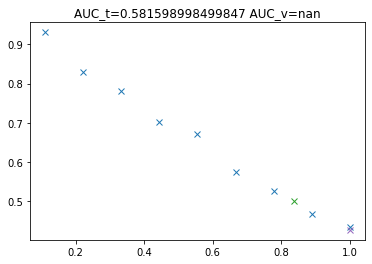

In [22]:
#Array_Ymatrix_Train[out_sel][0][0,0]
#35 285 2906
irow = 16;jcol=226
Yto_plot =[Array_Ymatrix_Train[i][0][irow,jcol] for i in range(9)]
Yto_plot_val =[Array_Ymatrix_Val[i][0][irow,jcol] for i in range(9)]
Yto_plot_IC50_train = Train_5folds_Ymatrix_IC50[0][irow,jcol]
Yto_plot_IC50_val = Val_5folds_Ymatrix_IC50[0][irow,jcol]
Yto_plot_Emax_train = Train_5folds_Ymatrix_Emax[0][irow,jcol]
Yto_plot_Emax_val = Val_5folds_Ymatrix_Emax[0][irow,jcol]
Yto_plot_AUC_train = Train_5folds_Ymatrix_AUC[0][irow,jcol]
Yto_plot_AUC_val = Val_5folds_Ymatrix_AUC[0][irow,jcol]
plt.plot(np.linspace(0.111111,1.0,9),np.exp(Yto_plot),'x')
plt.plot(np.linspace(0.111111,1.0,9),np.exp(Yto_plot_val),'x')
plt.plot(Yto_plot_IC50_train,0.5,'x')
plt.plot(Yto_plot_IC50_val,0.5,'x')
plt.plot(1.0,Yto_plot_Emax_train,'x')
plt.plot(1.0,Yto_plot_Emax_val,'x')
plt.title(f"AUC_t={Yto_plot_AUC_train} AUC_v={Yto_plot_AUC_val}")

#plt.plot(Train_5folds_Y[4][2906,:],'x')

In [23]:
#Train_5folds_IC50[0].shape
Train_5folds_AUC[0].shape

(2966, 1)

In [24]:
mat_check_train

array([[ True, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False,  True],
       [ True, False, False, ..., False, False,  True]])

In [25]:
Train_5folds_Ymatrix_IC50[4].shape

(48, 286)

In [26]:
Array_Ymatrix_Train[0][0].shape

Train_5folds_Ymatrix_IC50.append(YIC50_matrix_train.copy())
            Val_5folds_Ymatrix_IC50.append(YIC50_matrix_val.copy())

            Train_5folds_Ymatrix_AUC.append(YAUC_matrix_train.copy())
            Val_5folds_Ymatrix_AUC.append(YAUC_matrix_val.copy())

            Train_5folds_Ymatrix_Emax.append(YEmax_matrix_train.copy())
            Val_5folds_Ymatrix_Emax.append(YEmax_matrix_val.copy())

IndentationError: unexpected indent (3200469116.py, line 4)

In [121]:
path_to_save = "/home/juanjo/Work_Postdoc/Bench_Mark_DrugResponse_Models/SRMF-master/SRMF/FiveCancers_Dataset_FullCurve/"

for Nout in range(9):
    #np.savetxt(path_to_save+"out"+str(Nout+1)+"/Yresponse_matrix"+str(Nout+1)+".csv", Array_Ymatrix_Train[Nout], delimiter=",")
    final_path = path_to_save+"out"+str(Nout+1)+"/"
    if not os.path.exists(final_path):
        os.makedirs(final_path)
    for i in range(5):
        np.savetxt(final_path+"Yresponse"+str(Nout+1)+"_Train_fold"+str(i+1)+".csv", Array_Ymatrix_Train[Nout][i], delimiter=",")
        np.savetxt(final_path+"Yresponse"+str(Nout+1)+"_Val_fold"+str(i+1)+".csv", Array_Ymatrix_Val[Nout][i], delimiter=",")

for i in range(5):
    #Data for Training. This is not used to trained, 
    #but can be useful to compare or at least check if it coindices we the Training outputs
    np.savetxt(path_to_save+"YIC50_Train_fold"+str(i+1)+".csv", Train_5folds_Ymatrix_IC50[i], delimiter=",")
    np.savetxt(path_to_save+"YAUC_Train_fold"+str(i+1)+".csv", Train_5folds_Ymatrix_AUC[i], delimiter=",")
    np.savetxt(path_to_save+"YEmax_Train_fold"+str(i+1)+".csv", Train_5folds_Ymatrix_Emax[i], delimiter=",")
    
    #Data for Validation. We would expect to use these data information to compute the metrics at the end.
    np.savetxt(path_to_save+"YIC50_Val_fold"+str(i+1)+".csv", Val_5folds_Ymatrix_IC50[i], delimiter=",")
    np.savetxt(path_to_save+"YAUC_Val_fold"+str(i+1)+".csv", Val_5folds_Ymatrix_AUC[i], delimiter=",")
    np.savetxt(path_to_save+"YEmax_Val_fold"+str(i+1)+".csv", Val_5folds_Ymatrix_Emax[i], delimiter=",")    

In [29]:
X_columns = df_train_No_MolecForm.columns[column_start:]
#columns_names = df_train_No_MolecForm.columns[28:30]
X_columns

Index(['ABCB1_mut', 'ACACA_mut', 'ACVR2A_mut', 'AFF4_mut', 'AHCTF1_mut',
       'AHNAK_mut', 'AKAP9_mut', 'ALK_mut', 'ANK3_mut', 'APAF1_mut',
       ...
       'MEK5', 'ERK5', 'RSK', 'Farnesyl-transferase (FNTA)', 'EGFR',
       'EGFR signaling', 'ERK MAPK signaling', 'Other', 'Other, kinases',
       'PI3K/MTOR signaling'],
      dtype='object', length=826)

In [33]:
for Nfold in range(5):
    df_Nfold_Train = df_train_drug_new_list[Nfold].copy()
    df_Nfold_Val = df_test_drug_new_list[Nfold].copy()
    if Nfold == 0:
        df_all = df_Nfold_Train.copy()
        df_all = pd.concat([df_all, df_Nfold_Val], ignore_index = True,sort = False)
    else:
        df_all = pd.concat([df_all, df_Nfold_Train], ignore_index = True,sort = False)
        df_all = pd.concat([df_all, df_Nfold_Val], ignore_index = True,sort = False)

In [34]:
#df_train_drug_new_list[0]
df_all.shape

(18145, 854)

In [35]:
X_columns = list(X_columns)
#list(X_columns)+["hola"]
X_columns_CosmicID_DrugID = ["COSMICID","DRUG_ID"]+ X_columns
df_train_X = df_all[X_columns_CosmicID_DrugID]
df_group_train_X_cells = df_train_X.drop_duplicates(subset ="COSMICID")
df_group_train_X_cells

,COSMICID,DRUG_ID,ABCB1_mut,ACACA_mut,ACVR2A_mut,AFF4_mut,AHCTF1_mut,AHNAK_mut,AKAP9_mut,ALK_mut,...,MEK5,ERK5,RSK,Farnesyl-transferase (FNTA),EGFR,EGFR signaling,ERK MAPK signaling,Other,"Other, kinases",PI3K/MTOR signaling
0,908449,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
1,946367,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
2,946369,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3,946373,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
4,946368,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3109,907047,1060,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3199,910910,119,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3225,946382,166,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3270,906851,222,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [37]:
#The Features associated to the cell lines are the names from:
#ABCB1_mut to chr9:98783216-98784364(NCRNA00092)_HypMET (X_columns[0:764])
#Then the Features associated to the Drugs are the names from: (X_columns[764:])
#molecular_weight to PI3K/MTOR signaling
X_columns_cells = X_columns[0:764]
X_columns_drugs = X_columns[764:]
#X_columns
#X_columns_cells
X_columns_drugs

['molecular_weight',
 'xlogp',
 'complexity',
 'F',
 'h_bond_donor_count',
 'O',
 'N',
 'S',
 'defined_atom_stereo_count',
 '2bonds',
 'heavy_atom_count',
 'bond_stereo_count',
 'B',
 'I',
 '3bonds',
 'surface_area',
 'Cl',
 'undefined_atom_stereo_count',
 'Br',
 'h_bond_acceptor_count',
 'rotatable_bond_count',
 'atom_stereo_count',
 'MTORC1',
 'PI3Kalpha',
 'AKT2',
 'BET',
 'PIM3',
 'HDAC1-10',
 'AKT3',
 'PI3K (Class 1)',
 'PDK1 (PDPK1)',
 'MEK1',
 'BRAF',
 'MAP3K8',
 'PI3Kdelta',
 'AKT1',
 'MEK2',
 'PI3Kbeta',
 'MTORC2',
 'AURKB',
 'RSK2',
 'PIM1',
 'PI3Kgamma',
 'ERK2',
 'CLK4',
 'DAPK3',
 'PI3K (class 1)',
 'ERK1',
 'HIPK2',
 'S6K1',
 'ERBB2',
 'MTOR',
 'MEK5',
 'ERK5',
 'RSK',
 'Farnesyl-transferase (FNTA)',
 'EGFR',
 'EGFR signaling',
 'ERK MAPK signaling',
 'Other',
 'Other, kinases',
 'PI3K/MTOR signaling']

In [39]:
df_train_X_CellLines =  df_group_train_X_cells[X_columns_cells]
df_train_X_CellLines

,ABCB1_mut,ACACA_mut,ACVR2A_mut,AFF4_mut,AHCTF1_mut,AHNAK_mut,AKAP9_mut,ALK_mut,ANK3_mut,APAF1_mut,...,chr7:150065169-150066351(REPIN1)_HypMET,chr7:32996732-32997591(FKBP9)_HypMET,chr7:99678768-99679702(ZNF3)_HypMET,chr8:11058624-11058844(XKR6)_HypMET,chr8:144659745-144660635(NAPRT1)_HypMET,chr8:22422534-22423702(SORBS3)_HypMET,chr8:67344497-67344989(RRS1)_HypMET,chr8:95652455-95652873(ESRP1)_HypMET,chr9:86571047-86572027(C9orf64)_HypMET,chr9:98783216-98784364(NCRNA00092)_HypMET
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3109,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3225,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3270,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


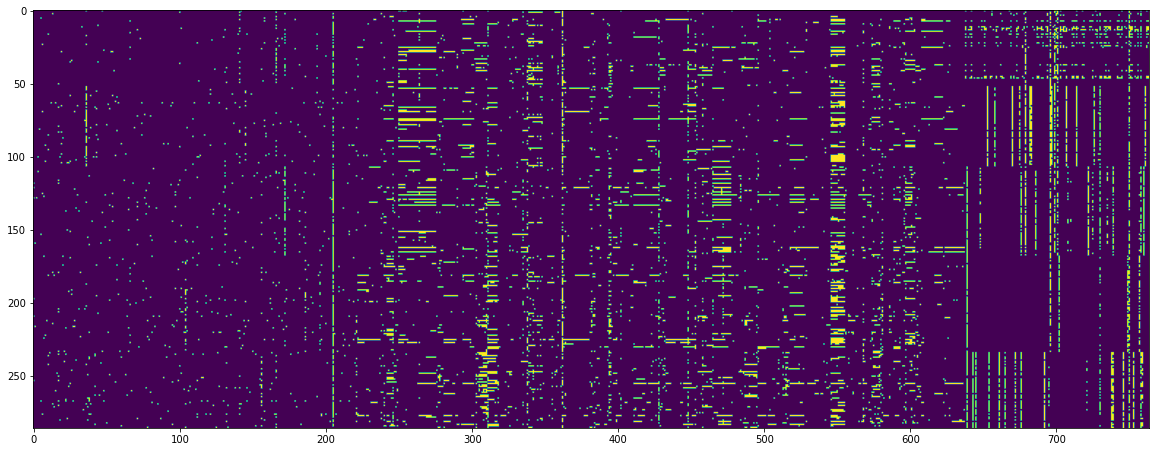

In [40]:
plt.figure(figsize=(20,40))
plt.imshow(df_train_X_CellLines)

In [41]:
X_columns_CosmicID_DrugID = ["COSMICID","DRUG_ID"]+ X_columns
df_train_X = df_all[X_columns_CosmicID_DrugID]
df_group_train_X_drugs = df_train_X.drop_duplicates(subset ="DRUG_ID")
df_group_train_X_drugs

,COSMICID,DRUG_ID,ABCB1_mut,ACACA_mut,ACVR2A_mut,AFF4_mut,AHCTF1_mut,AHNAK_mut,AKAP9_mut,ALK_mut,...,MEK5,ERK5,RSK,Farnesyl-transferase (FNTA),EGFR,EGFR signaling,ERK MAPK signaling,Other,"Other, kinases",PI3K/MTOR signaling
0,908449,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
5,908449,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
22,1240169,1032,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
30,908145,1036,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
43,905982,1039,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
52,908449,29,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
59,905982,1053,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
82,905982,1057,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
117,905982,1058,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
145,687590,1060,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


(286, 764)

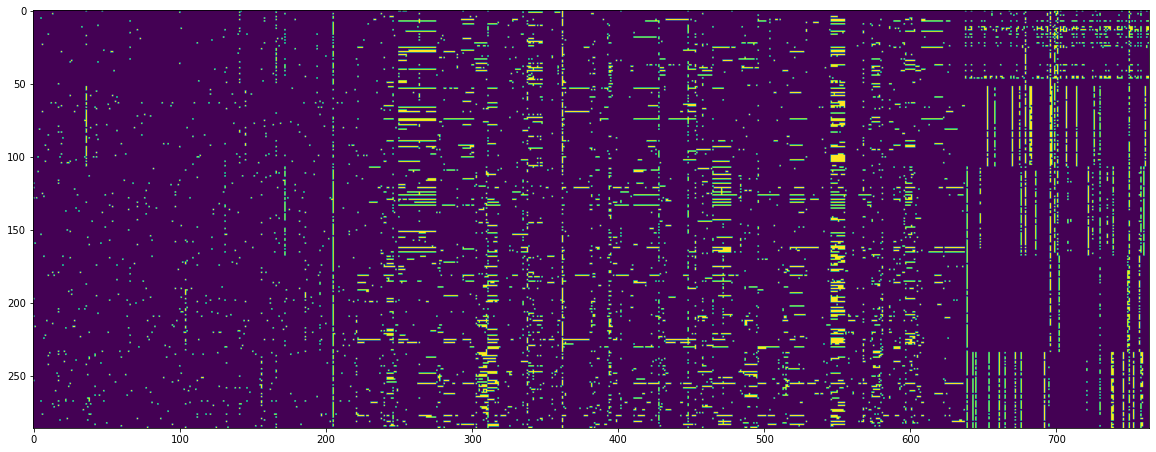

In [42]:
scaler_cells = MinMaxScaler().fit(df_train_X_CellLines)
X_cells_features = scaler_cells.transform(df_train_X_CellLines)
plt.figure(figsize=(20,40))
plt.imshow(X_cells_features)
X_cells_features.shape

In [44]:
Matrix_cells_corr = np.corrcoef(X_cells_features)
Matrix_cells_corr.shape
#print(np.corrcoef(X_cells_features[0,:],X_cells_features[1,:]))

(286, 286)

In [107]:
np.savetxt(path_to_save+"Matrix_cells.csv", Matrix_cells_corr, delimiter=",")
Matrix_cells_corr

array([[ 1.        ,  0.4769914 ,  0.44037222, ..., -0.00464389,
         0.20702916,  0.08481112],
       [ 0.4769914 ,  1.        ,  0.48250781, ...,  0.00889386,
         0.02016608,  0.01411606],
       [ 0.44037222,  0.48250781,  1.        , ...,  0.08383947,
         0.10375125, -0.03326331],
       ...,
       [-0.00464389,  0.00889386,  0.08383947, ...,  1.        ,
         0.04856694,  0.27571019],
       [ 0.20702916,  0.02016608,  0.10375125, ...,  0.04856694,
         1.        ,  0.26283021],
       [ 0.08481112,  0.01411606, -0.03326331, ...,  0.27571019,
         0.26283021,  1.        ]])

In [45]:
#df_group_train_X_drugs.sort_values("DRUG_ID")
#plt.plot(df_group_train_X_drugs["DRUG_ID"])
#plt.plot(df_group_train_X_drugs.sort_values("DRUG_ID"))
df_group_train_X_drugs_sorted = df_group_train_X_drugs.sort_values("DRUG_ID").reset_index()

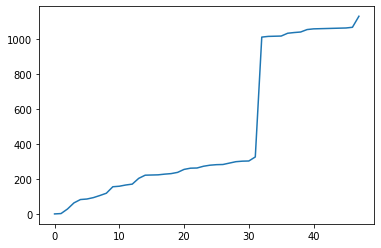

In [46]:
plt.plot(df_group_train_X_drugs_sorted["DRUG_ID"])

In [47]:
df_train_X_Drugs =  df_group_train_X_drugs_sorted[X_columns_drugs]
df_train_X_Drugs

,molecular_weight,xlogp,complexity,F,h_bond_donor_count,O,N,S,defined_atom_stereo_count,2bonds,...,MEK5,ERK5,RSK,Farnesyl-transferase (FNTA),EGFR,EGFR signaling,ERK MAPK signaling,Other,"Other, kinases",PI3K/MTOR signaling
0,393.40,3.3,525,0,1,1,1,0,0,8,...,0,0,0,0,1,1,0,0,0,0
1,914.20,6.0,1760,0,3,1,1,0,15,9,...,0,0,0,0,0,0,0,0,0,1
2,451.50,4.2,845,0,2,1,1,0,0,12,...,0,0,0,0,0,0,1,0,0,0
3,358.80,2.5,458,0,2,1,1,0,0,8,...,0,0,0,0,0,0,1,0,0,0
4,607.60,6.0,1110,1,0,1,1,0,0,16,...,0,0,0,0,0,0,0,0,0,1
5,397.50,3.7,562,0,3,1,1,0,1,11,...,0,0,0,0,0,0,0,0,0,1
6,364.40,1.9,710,0,1,1,1,0,0,8,...,0,0,0,0,0,0,0,0,0,1
7,459.50,3.1,703,0,1,1,1,0,0,10,...,0,1,0,0,0,0,0,1,0,0
8,581.10,5.1,898,1,2,1,1,1,0,15,...,0,0,0,0,1,1,0,0,0,0
9,408.40,2.0,838,0,2,1,1,0,1,9,...,0,0,0,0,0,0,0,0,0,1


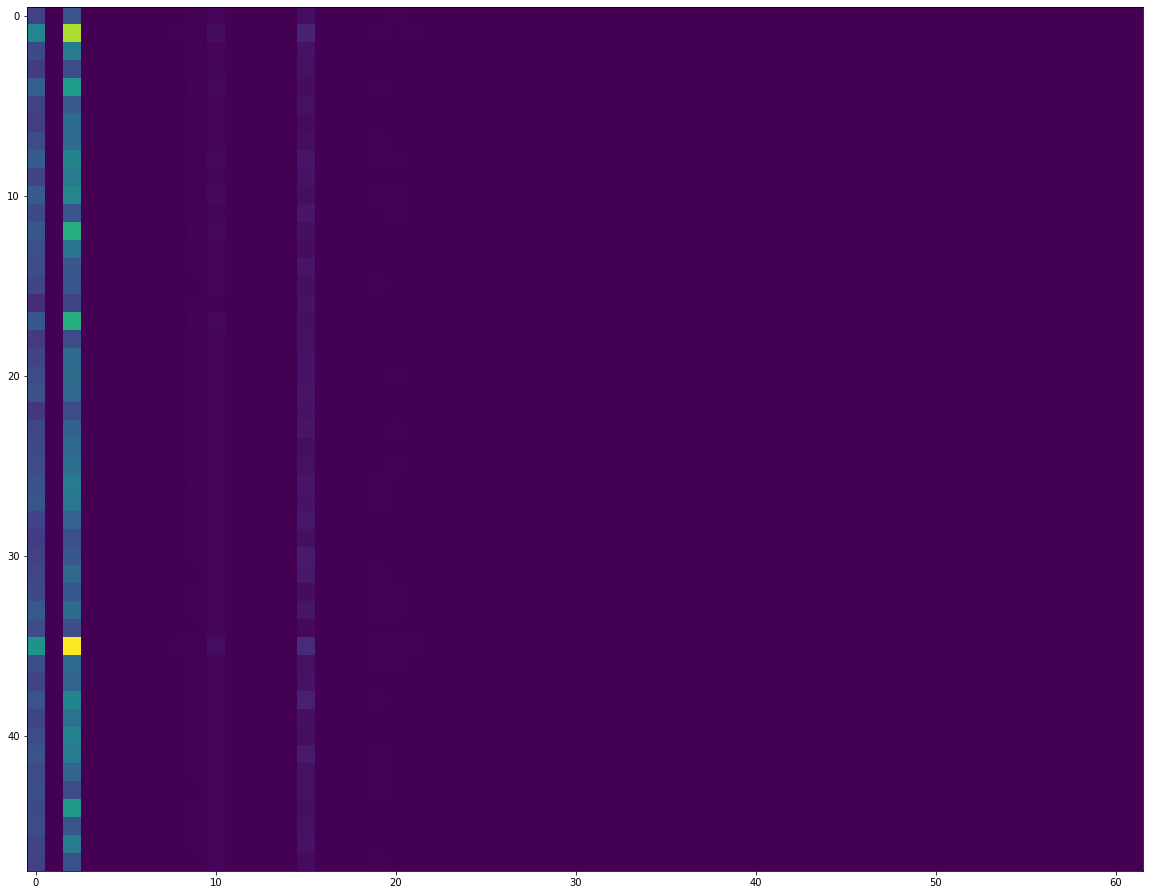

In [48]:
plt.figure(figsize=(20,40))
plt.imshow(df_train_X_Drugs)

(48, 62)

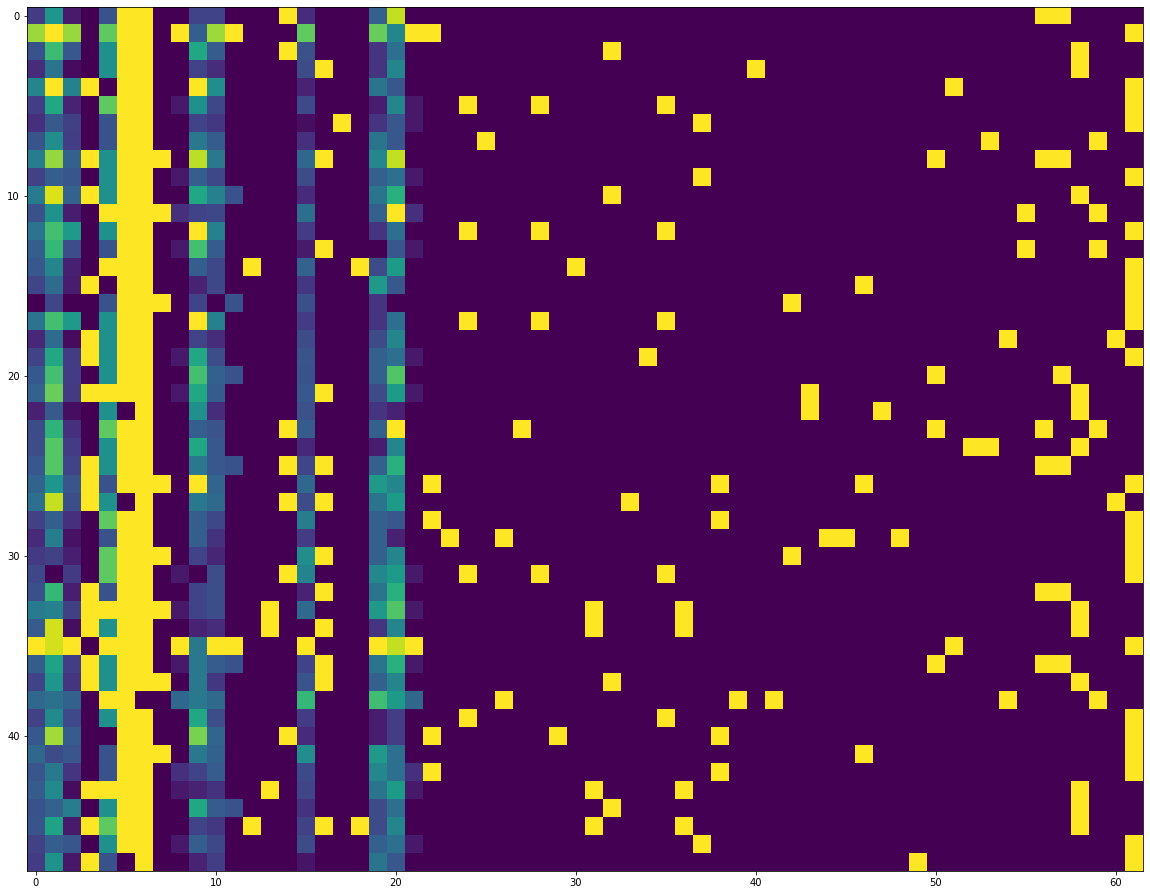

In [49]:
scaler_drugs = MinMaxScaler().fit(df_train_X_Drugs)
X_drug_features = scaler_drugs.transform(df_train_X_Drugs)
#Xtest_drug = scaler.transform(df_test_drug_new[X_columns])
plt.figure(figsize=(20,40))
plt.imshow(X_drug_features)
X_drug_features.shape

In [50]:
Matrix_drug_corr = np.corrcoef(X_drug_features)
Matrix_drug_corr.shape
#print(np.corrcoef(X_drug_features[0,:],X_drug_features[1,:]))

(48, 48)

In [114]:
np.savetxt(path_to_save+"Matrix_drugs.csv", Matrix_drug_corr, delimiter=",")
Matrix_drug_corr

array([[1.        , 0.31131248, 0.57152203, ..., 0.24729149, 0.43138158,
        0.22308486],
       [0.31131248, 1.        , 0.36465569, ..., 0.17975115, 0.57717545,
        0.36544846],
       [0.57152203, 0.36465569, 1.        , ..., 0.40493703, 0.45311831,
        0.21645354],
       ...,
       [0.24729149, 0.17975115, 0.40493703, ..., 1.        , 0.29260647,
        0.2899772 ],
       [0.43138158, 0.57717545, 0.45311831, ..., 0.29260647, 1.        ,
        0.48192451],
       [0.22308486, 0.36544846, 0.21645354, ..., 0.2899772 , 0.48192451,
        1.        ]])

In [103]:
df_train_X_Drugs

,molecular_weight,xlogp,complexity,F,h_bond_donor_count,O,N,S,defined_atom_stereo_count,2bonds,...,MEK5,ERK5,RSK,Farnesyl-transferase (FNTA),EGFR,EGFR signaling,ERK MAPK signaling,Other,"Other, kinases",PI3K/MTOR signaling
0,393.40,3.3,525,0,1,1,1,0,0,8,...,0,0,0,0,1,1,0,0,0,0
1,914.20,6.0,1760,0,3,1,1,0,15,9,...,0,0,0,0,0,0,0,0,0,1
2,451.50,4.2,845,0,2,1,1,0,0,12,...,0,0,0,0,0,0,1,0,0,0
3,358.80,2.5,458,0,2,1,1,0,0,8,...,0,0,0,0,0,0,1,0,0,0
4,607.60,6.0,1110,1,0,1,1,0,0,16,...,0,0,0,0,0,0,0,0,0,1
5,397.50,3.7,562,0,3,1,1,0,1,11,...,0,0,0,0,0,0,0,0,0,1
6,364.40,1.9,710,0,1,1,1,0,0,8,...,0,0,0,0,0,0,0,0,0,1
7,459.50,3.1,703,0,1,1,1,0,0,10,...,0,1,0,0,0,0,0,1,0,0
8,581.10,5.1,898,1,2,1,1,1,0,15,...,0,0,0,0,1,1,0,0,0,0
9,408.40,2.0,838,0,2,1,1,0,1,9,...,0,0,0,0,0,0,0,0,0,1


In [105]:
print(Matrix_drug_corr.shape)
print(Matrix_cells_corr.shape)

(48, 48)
(286, 286)
